In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

import rdp

In [2]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [20]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()
    

In [68]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2

for line in bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].reset_index(drop=True).copy()
    add_distance_to_gdf(ll[line])

In [109]:
def simplify_rdp(line_gdf,epsilon=20):
    
    if line_gdf.line_name.unique().size==1:
        line_name = line_gdf.line_name.unique()[0]
    else:
        raise ValuError('multiple line names')
    
    rdped_df = pd.DataFrame( rdp.rdp( line_gdf.loc[:,['x','y','DELAY']].to_numpy(), epsilon=epsilon),
                            columns = ['x','y','DELAY'] )
    
    points = [Point(xy) for xy in zip(rdped_df.x,rdped_df.y)]
    
    rdped_gdf = gpd.GeoDataFrame(rdped_df,geometry=points,crs="EPSG:3031")
    
    add_distance_to_gdf(rdped_gdf)
    
    rdped_gdf['line_name'] = line_name
    
    return rdped_gdf

In [110]:
sl = {} #simplified lines

for line_name, line_gdf in ll.items():
    
    sl[line_name] = simplify_rdp(line_gdf)

In [86]:
def plot_rdp(line_name,epsilon):

    rdped = rdp.rdp( ll[line_name].loc[:,['x','y','DELAY']].to_numpy(), epsilon=epsilon)
    
    plt.figure(figsize=(20,10))
    plt.plot(ll[line_name].x,ll[line_name].DELAY ,'.',label = 'original line')
    plt.plot(rdped[:,0],rdped[:,2] ,'x-',label='reduced sample of line')
    plt.grid()
    plt.title(line_name)
    plt.show()

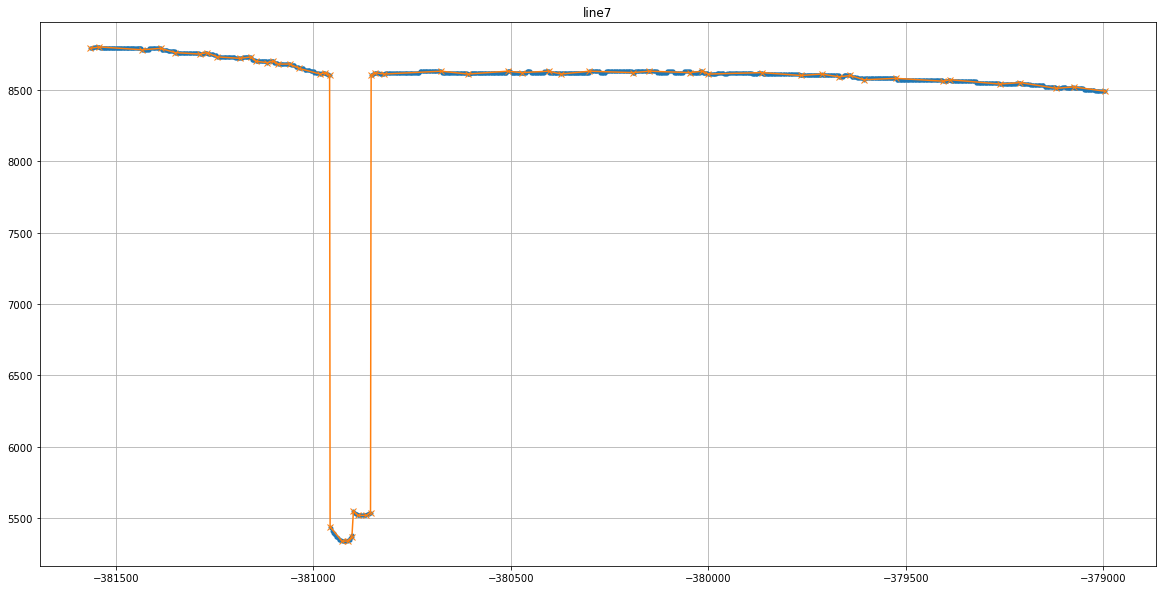

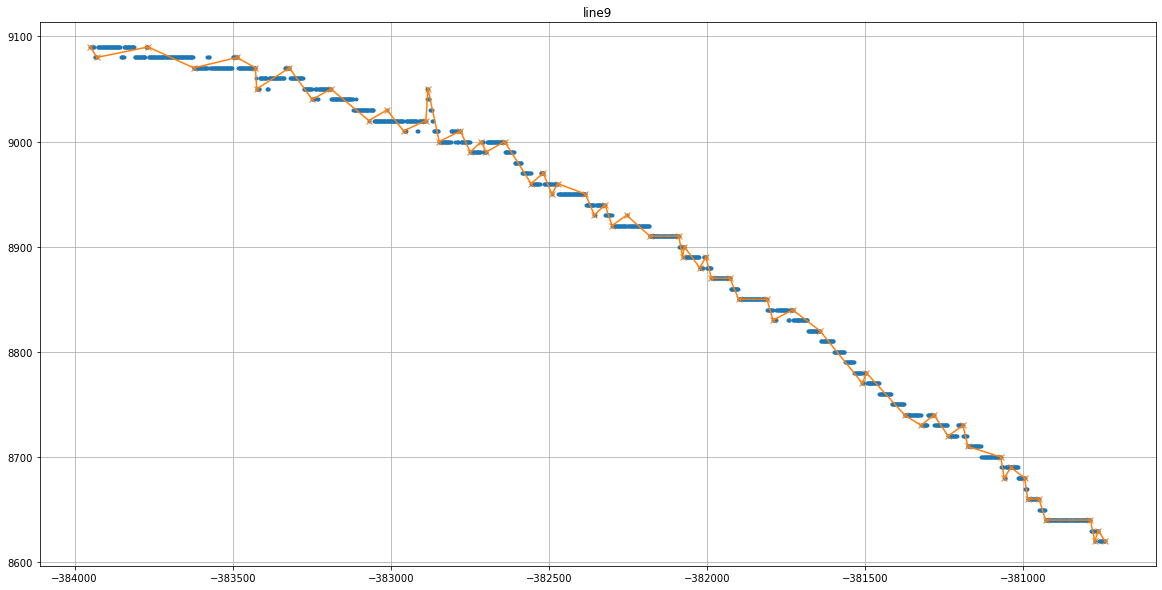

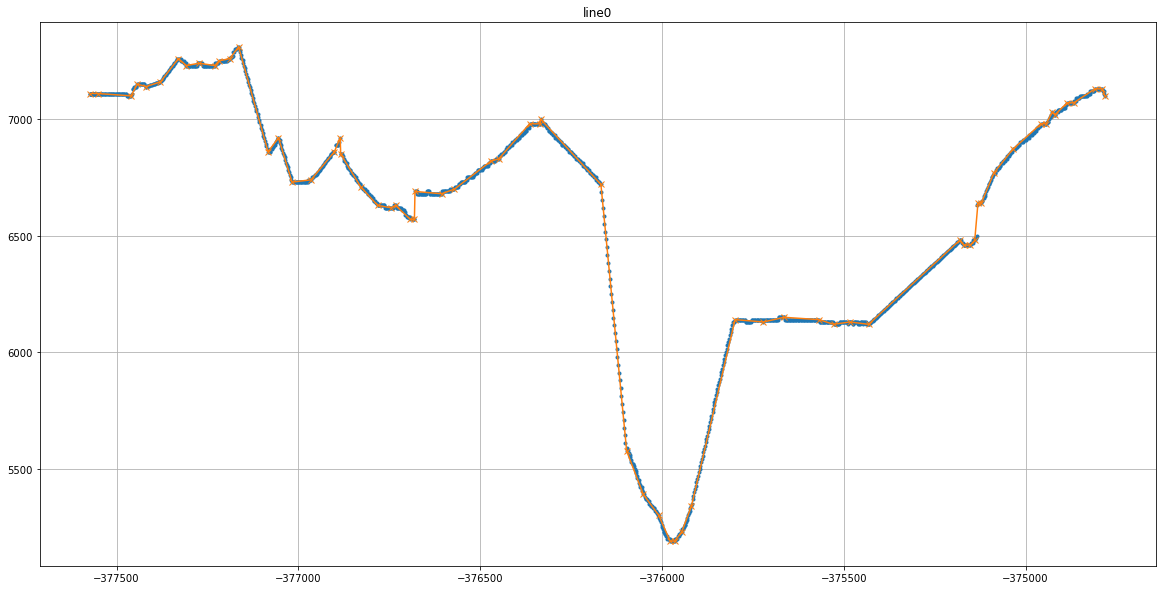

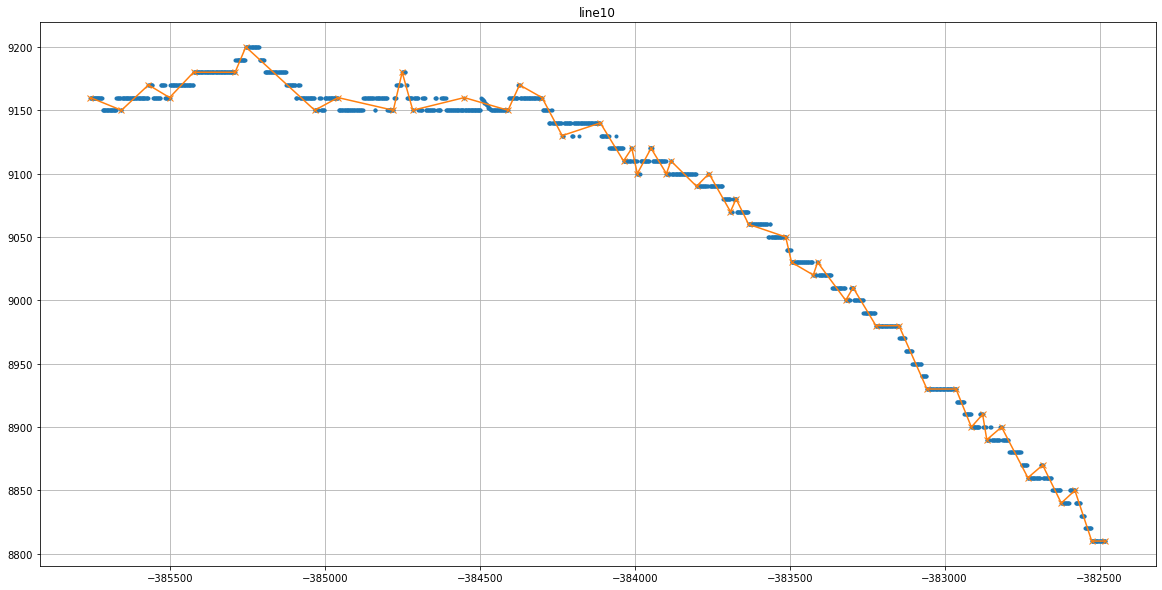

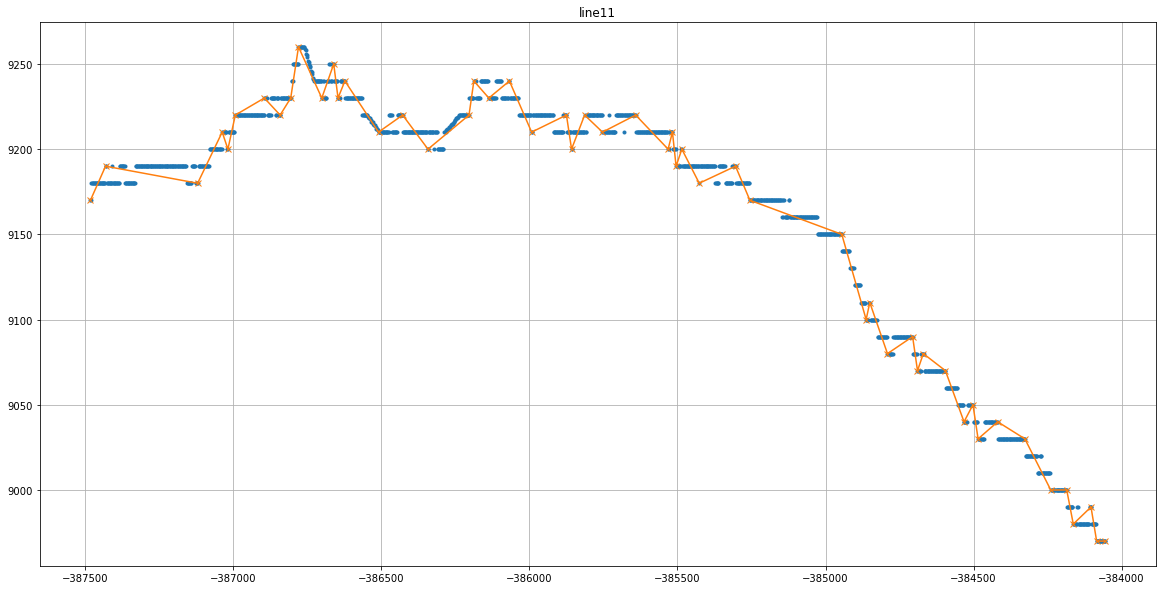

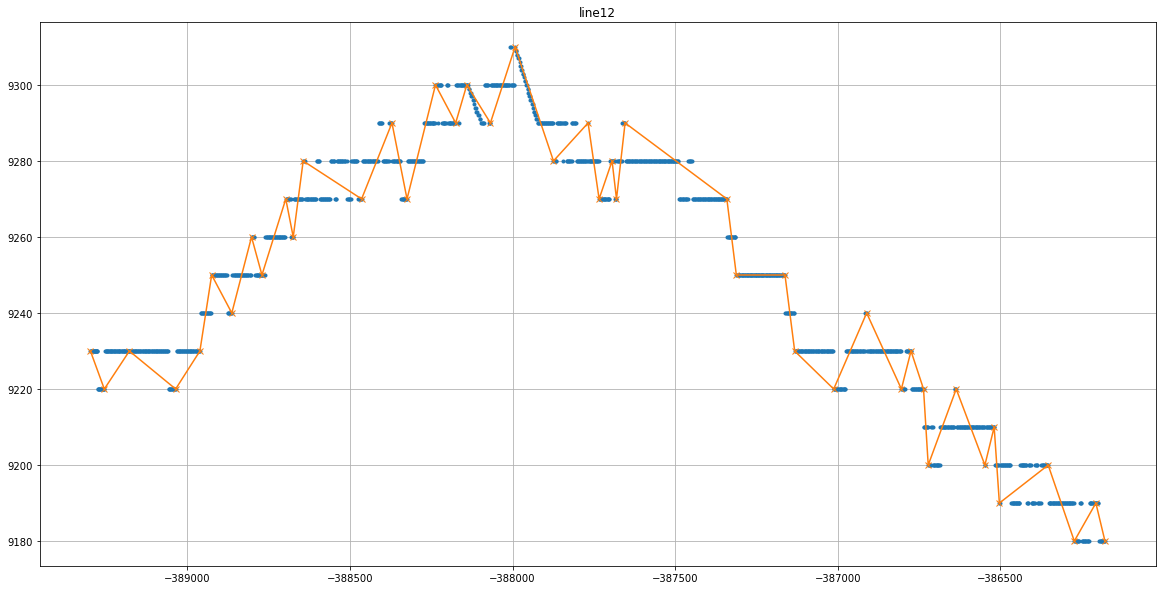

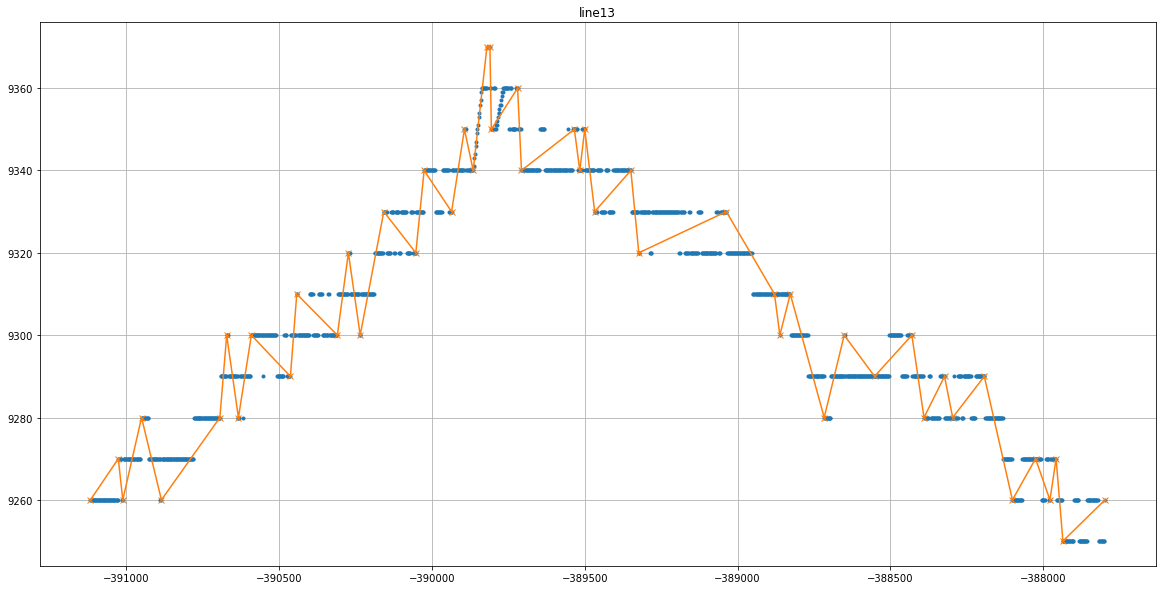

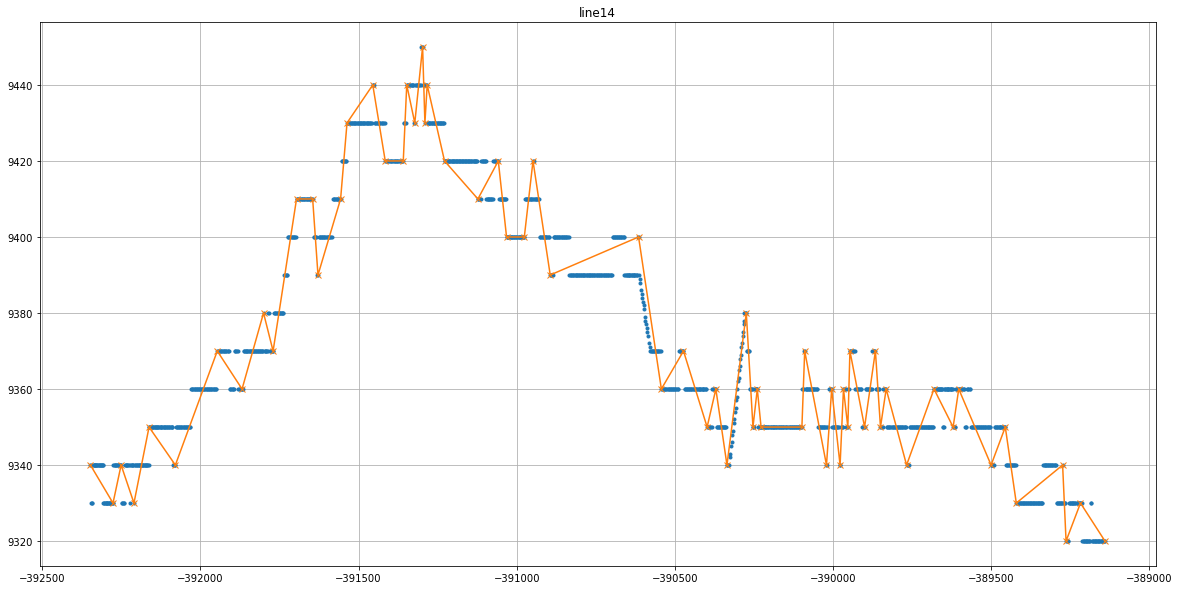

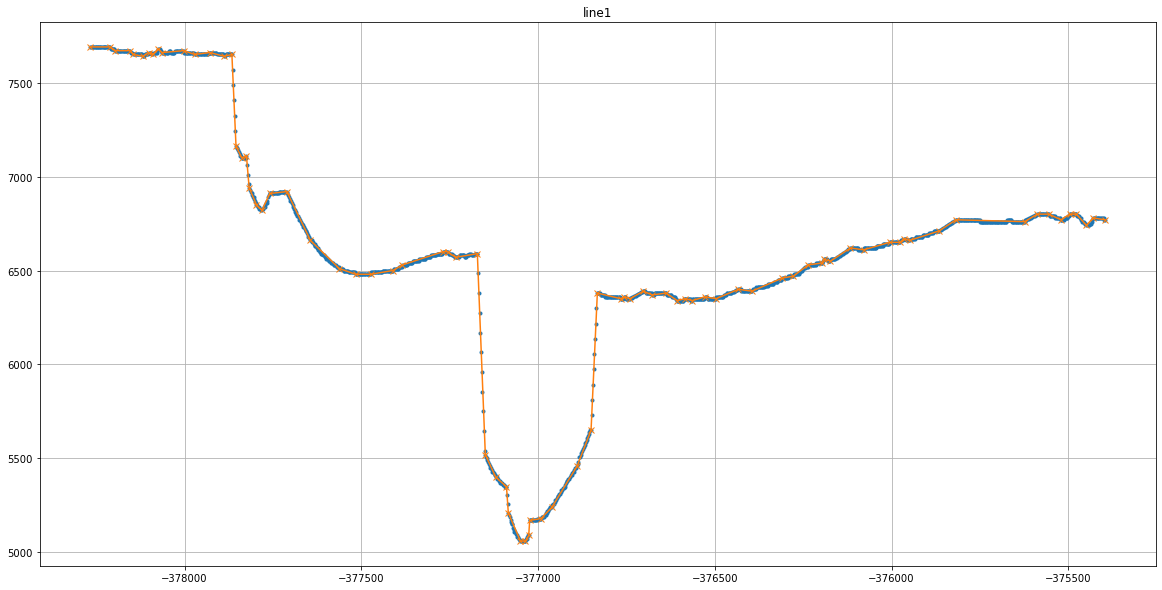

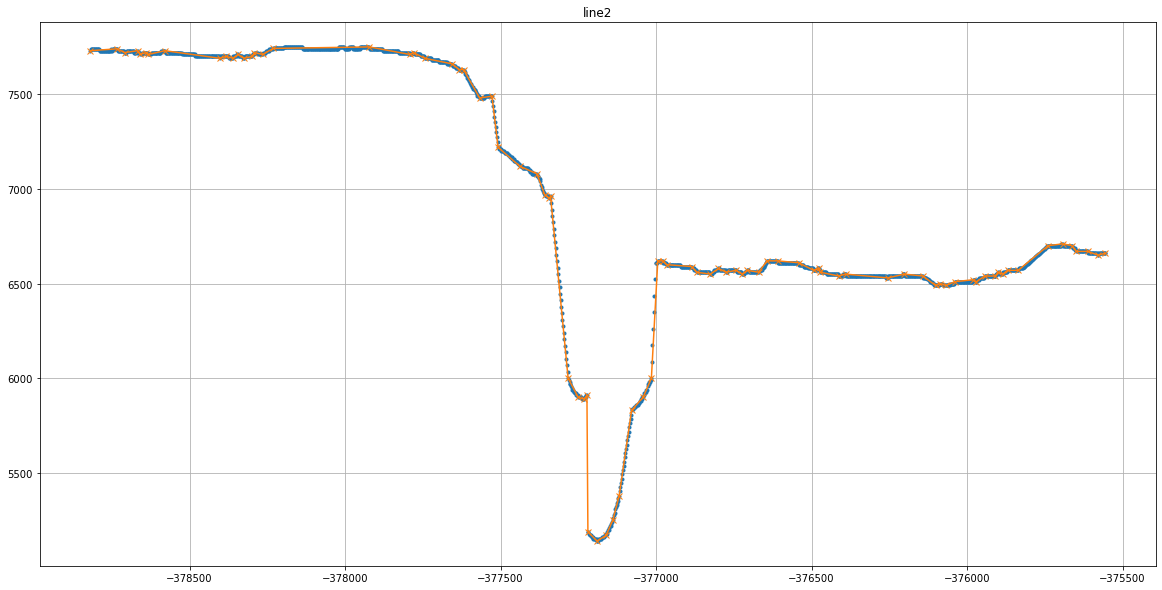

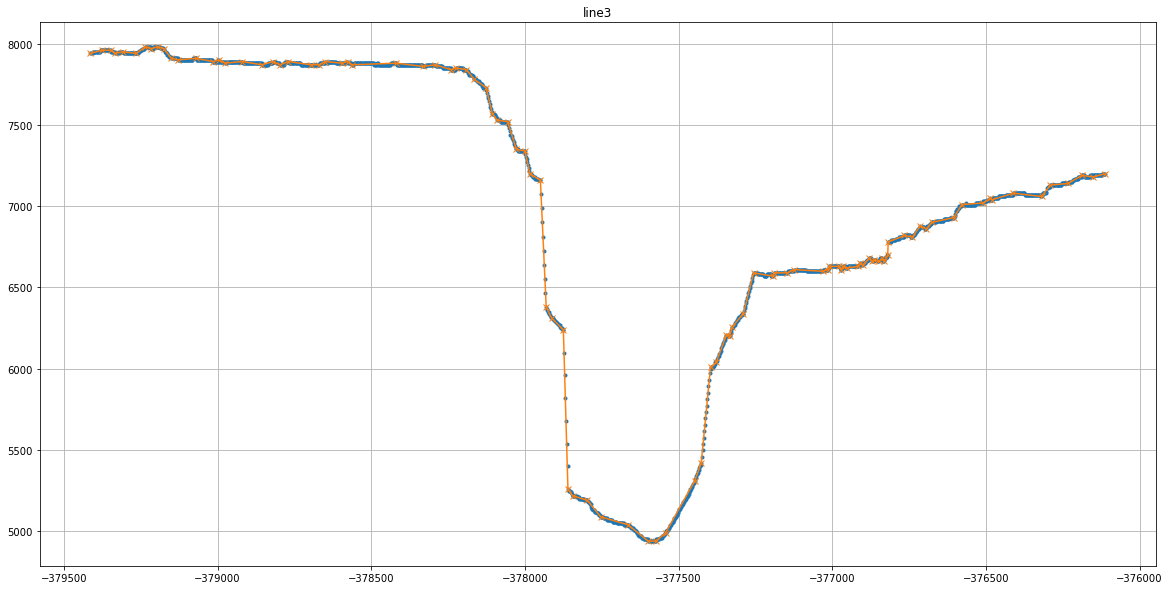

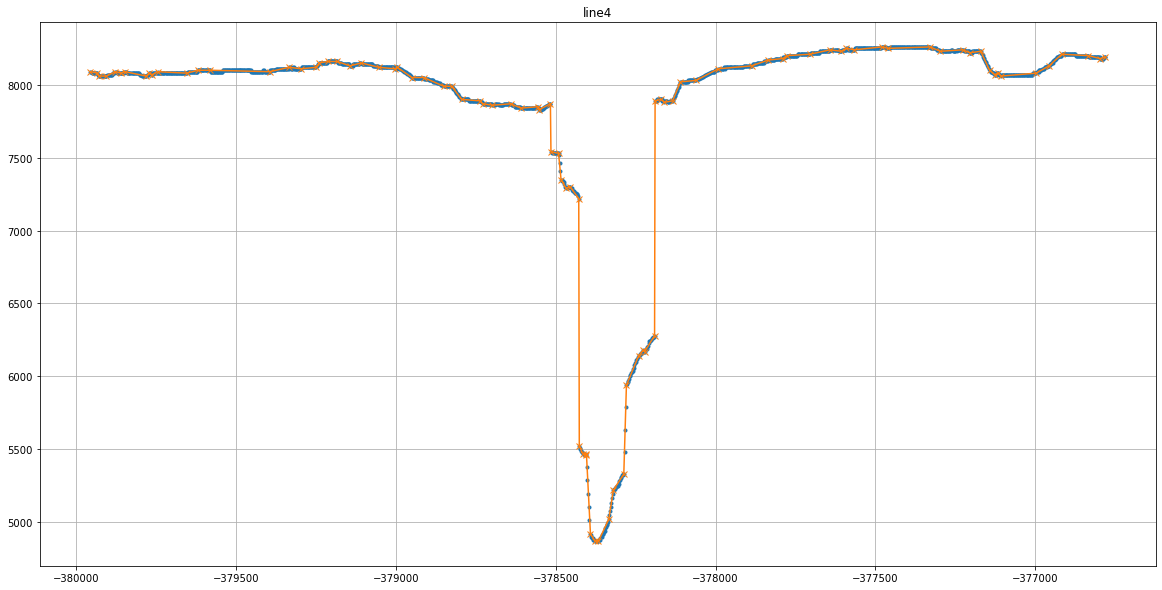

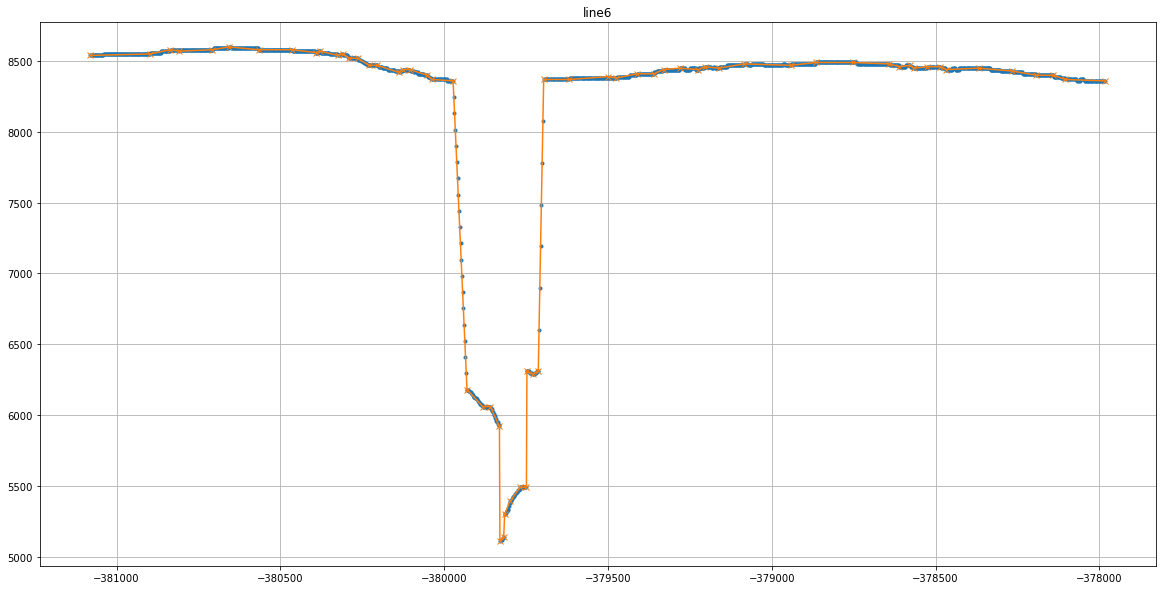

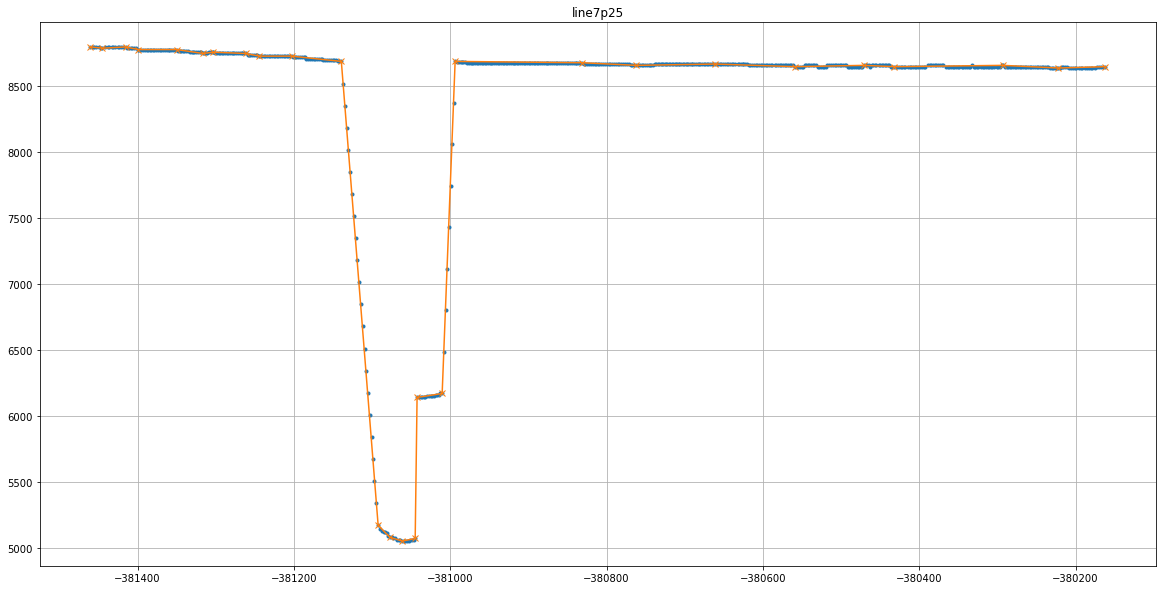

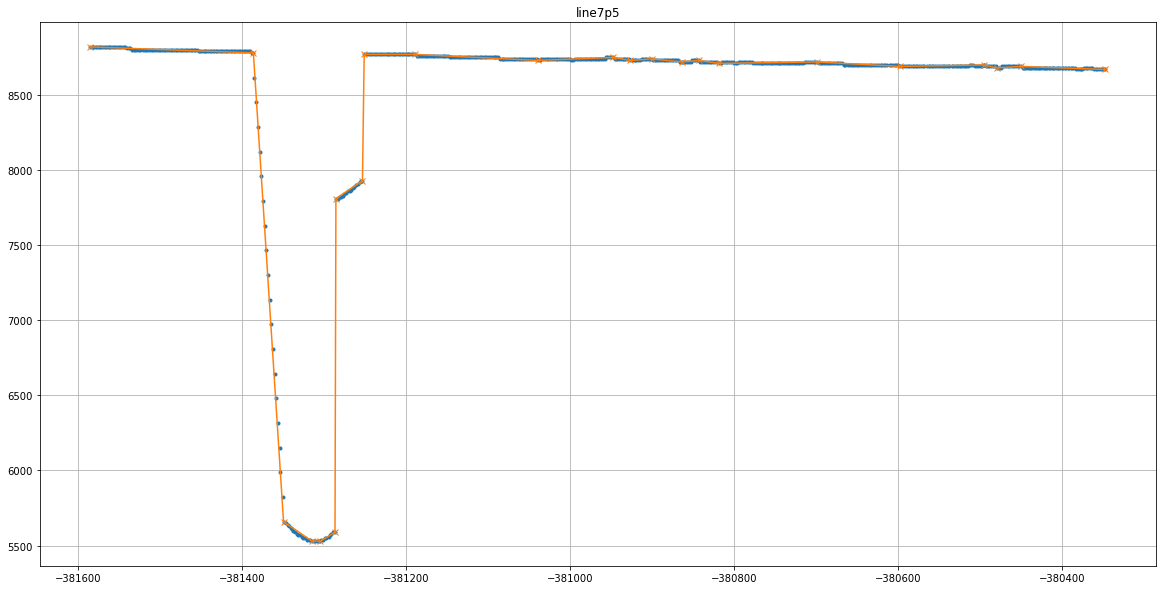

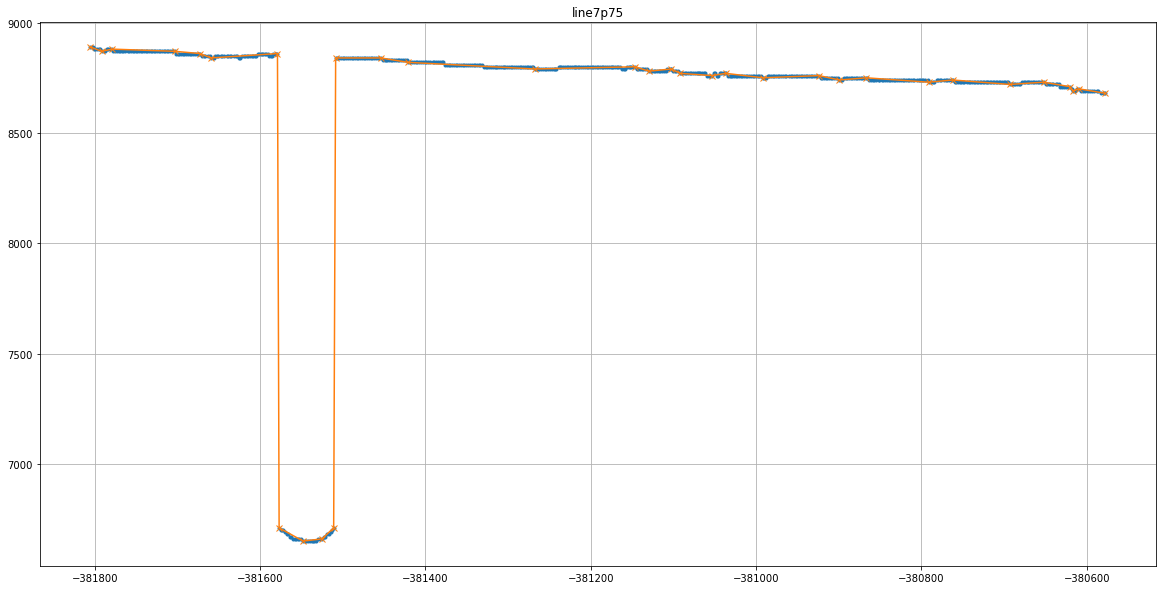

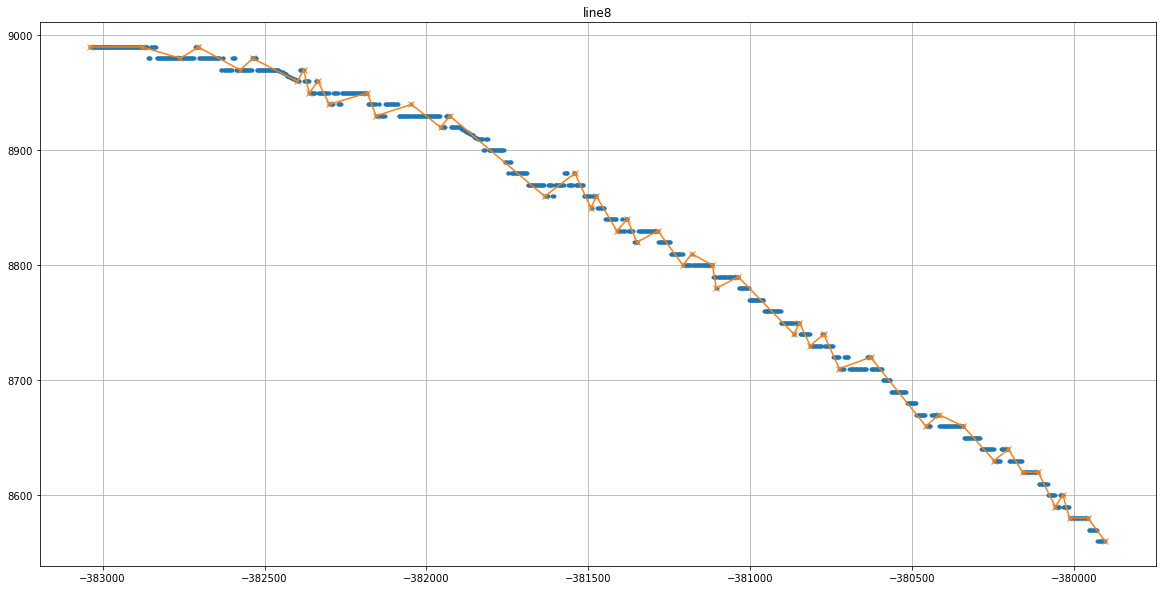

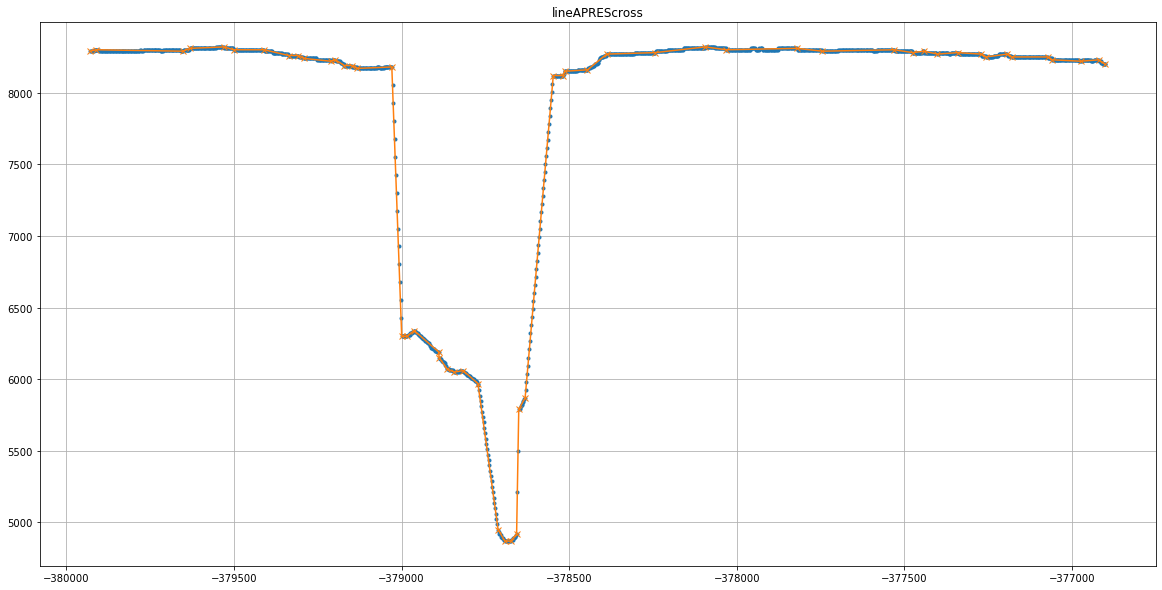

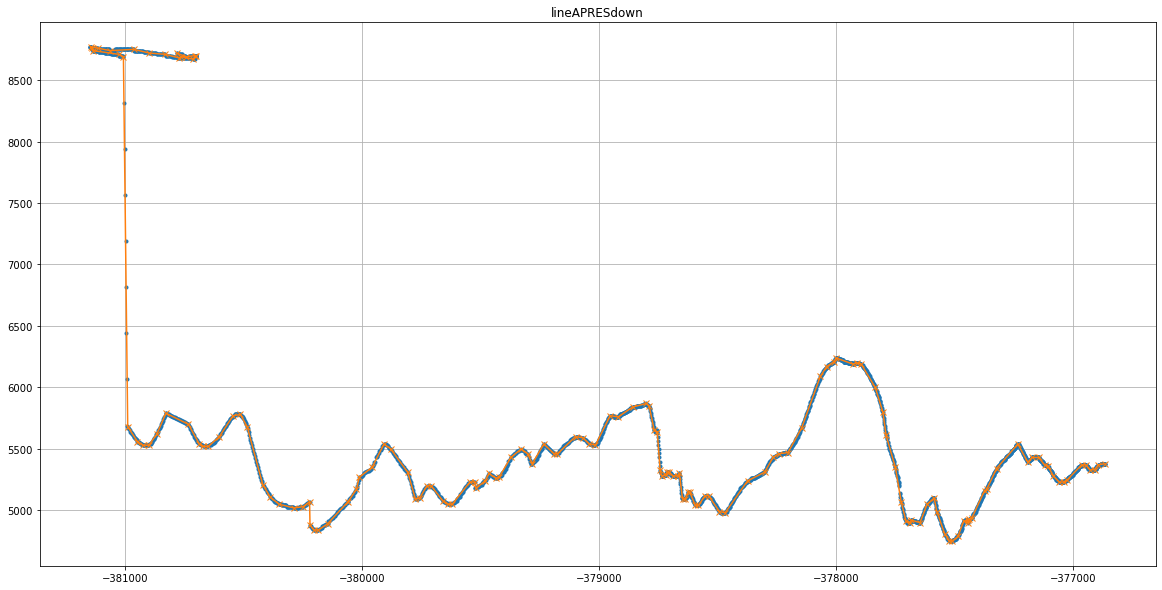

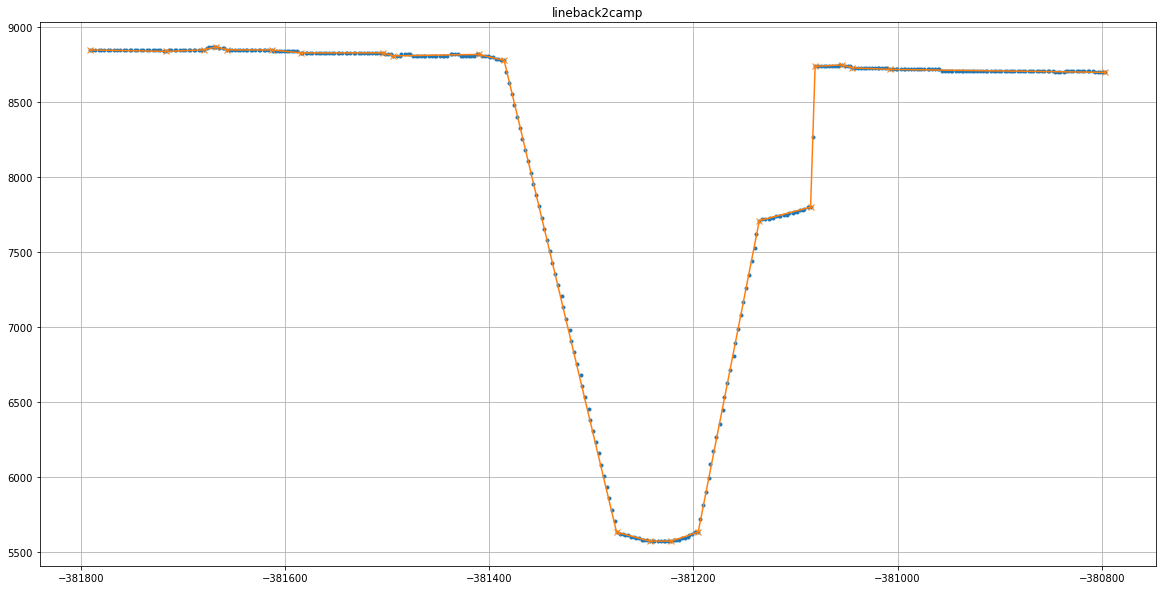

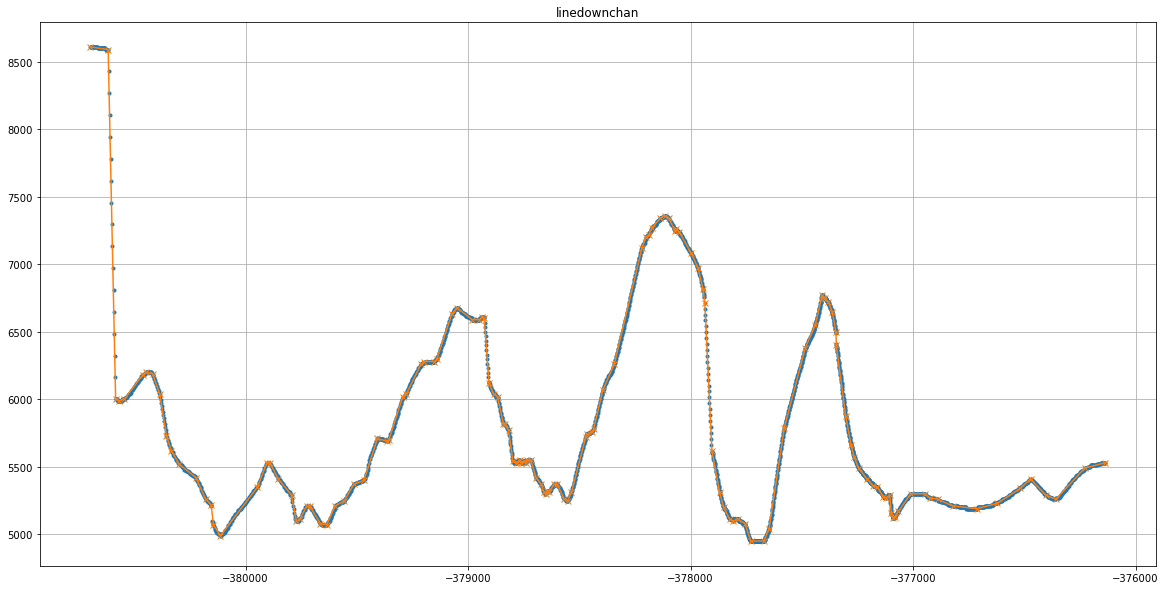

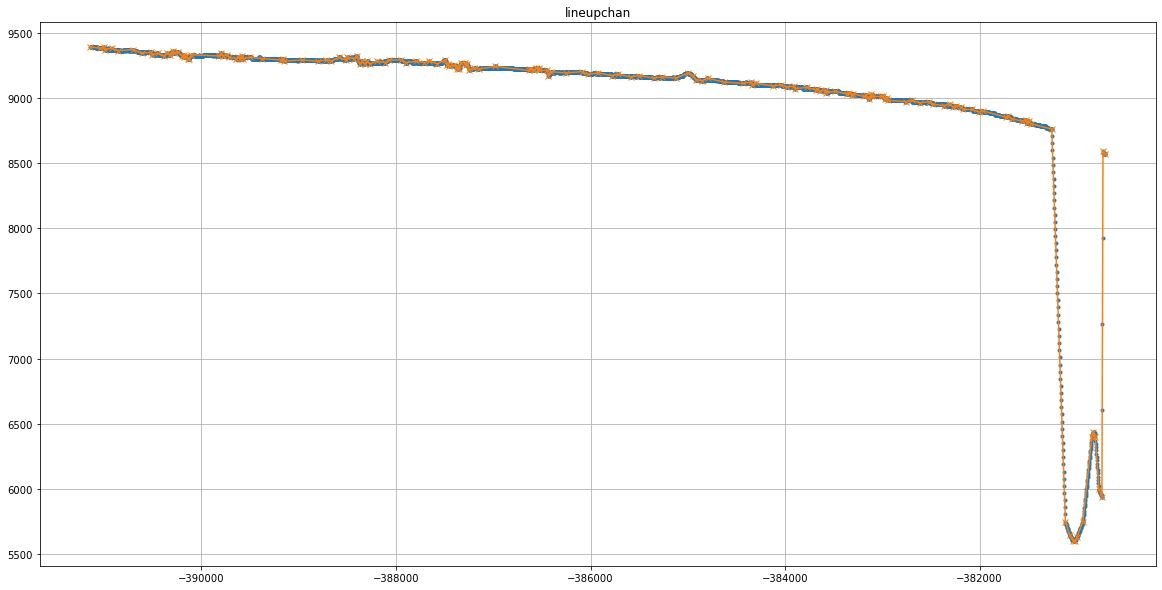

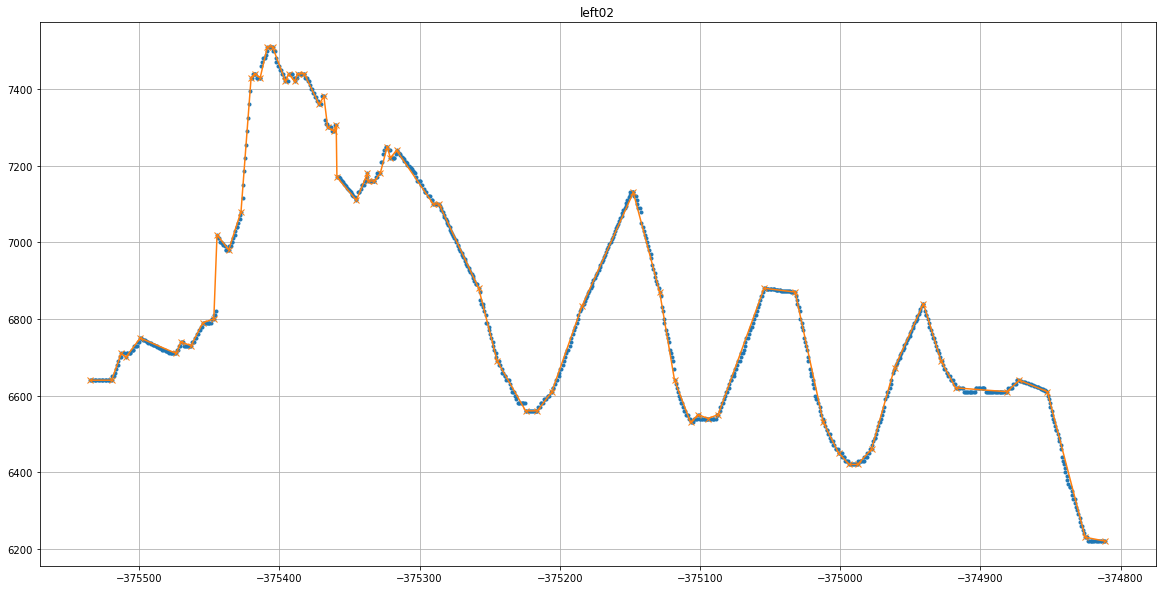

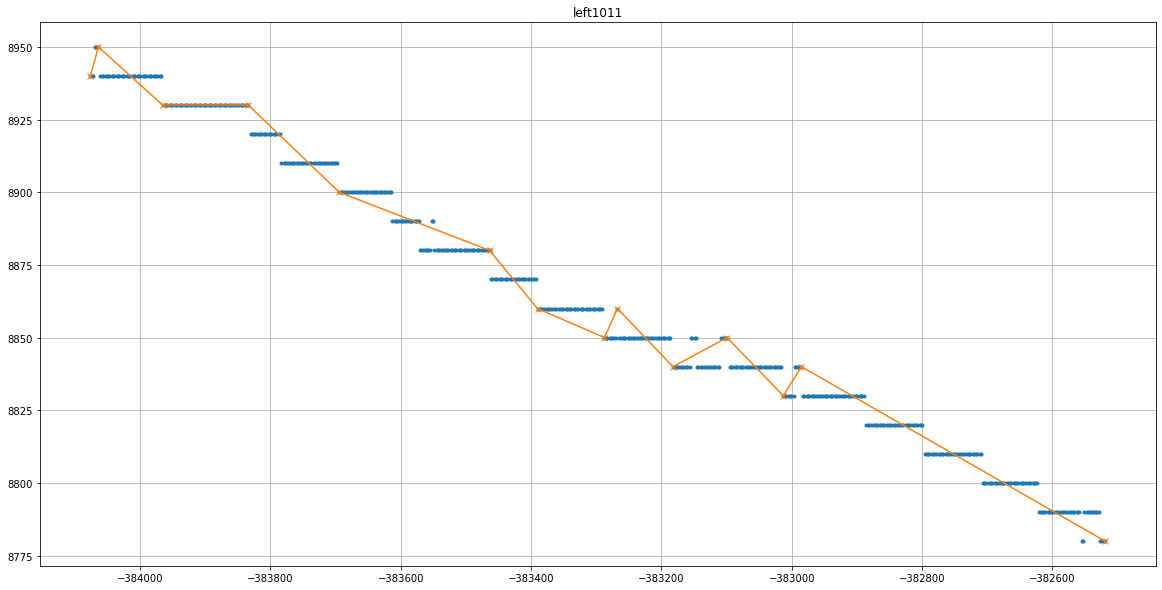

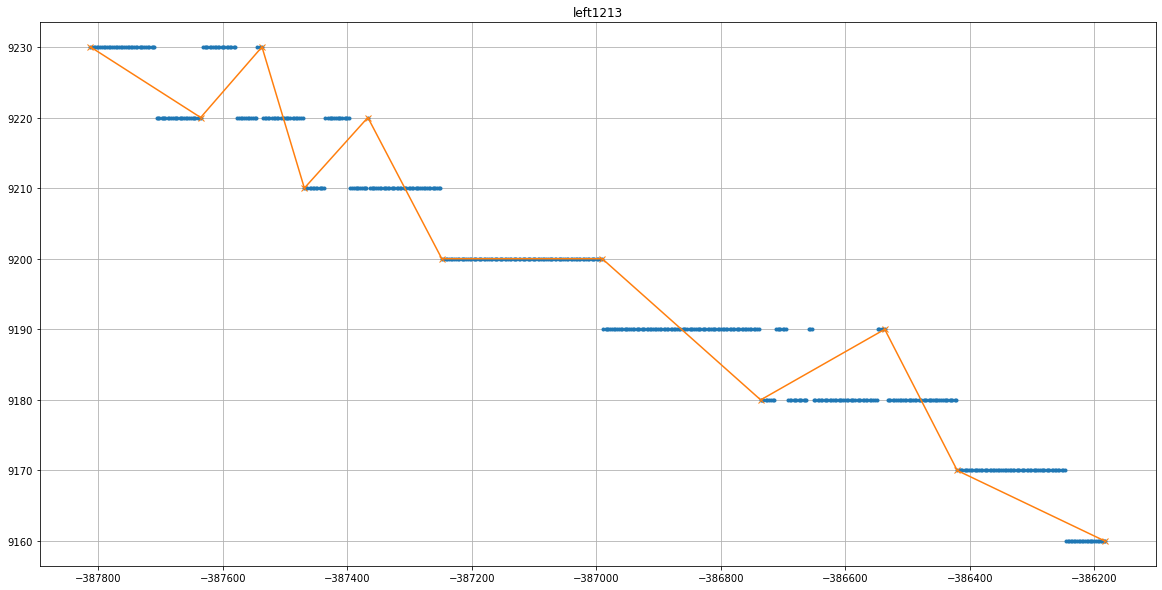

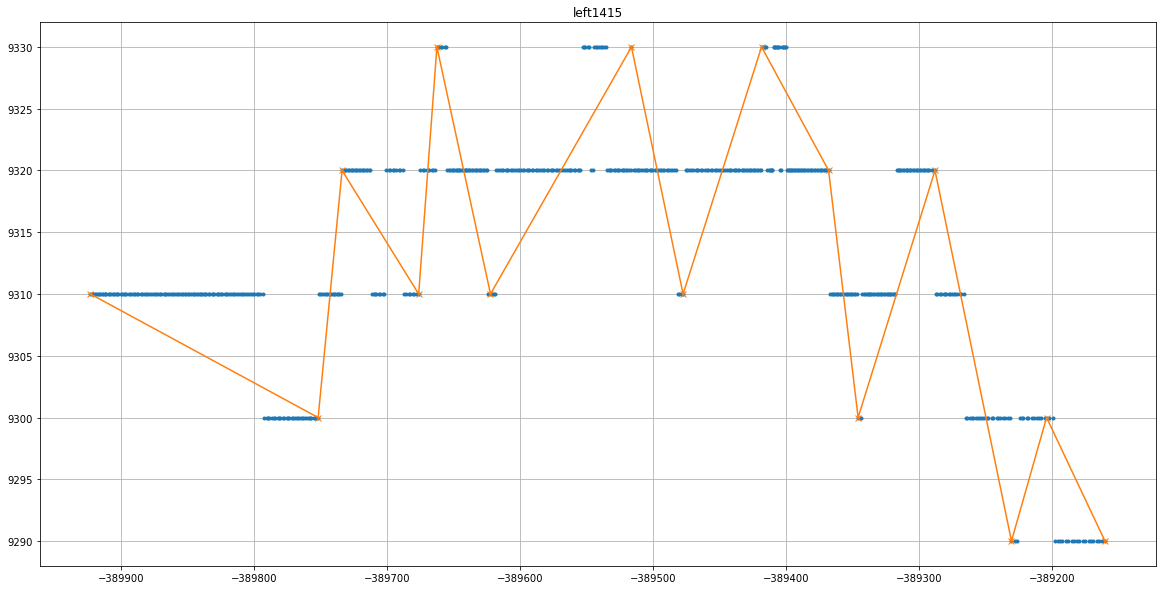

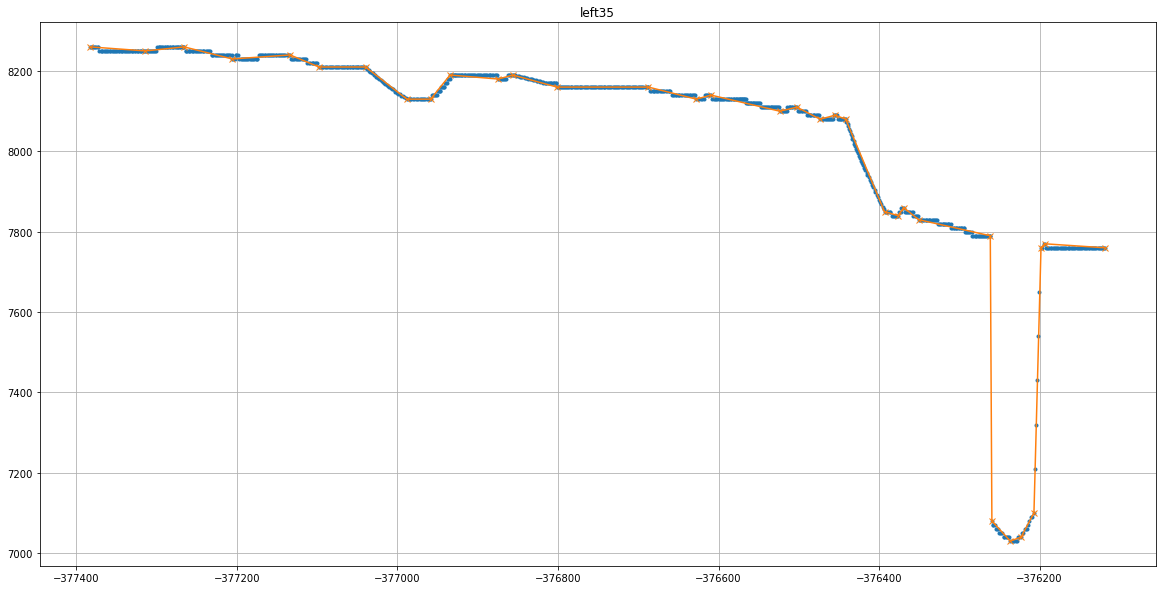

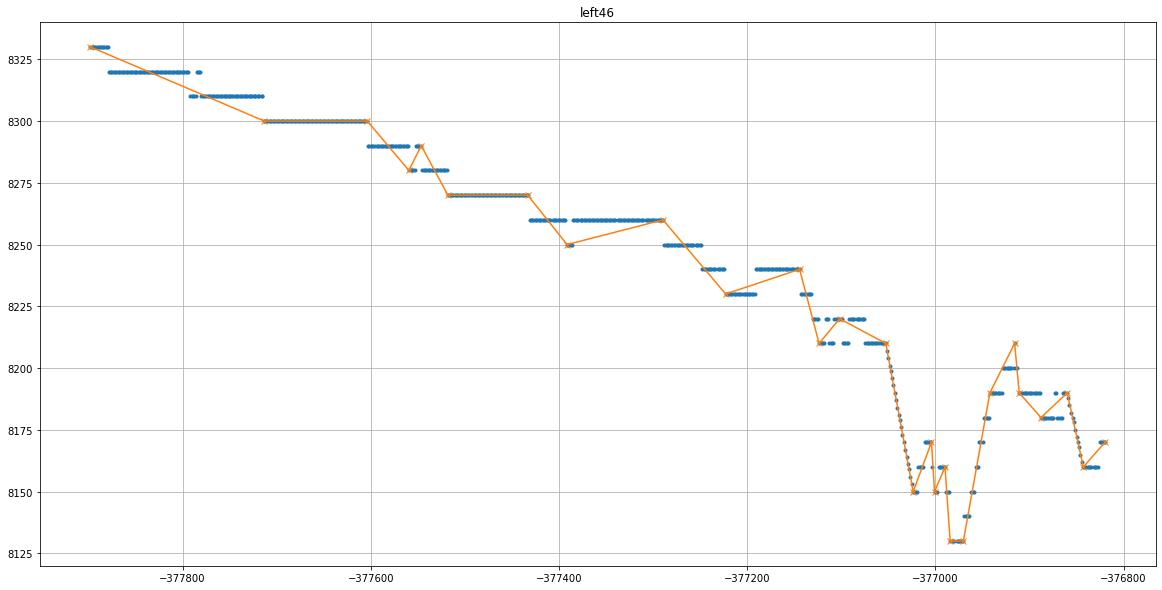

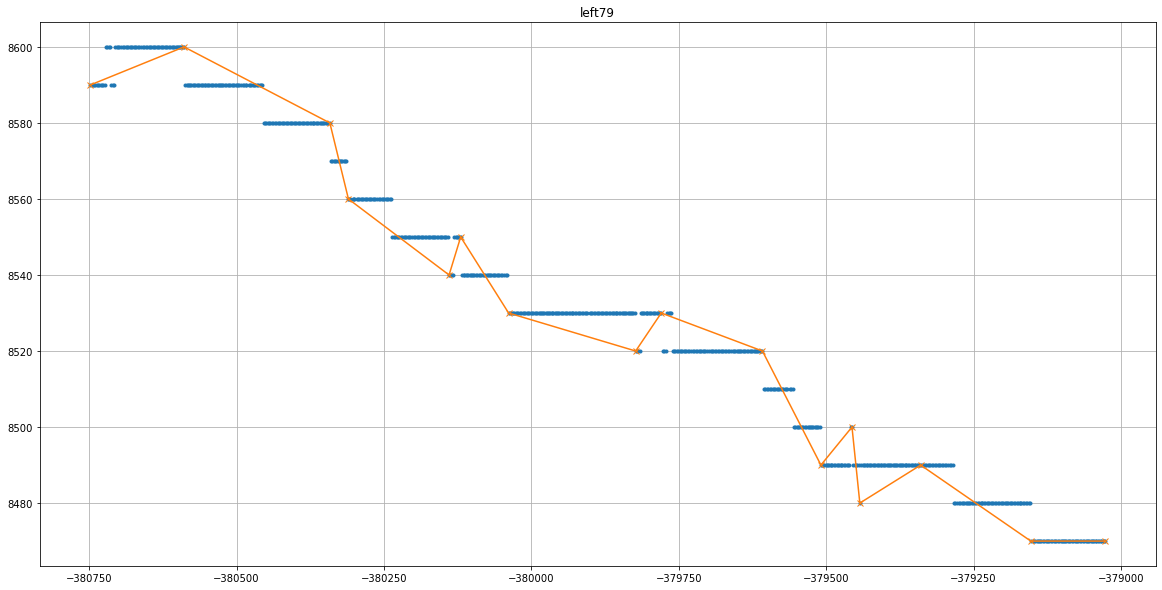

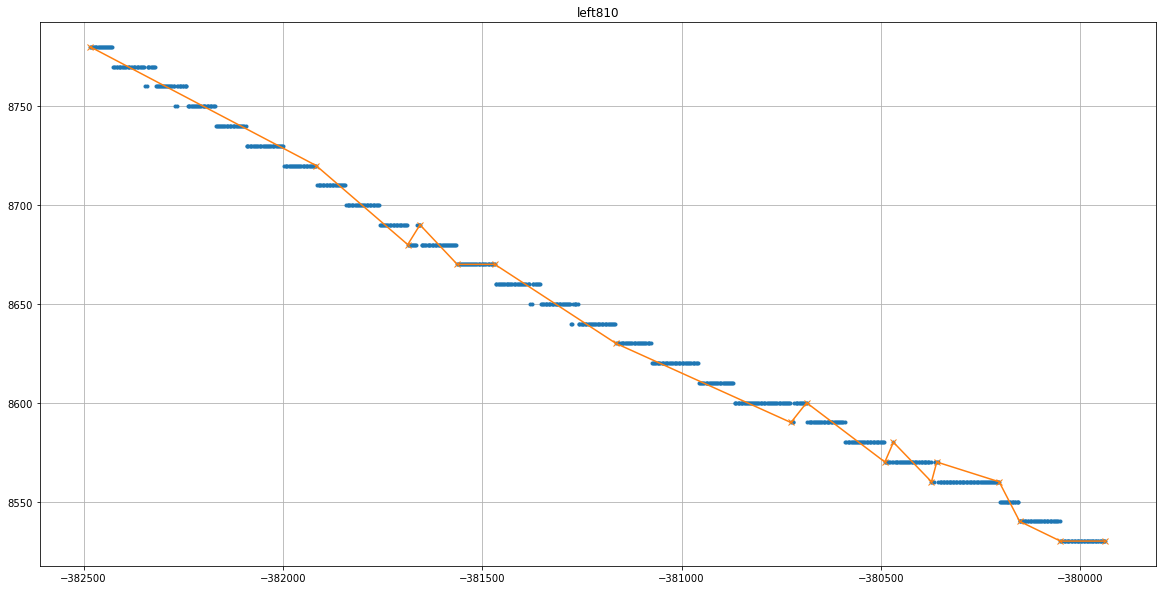

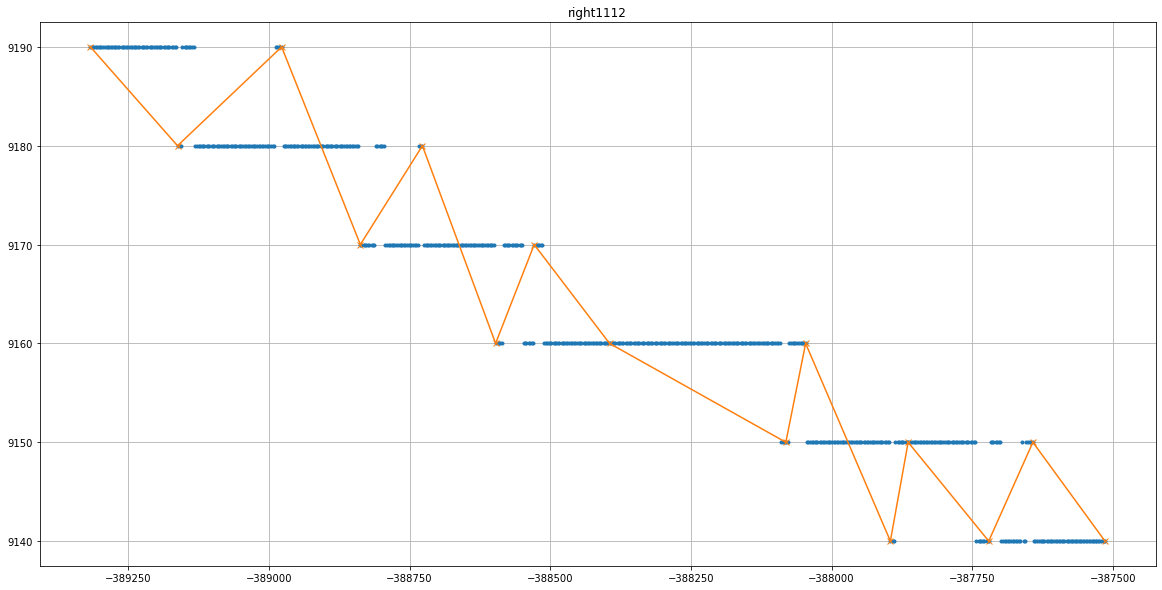

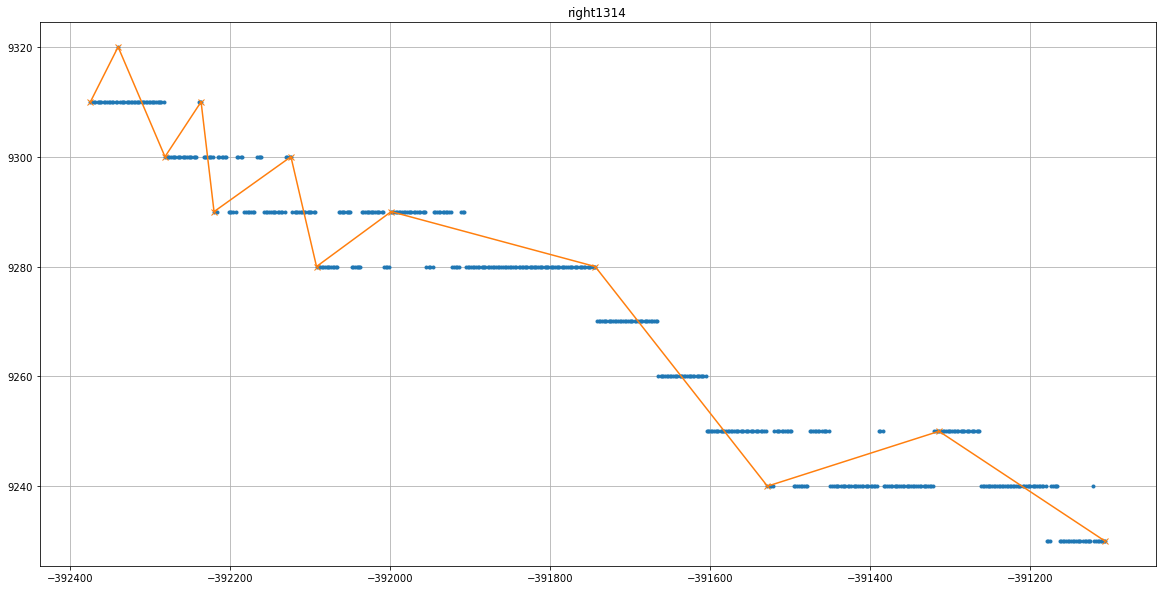

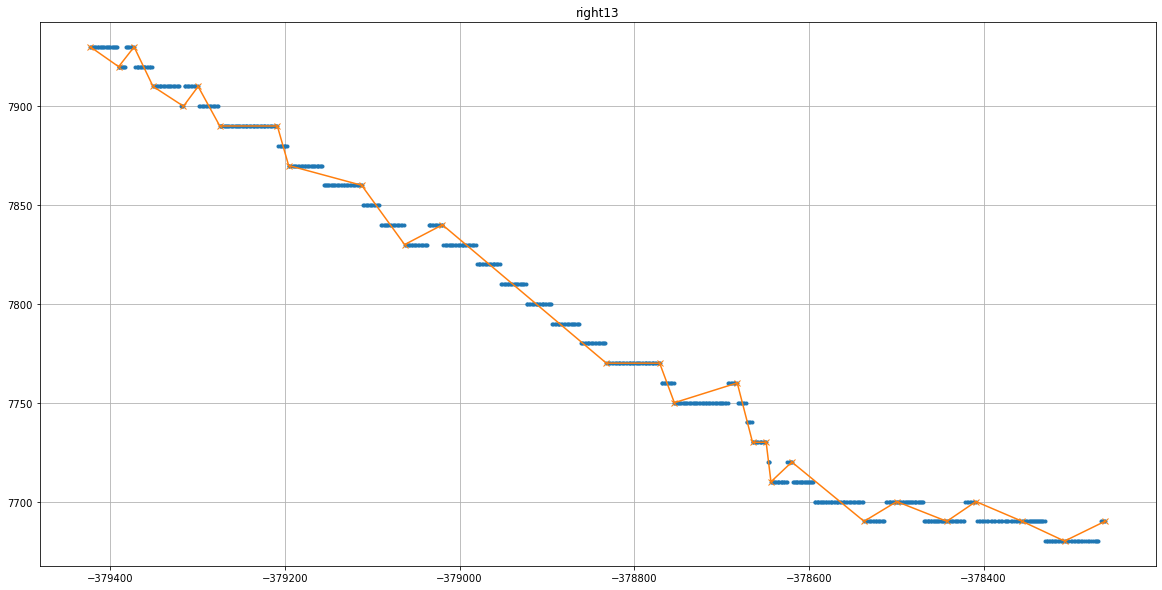

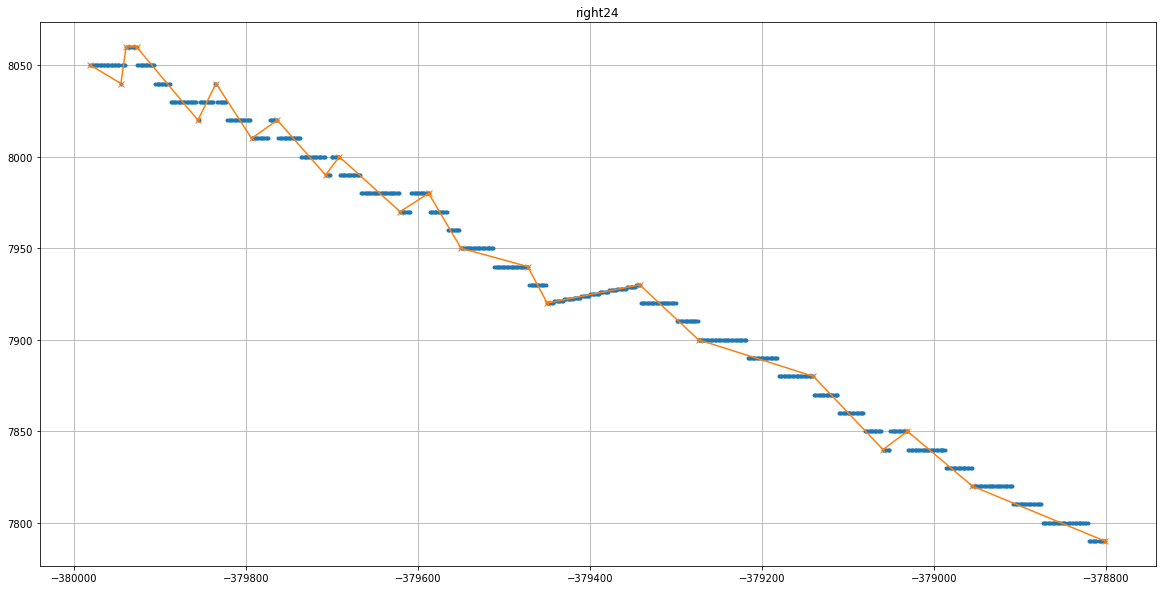

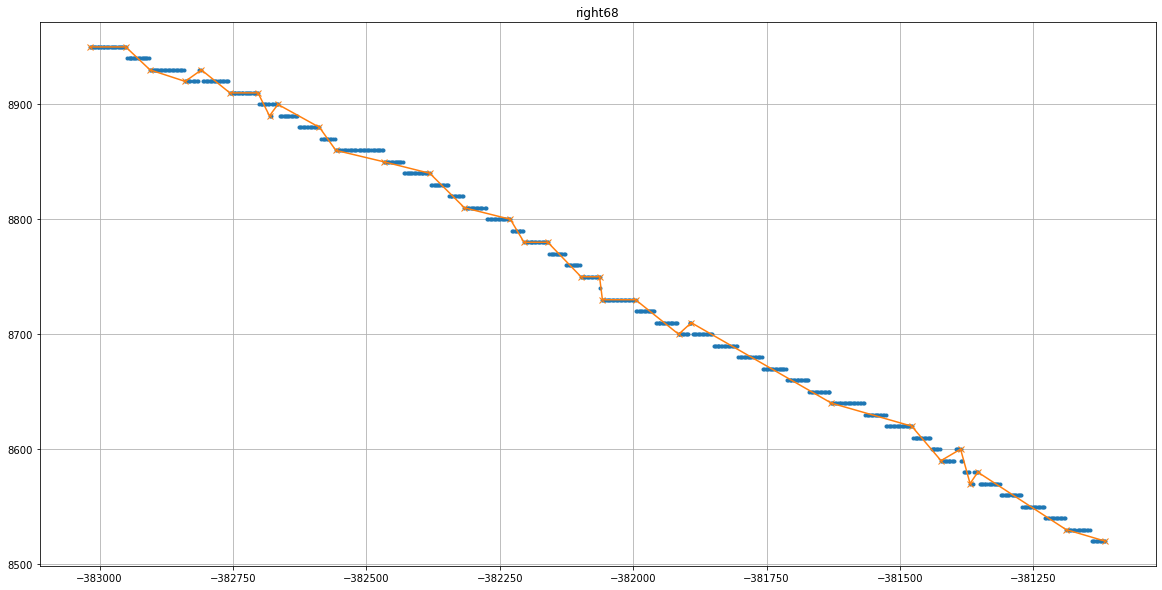

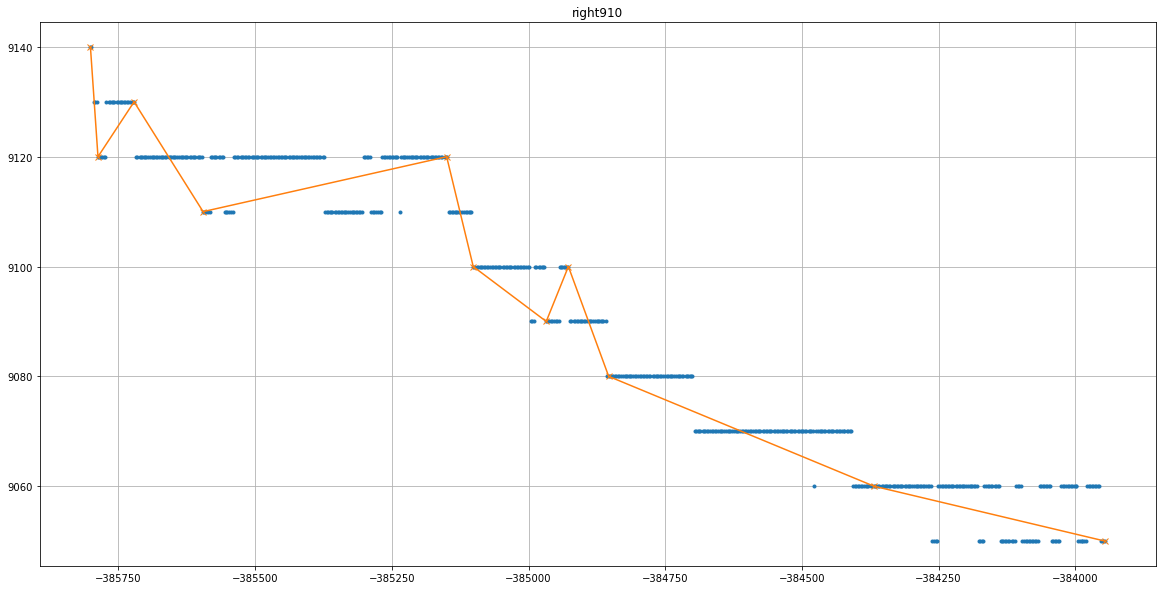

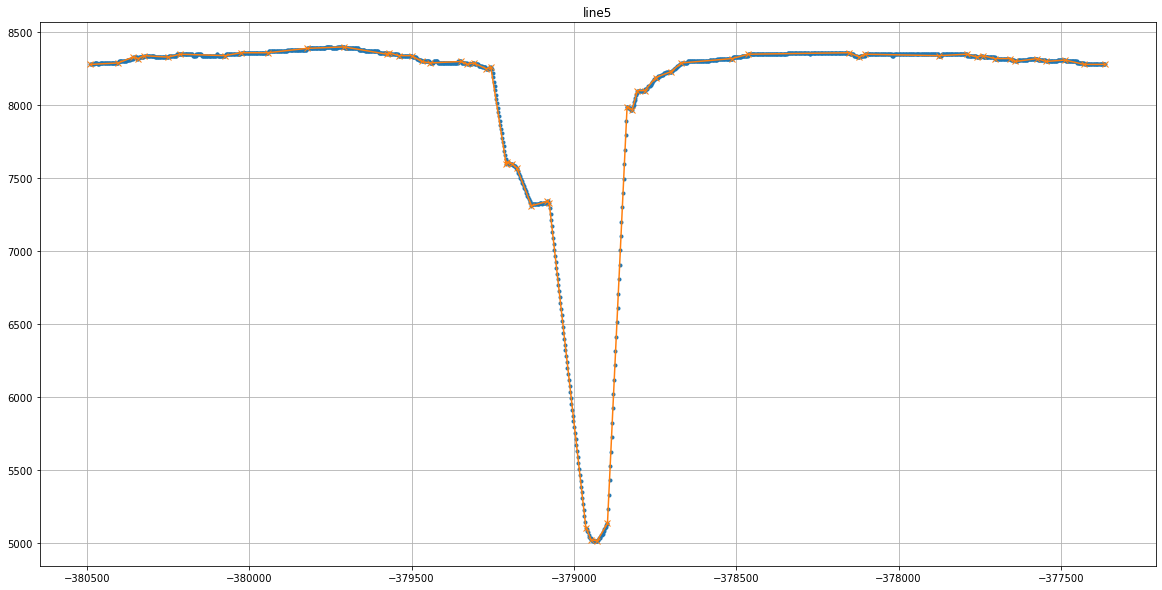

In [89]:
for line_name in ll.keys():
    plot_rdp(line_name,epsilon=10)

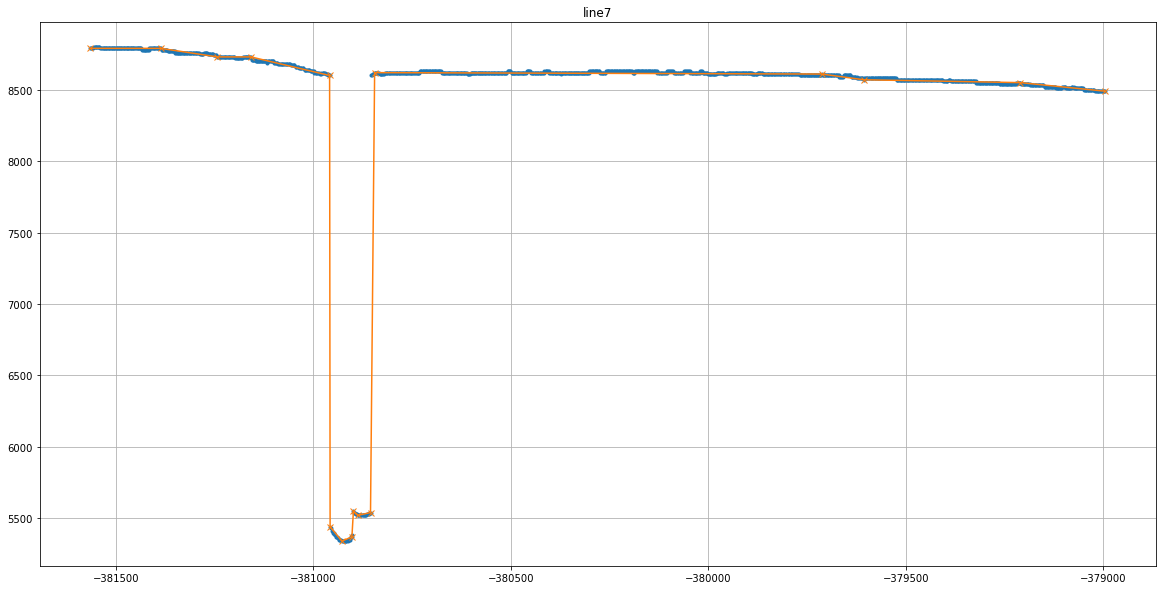

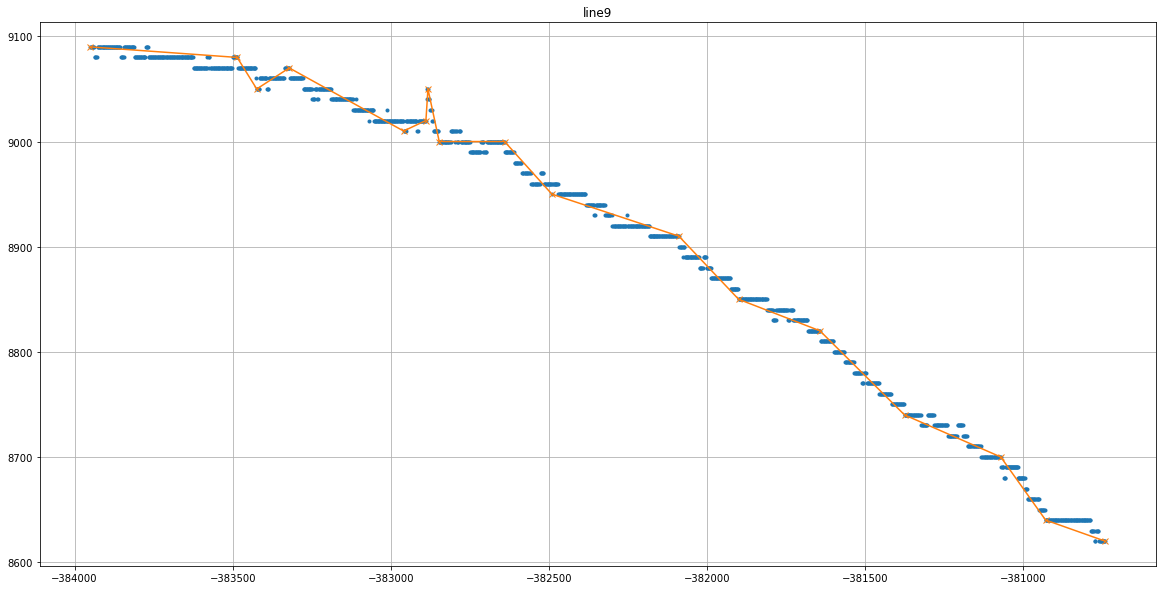

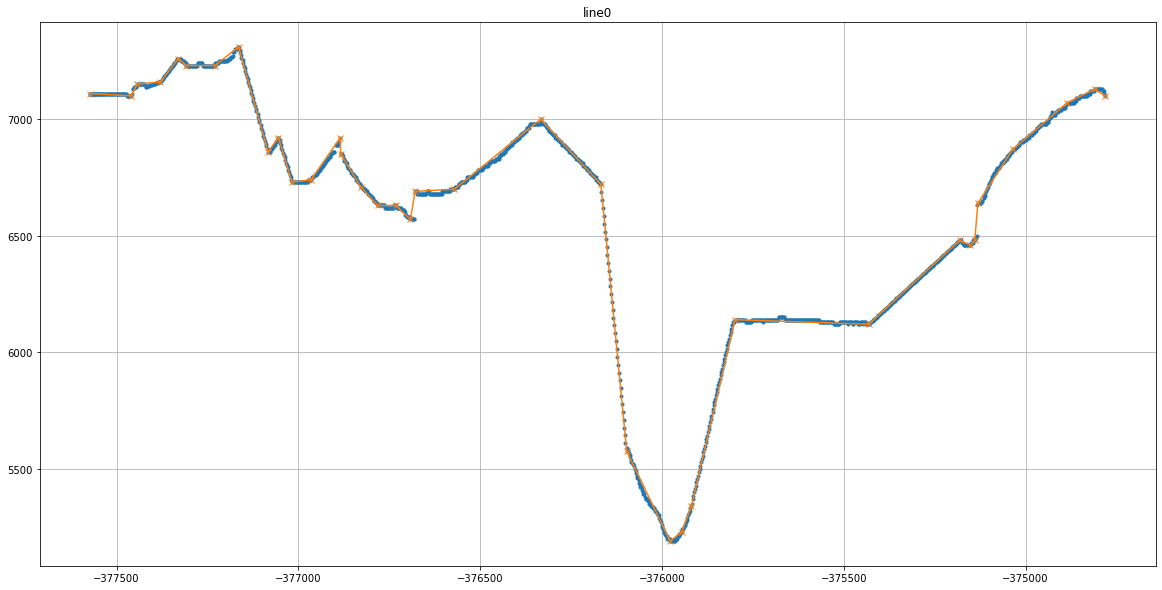

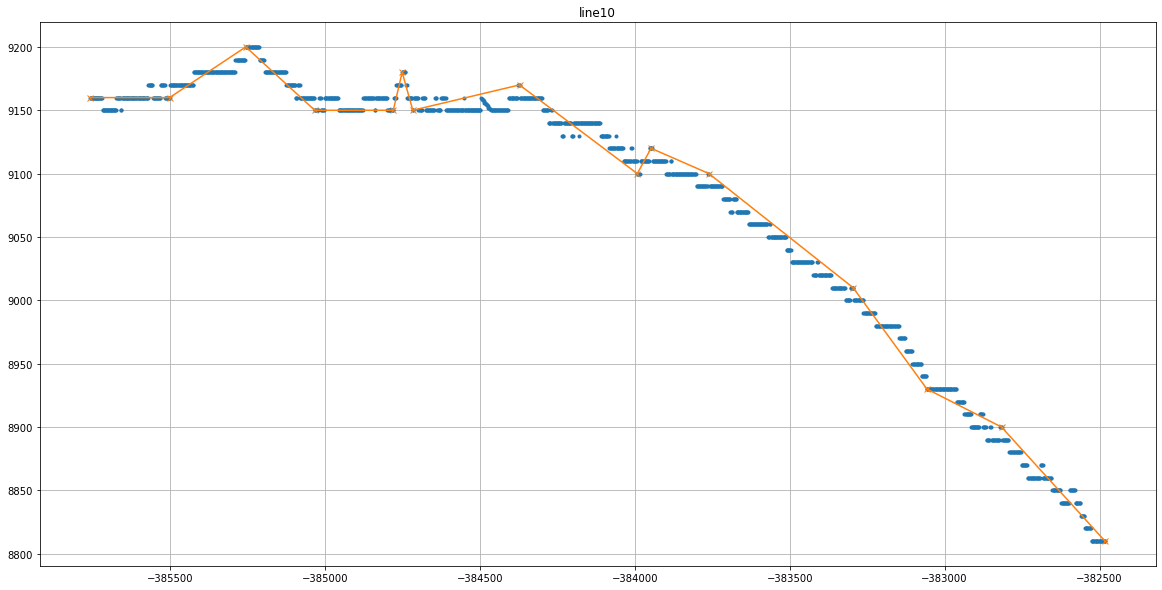

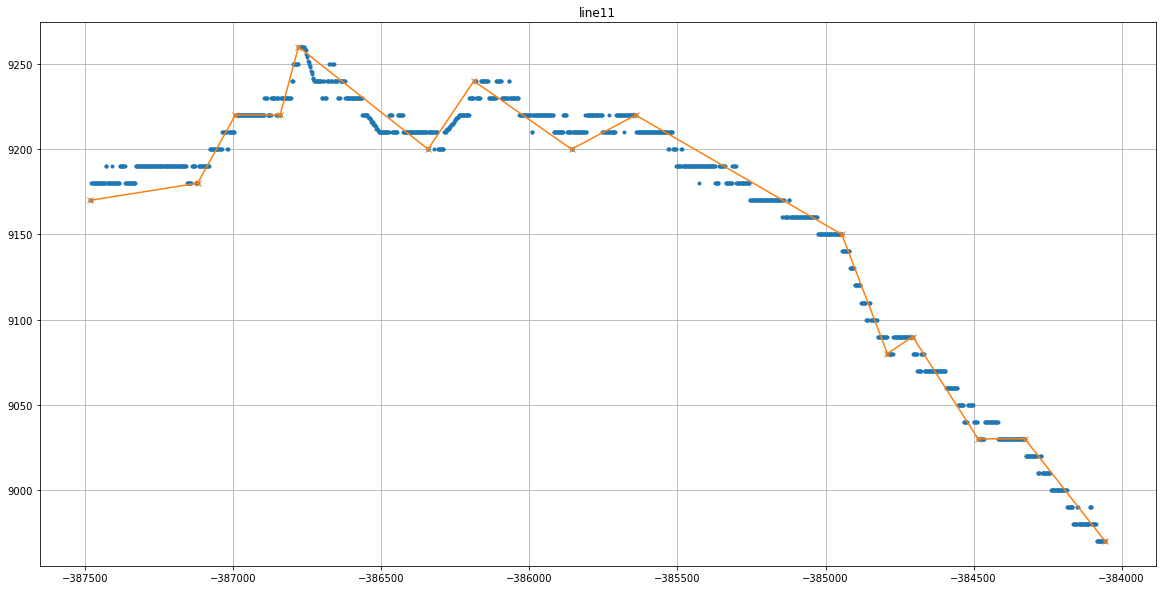

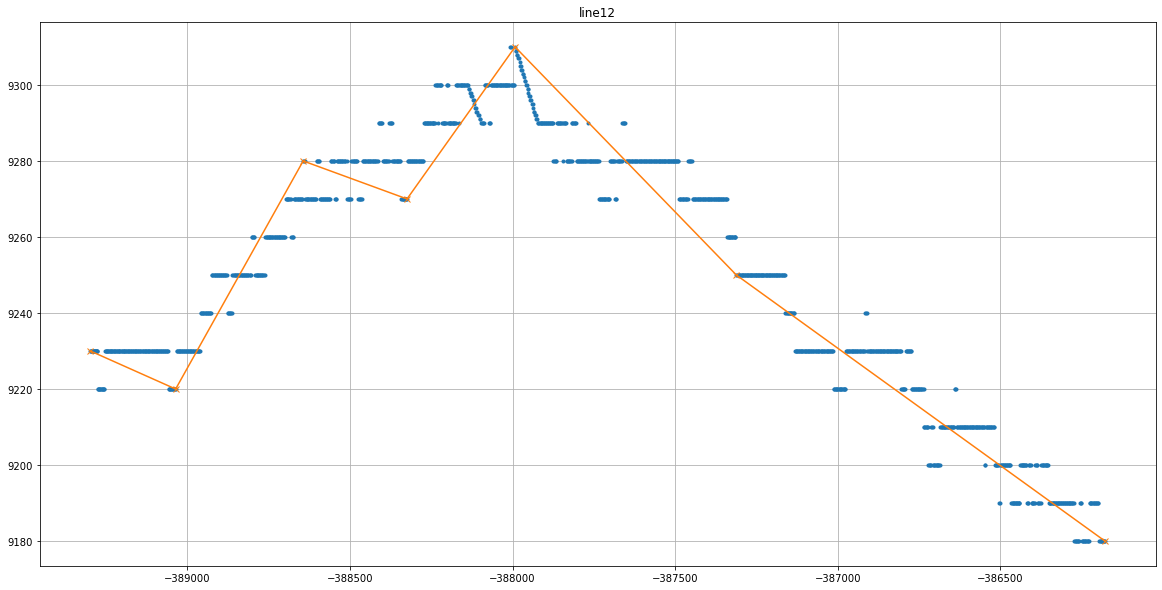

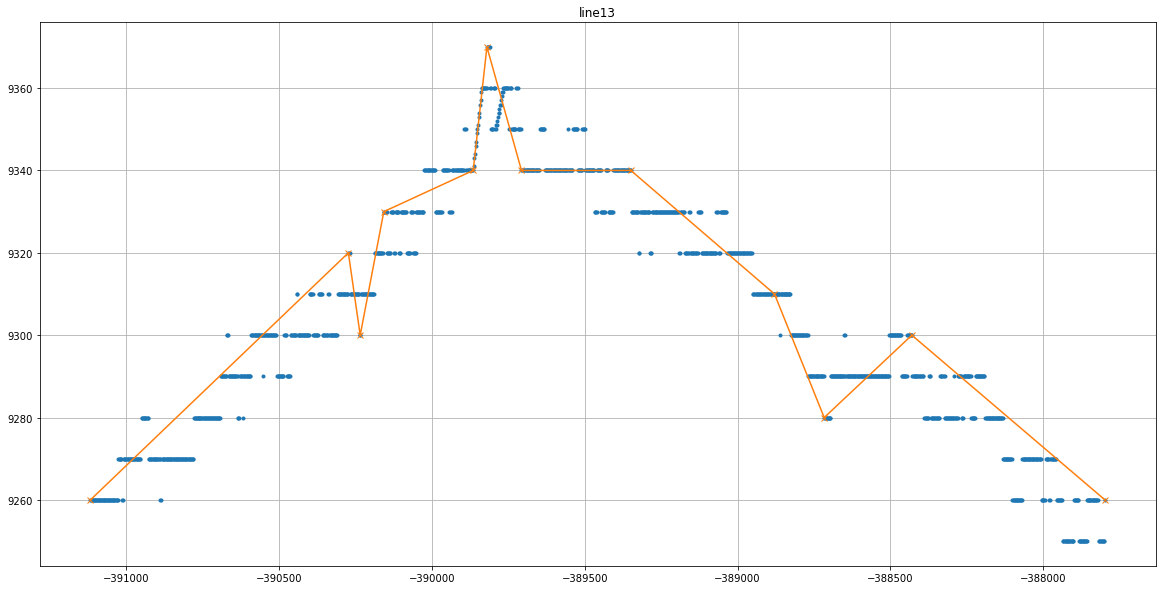

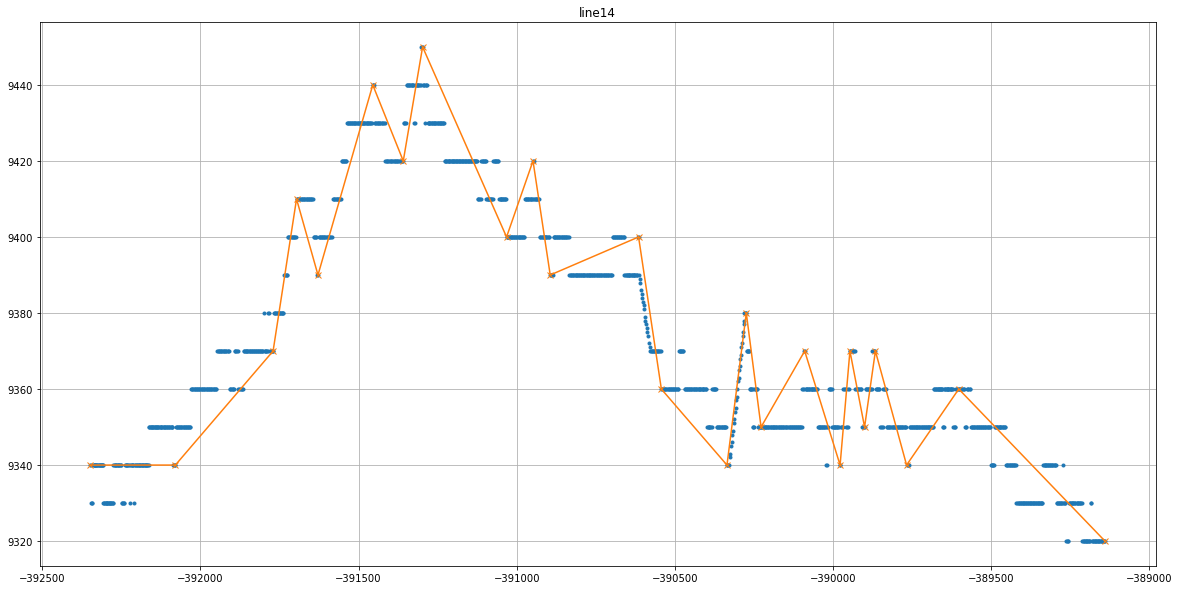

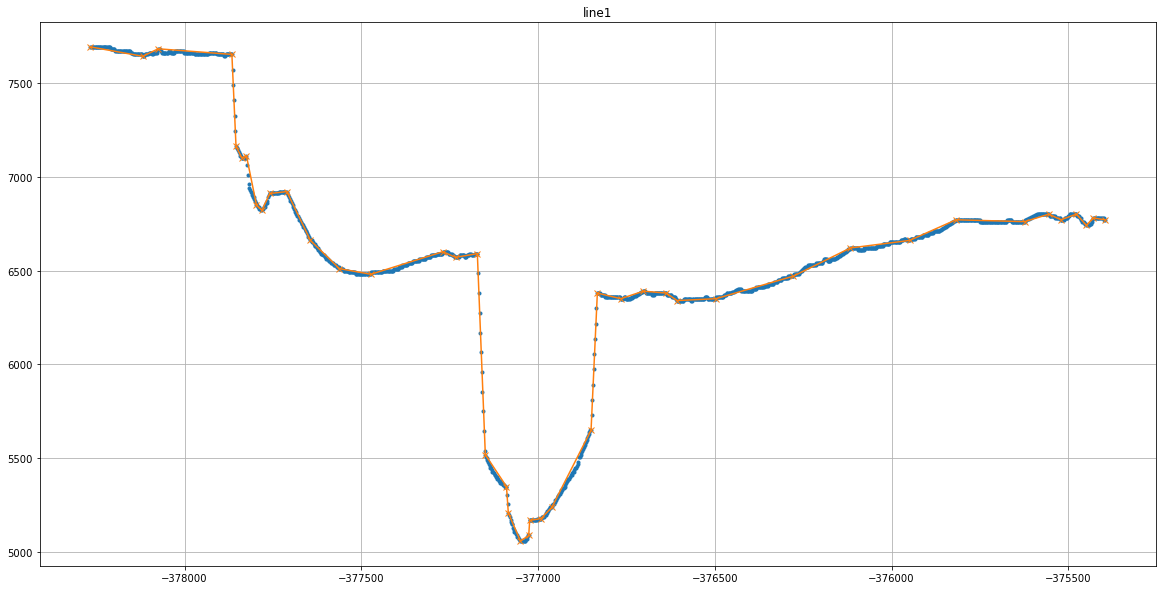

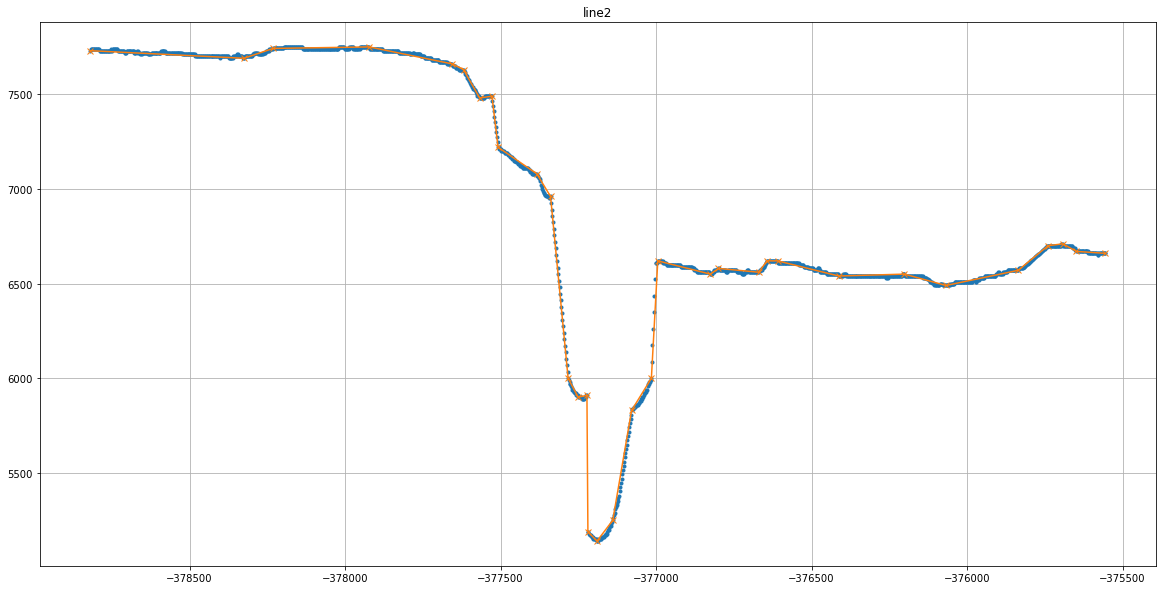

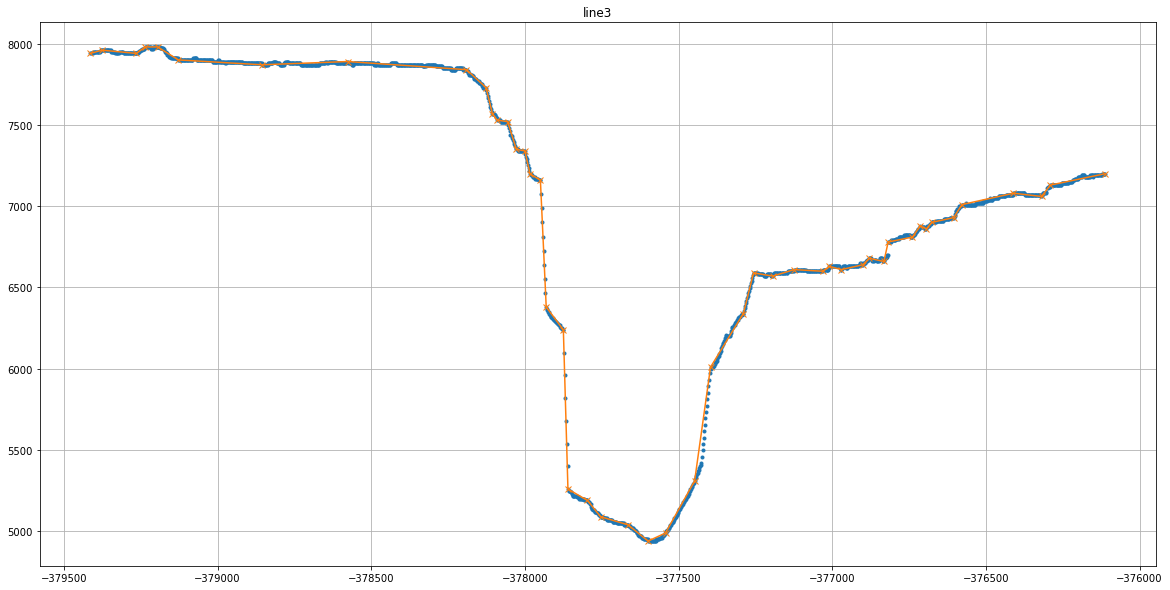

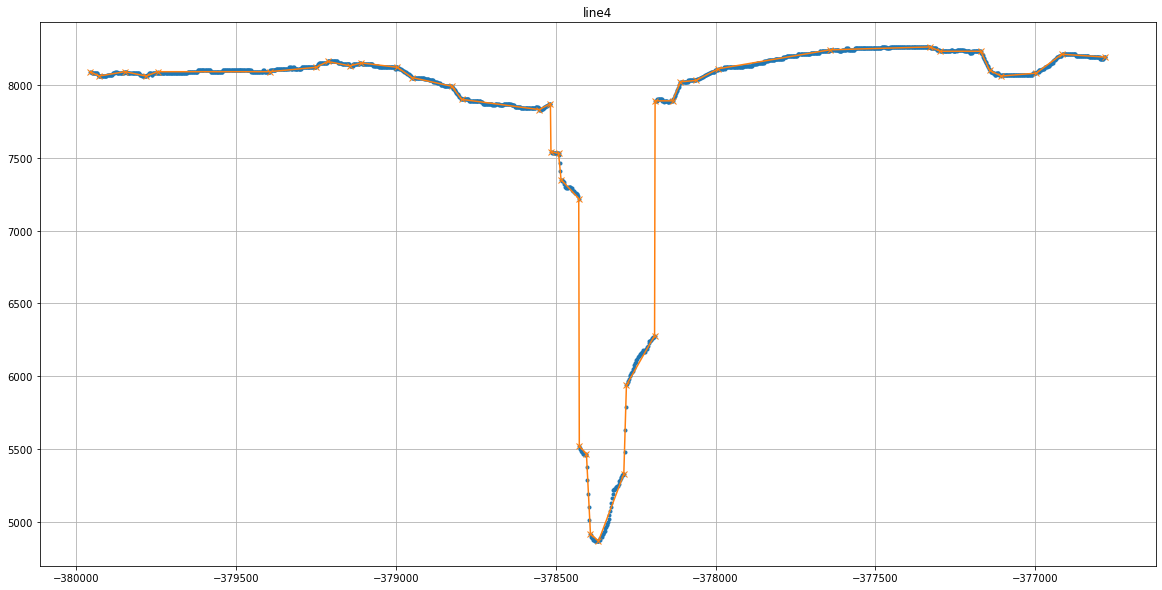

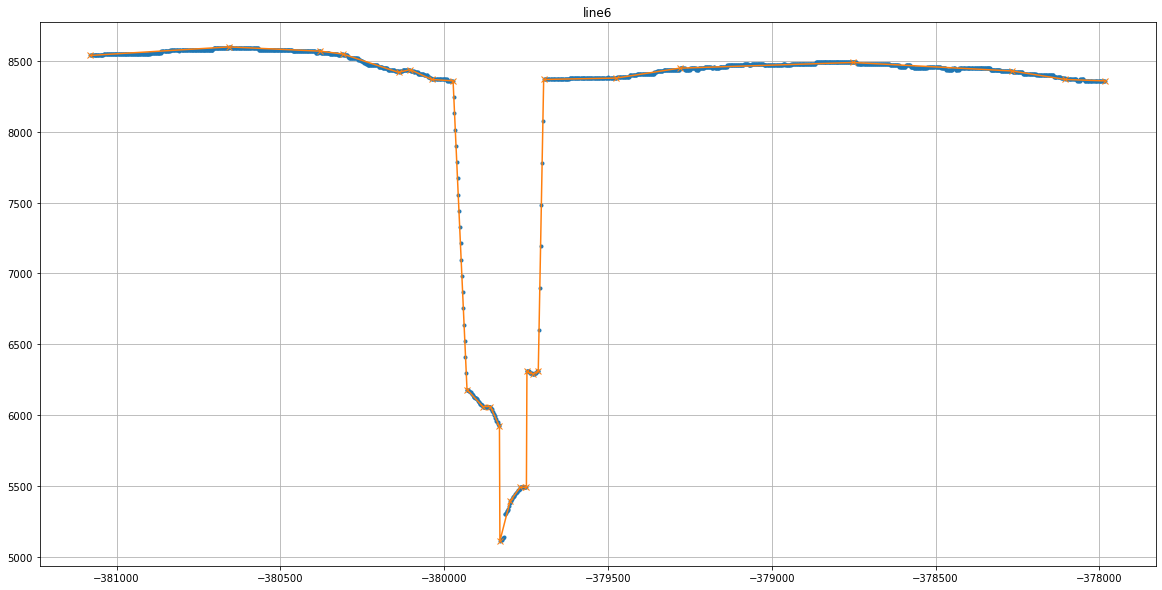

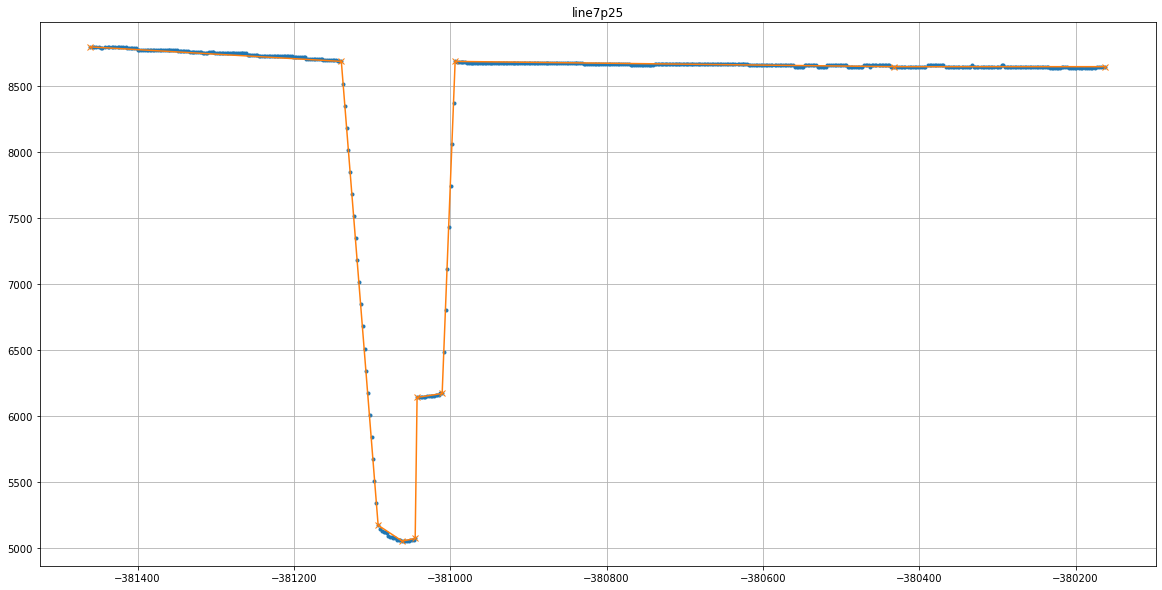

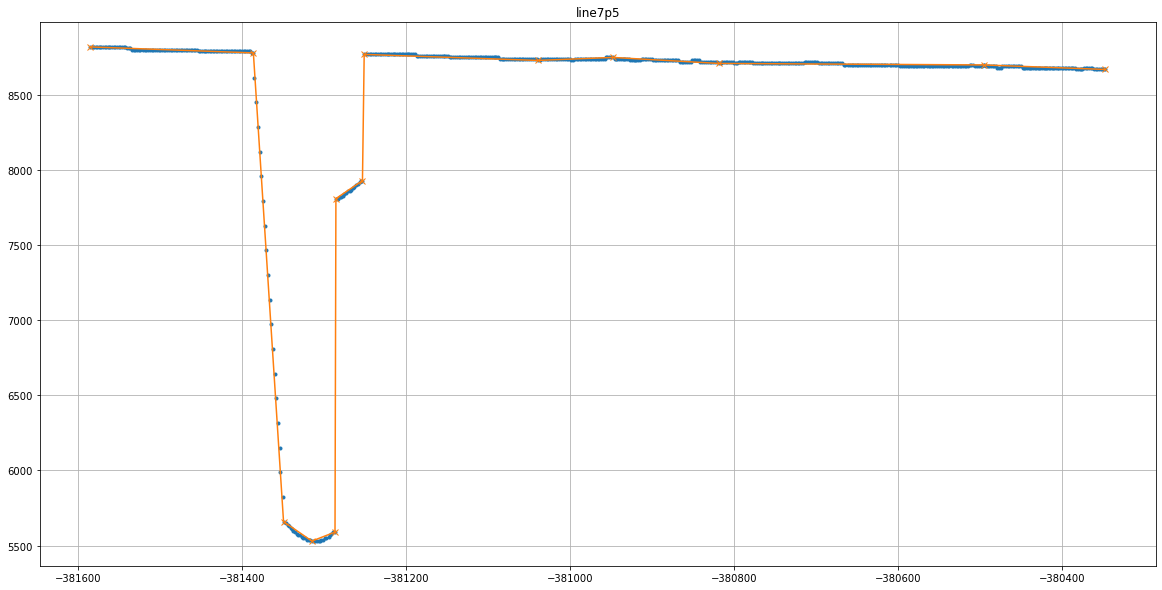

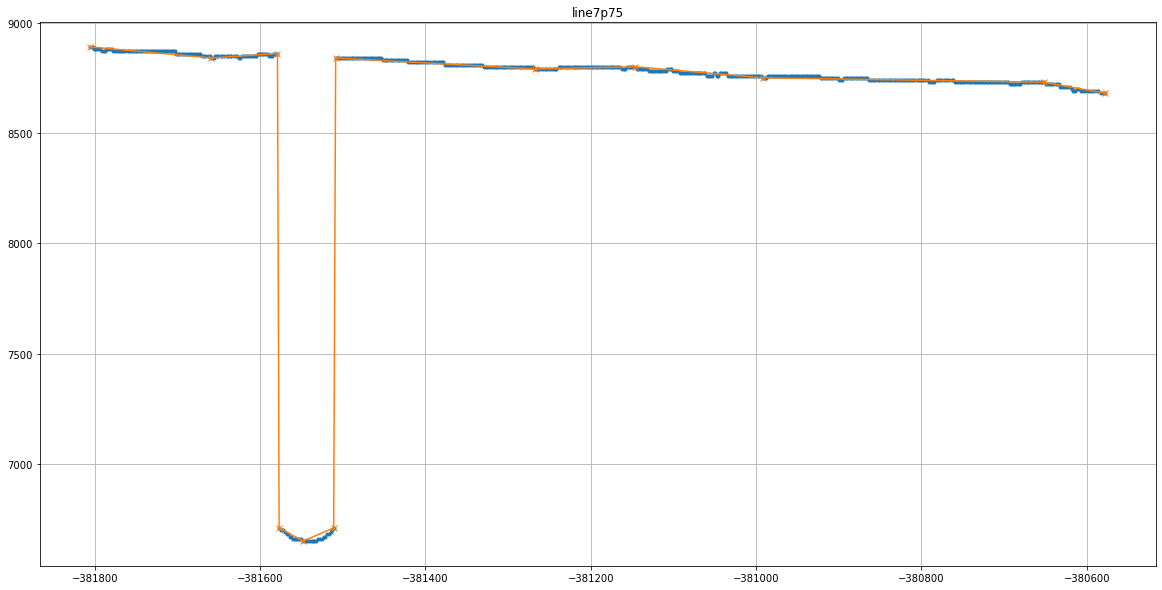

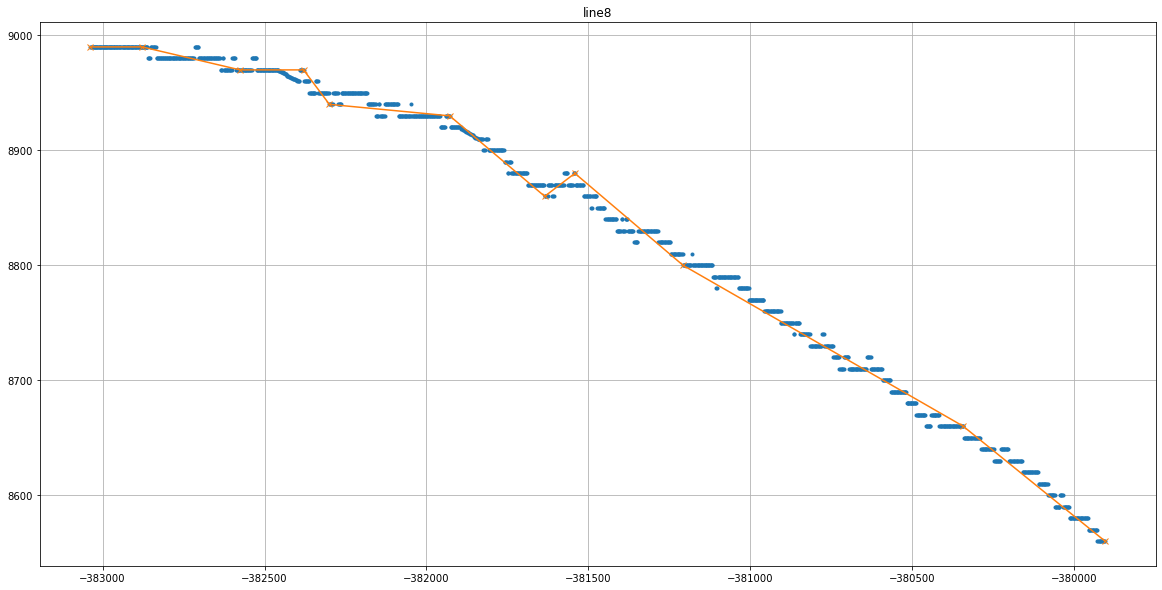

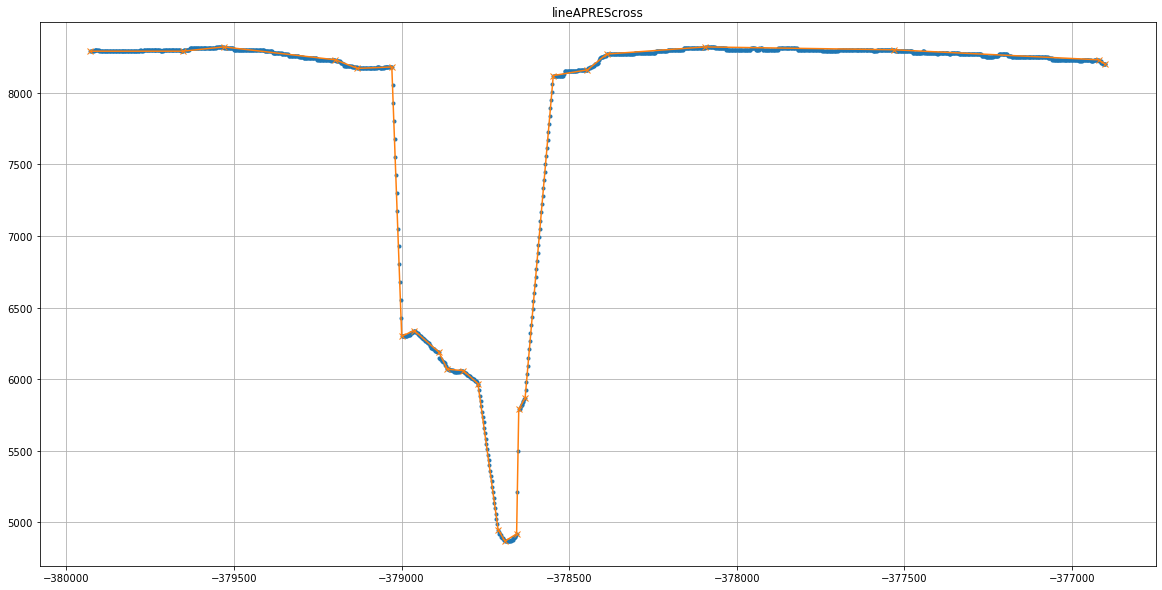

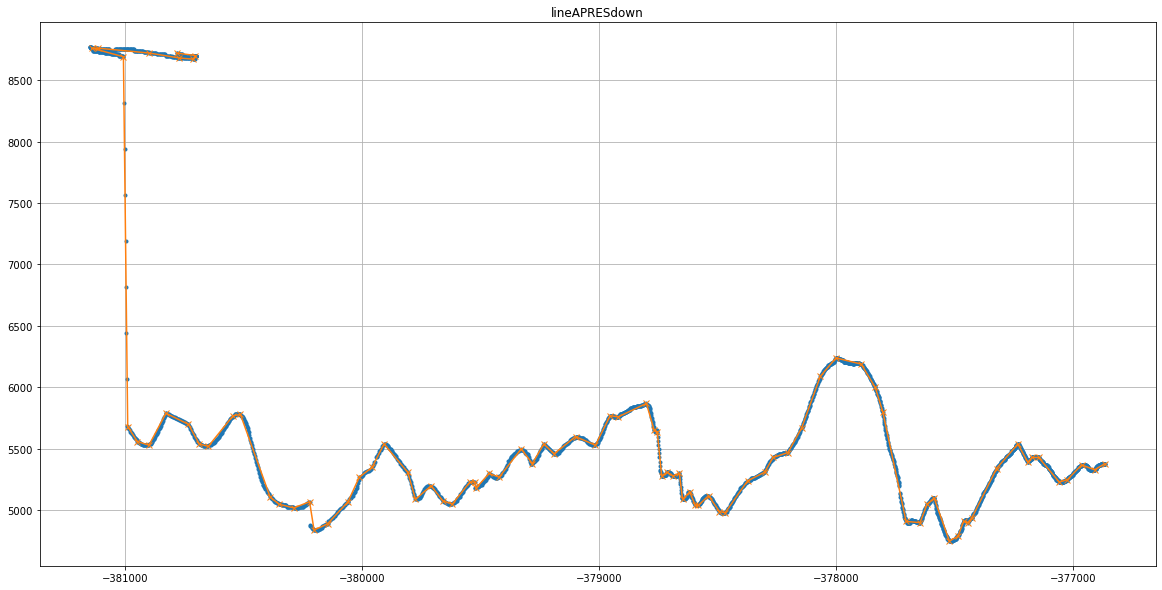

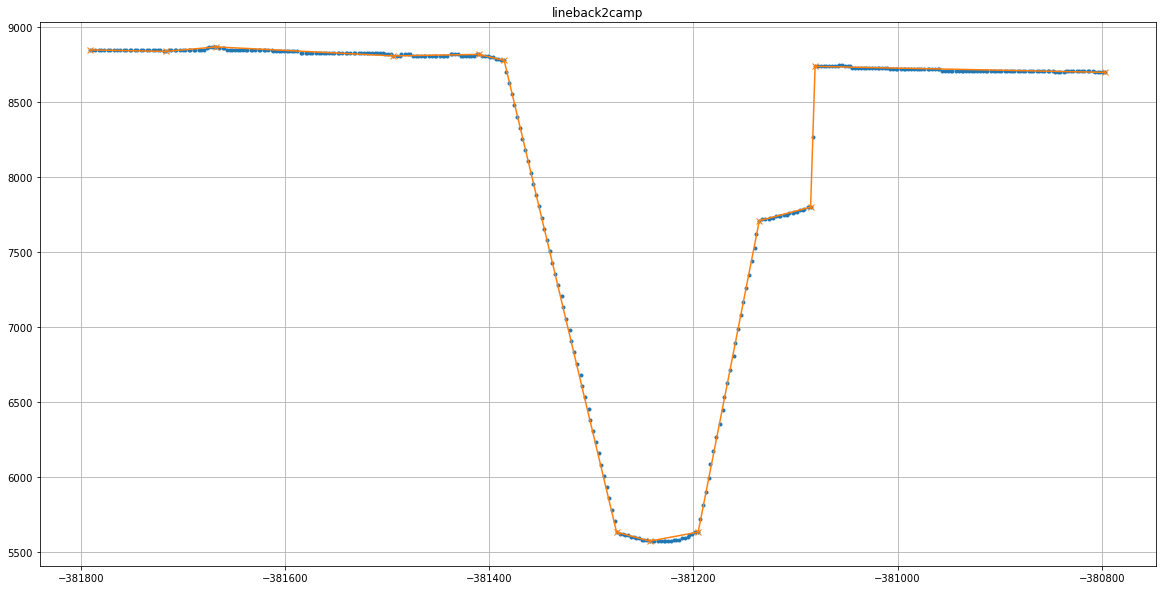

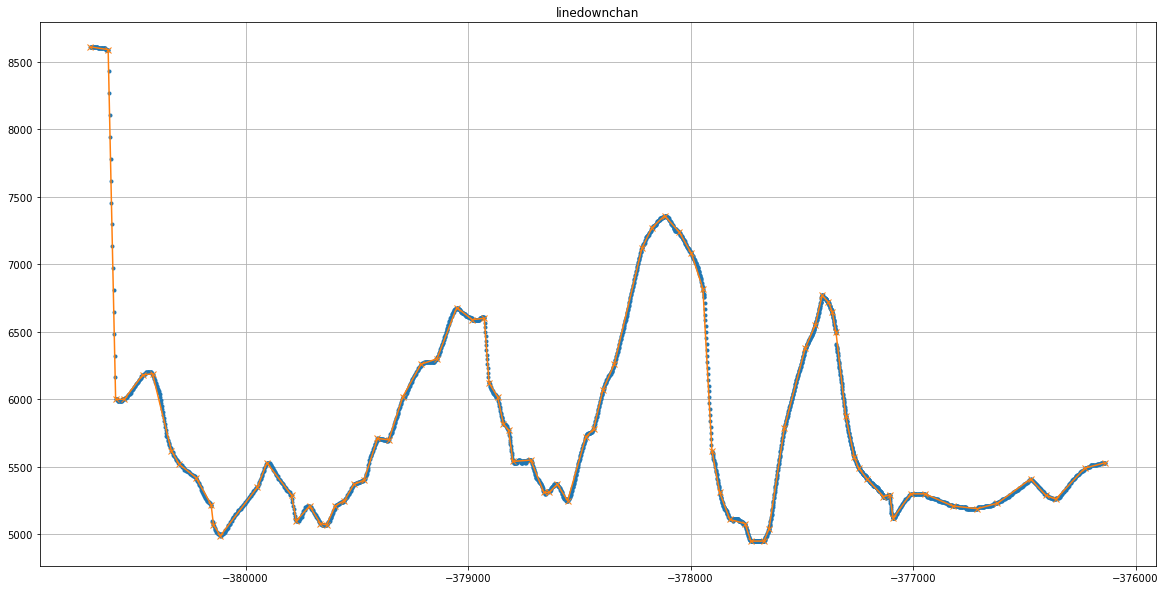

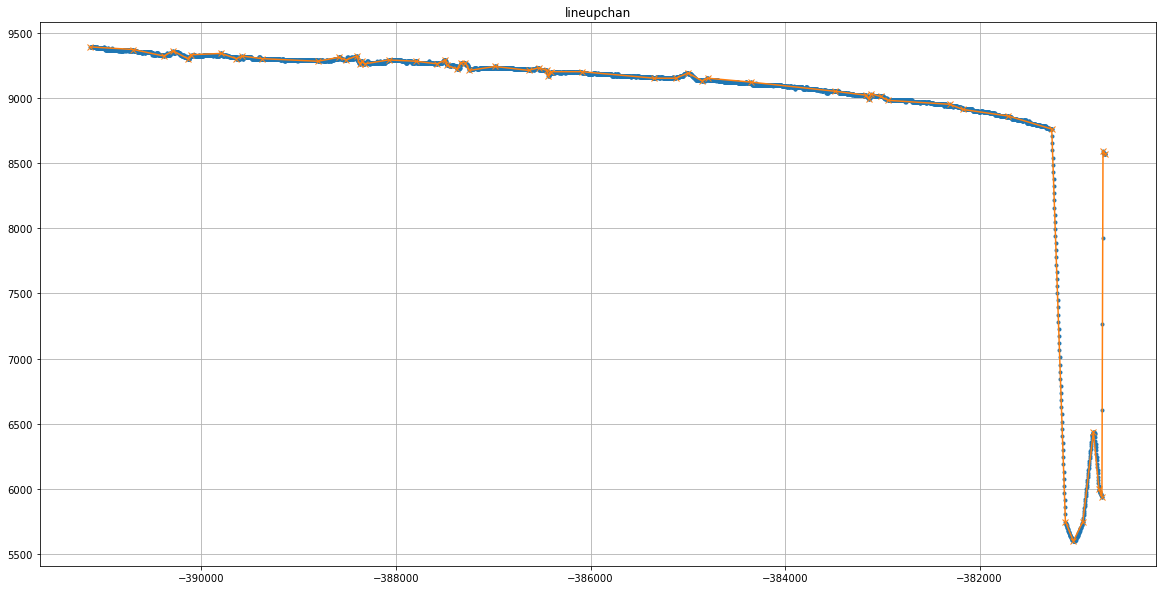

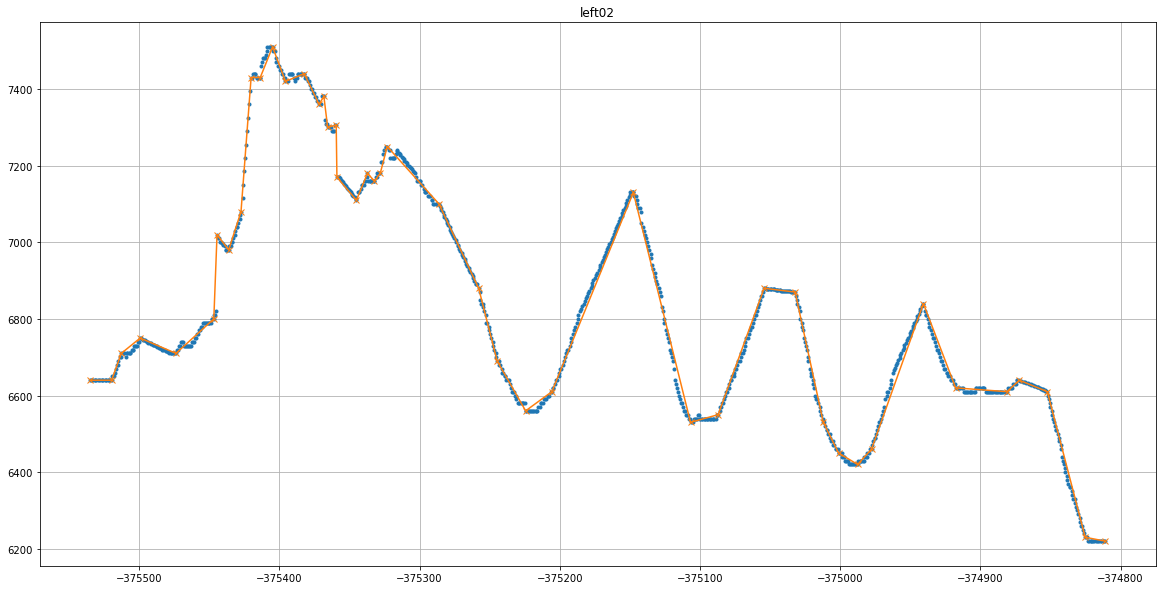

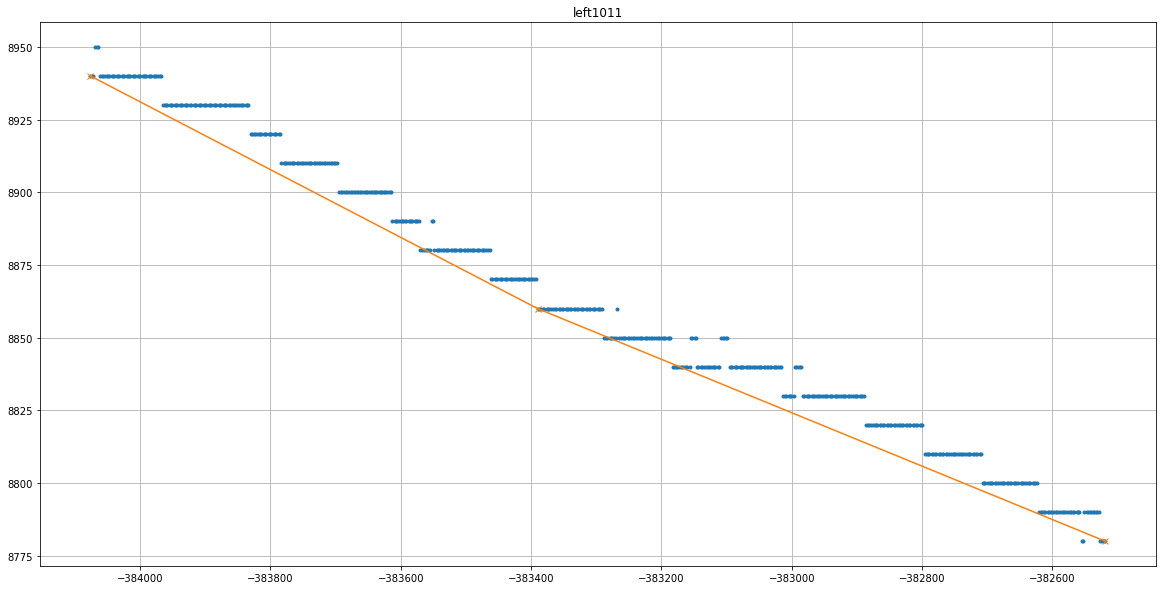

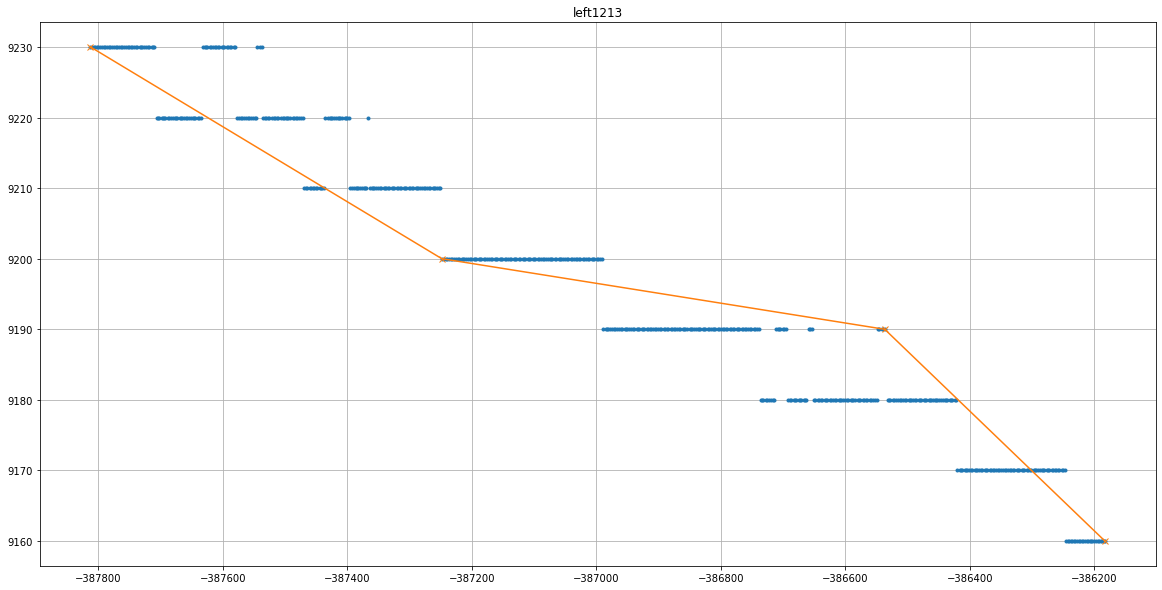

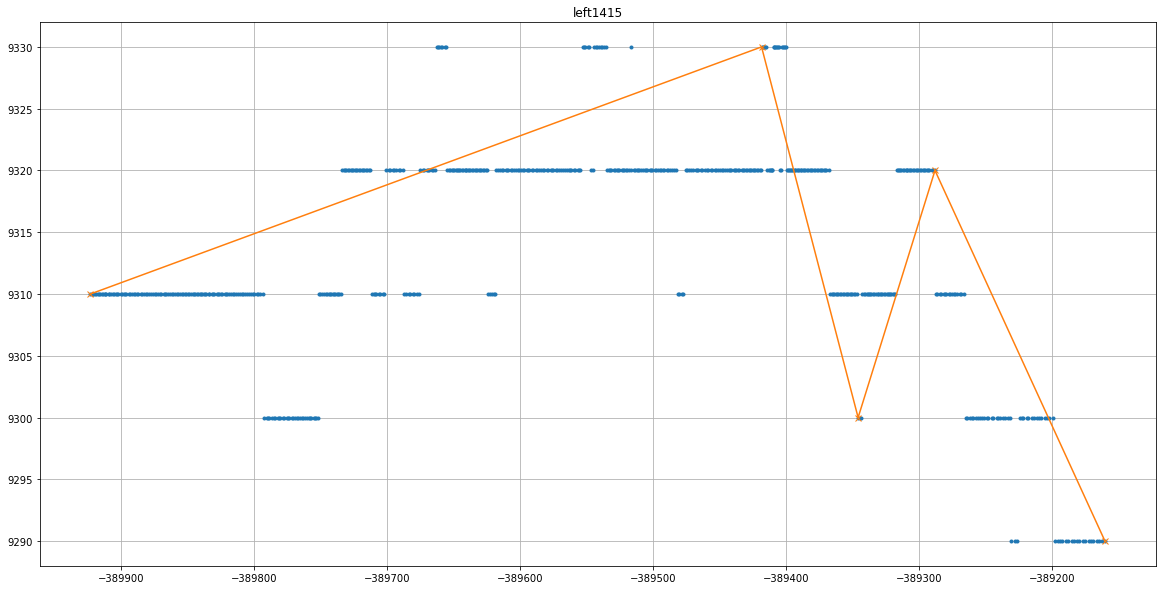

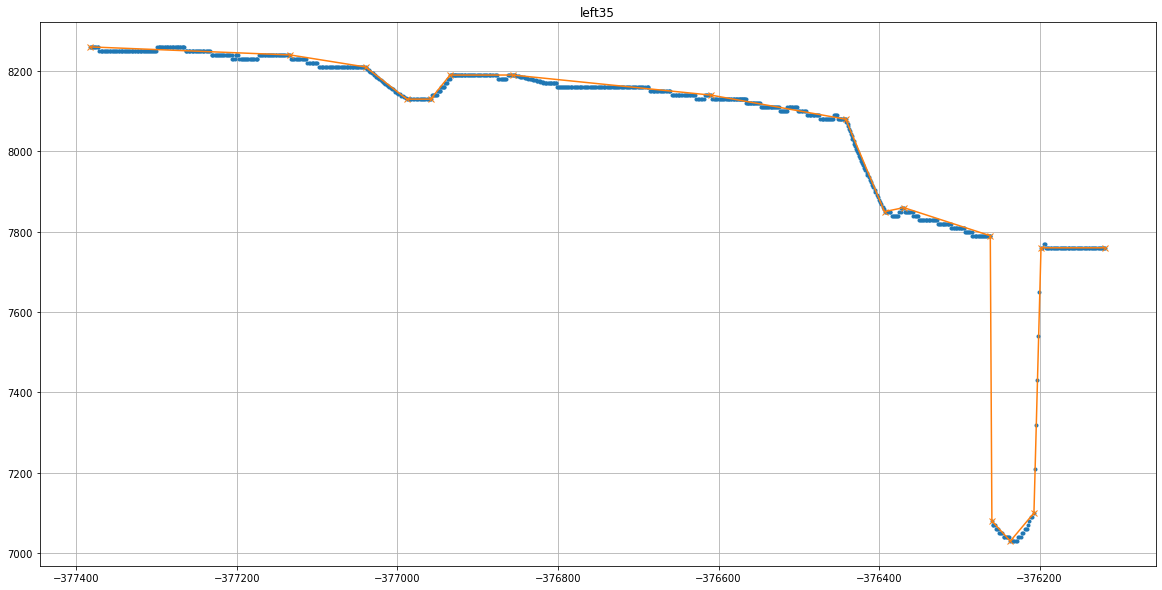

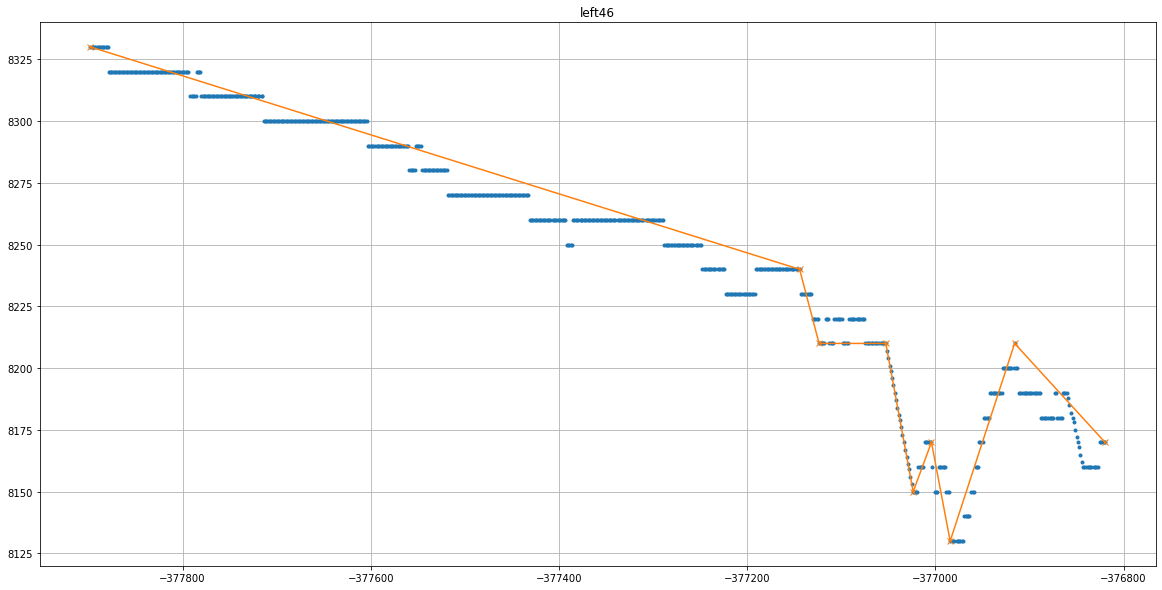

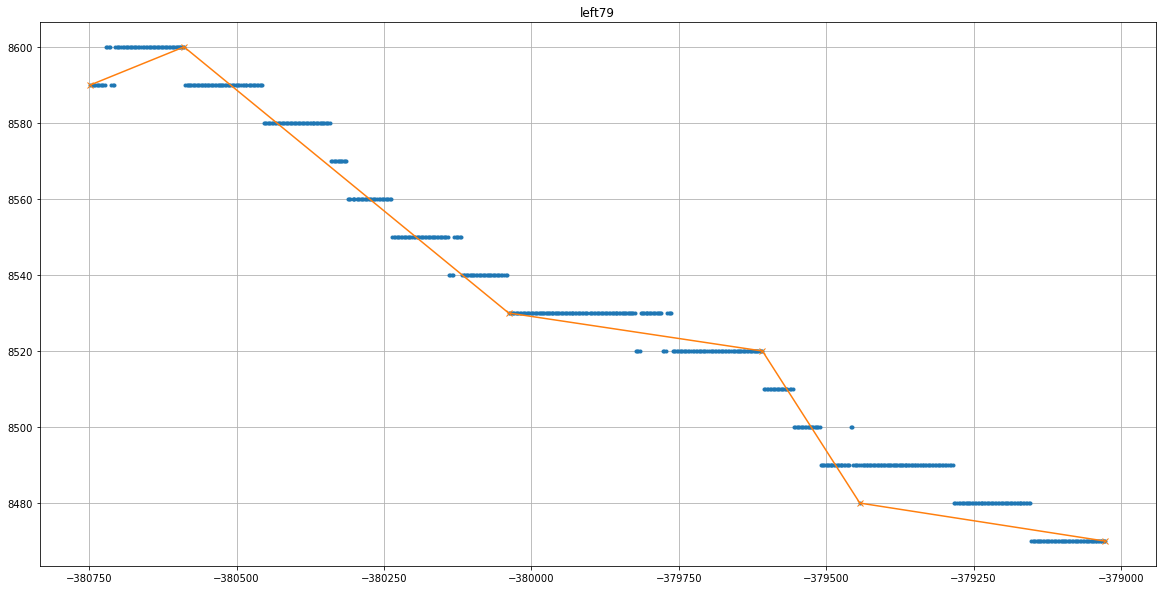

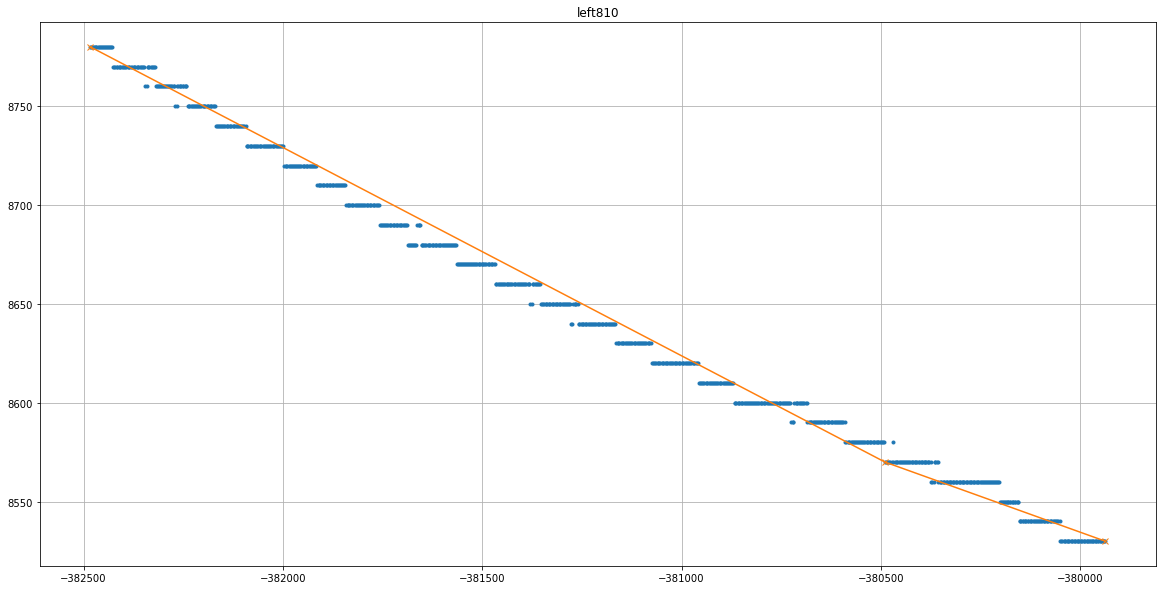

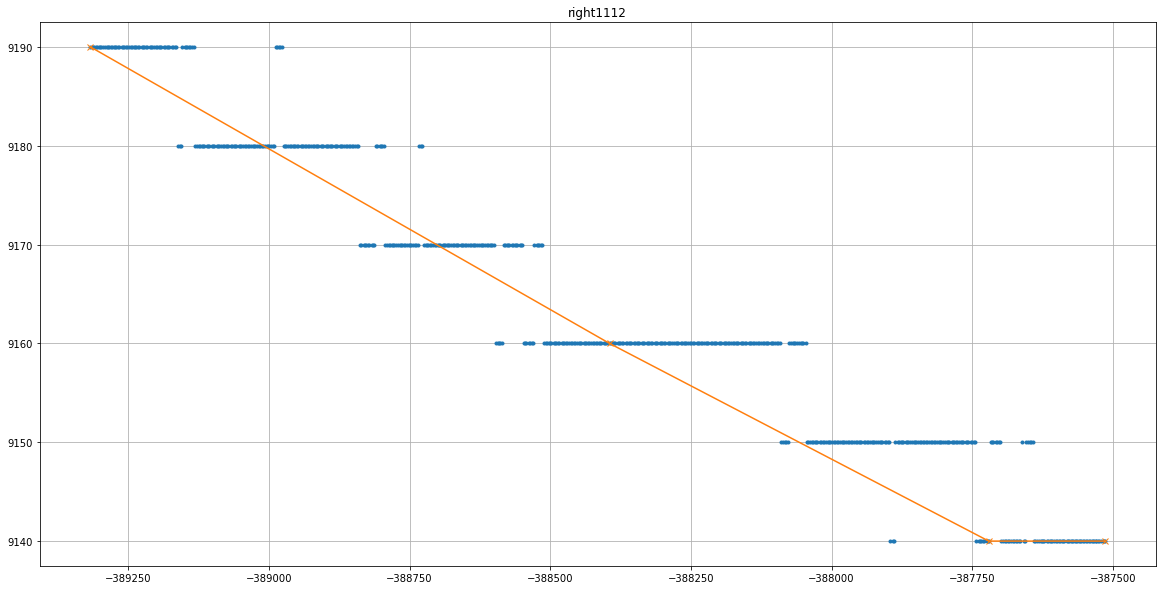

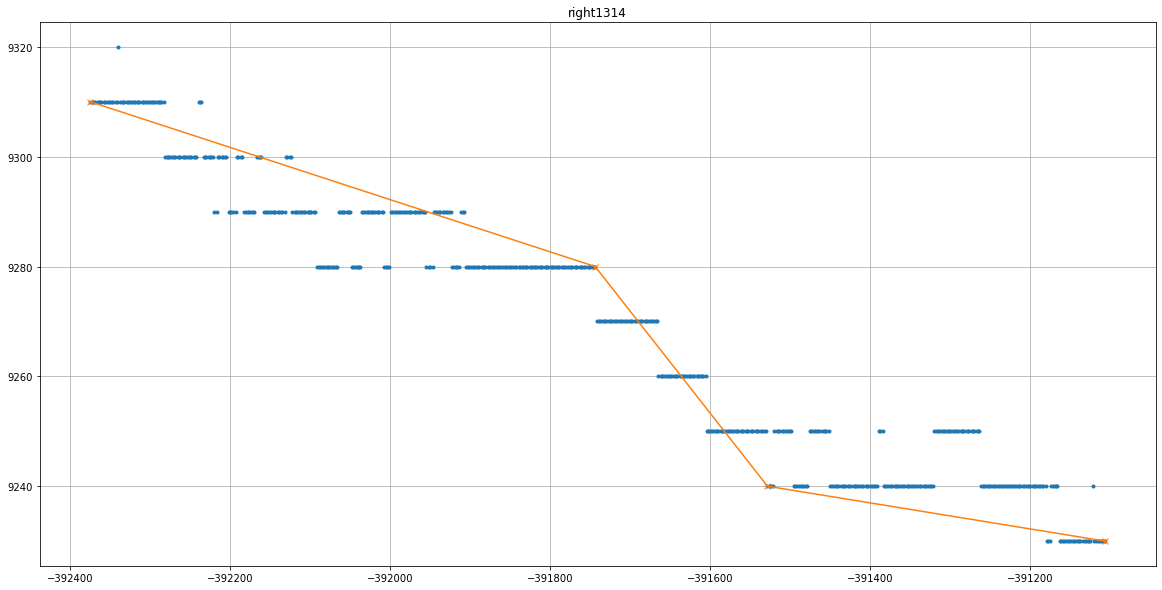

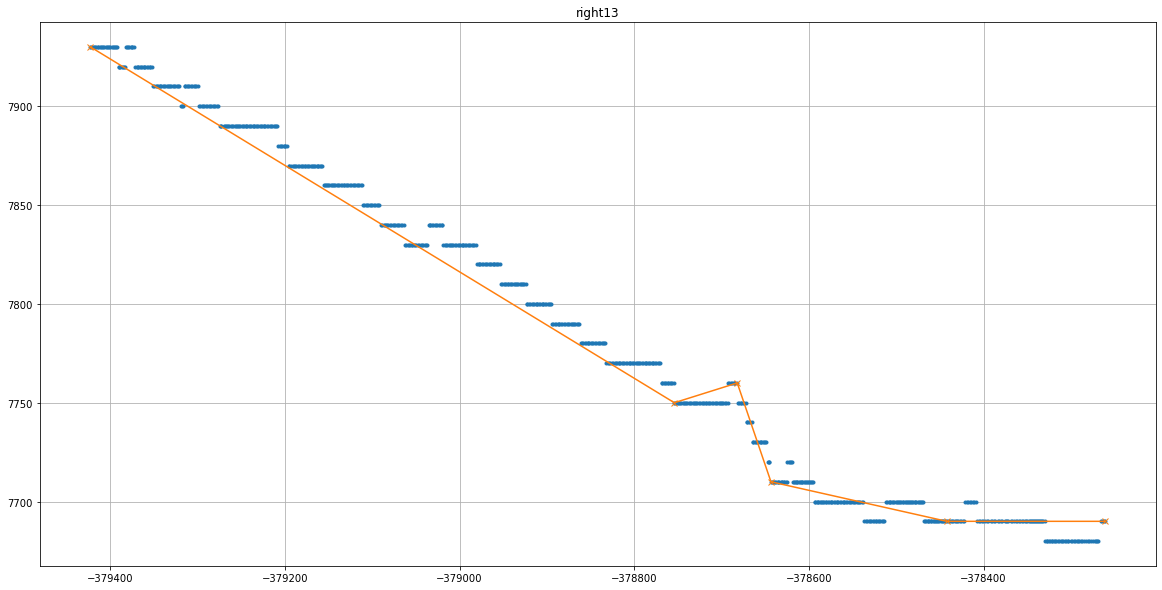

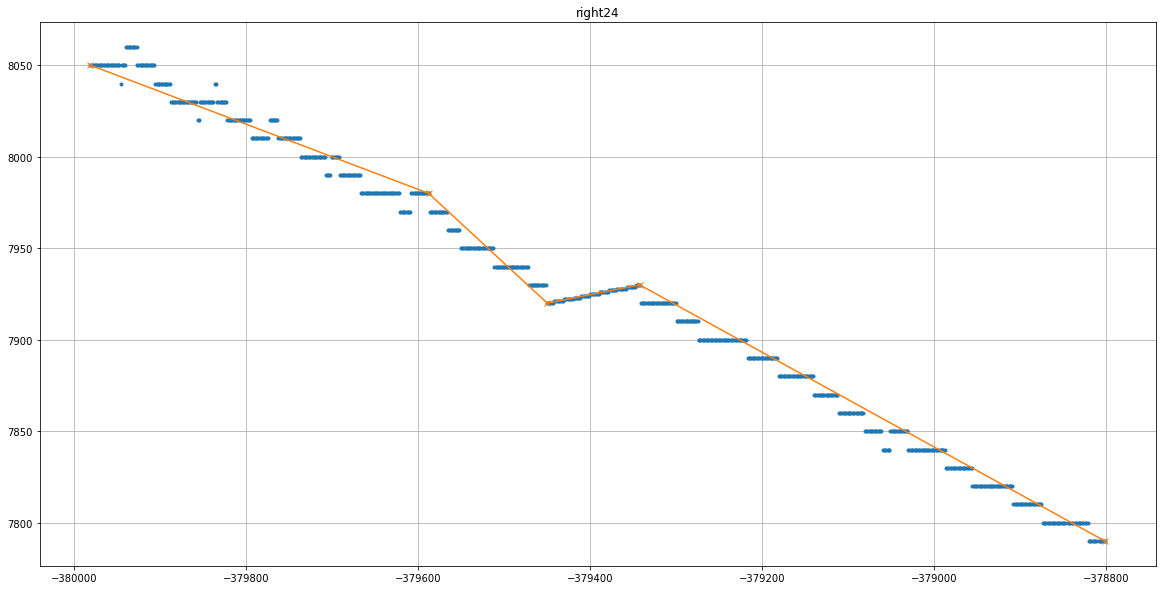

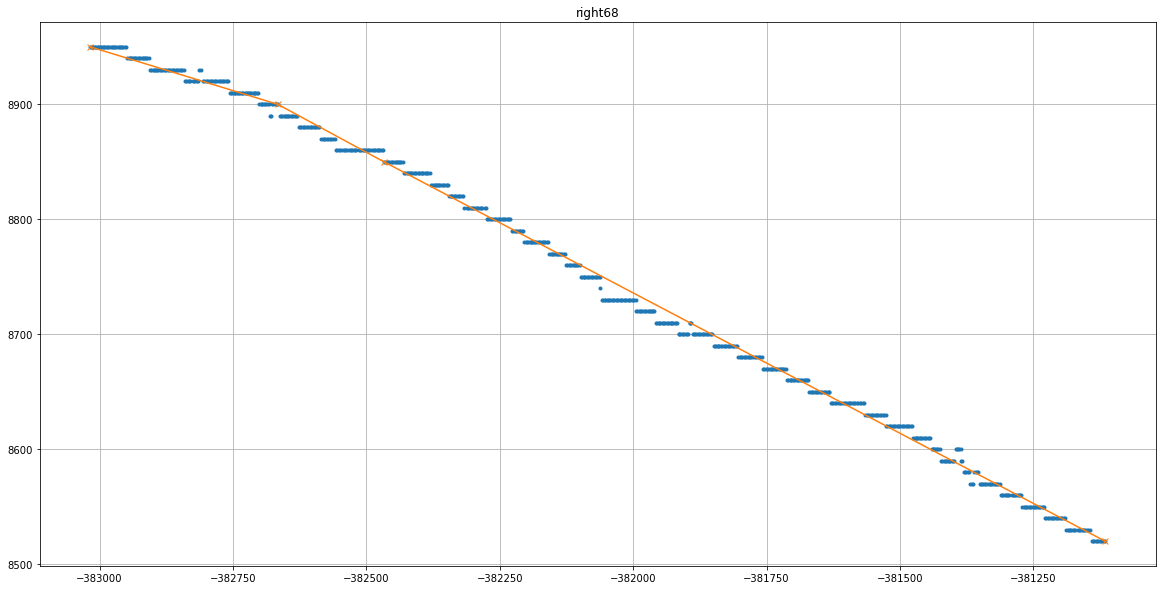

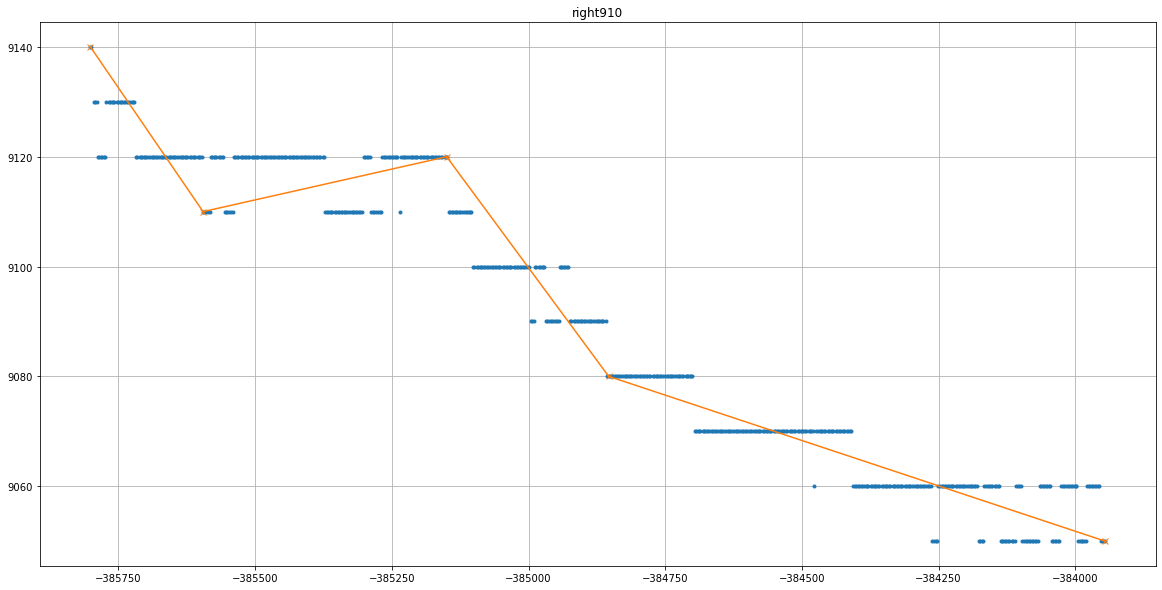

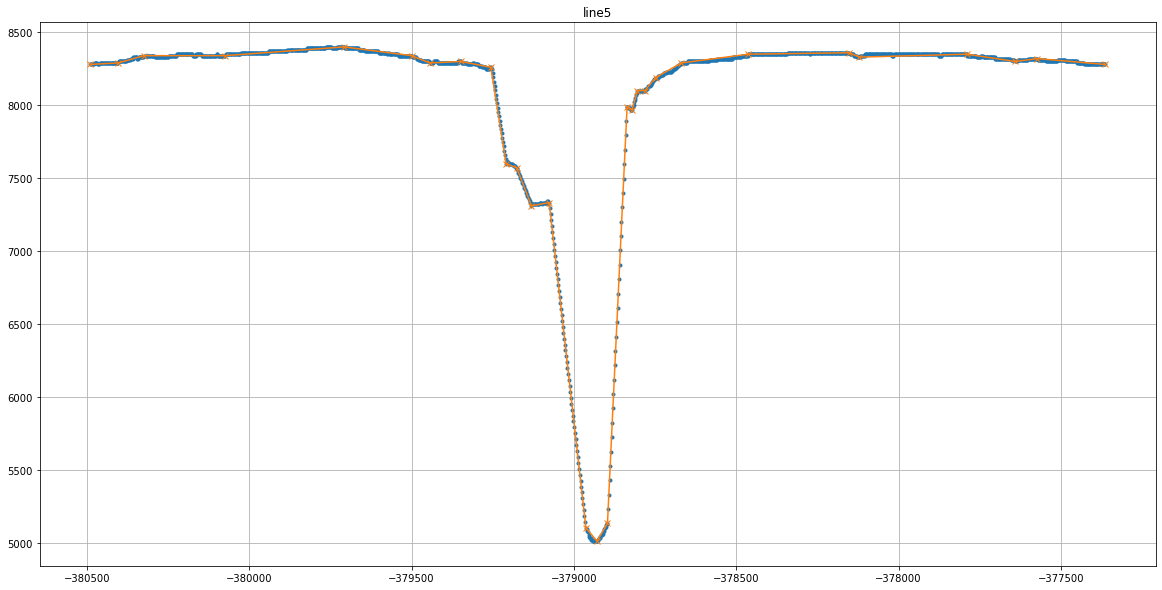

In [87]:
for line_name in ll.keys():
    plot_rdp(line_name,epsilon=20)

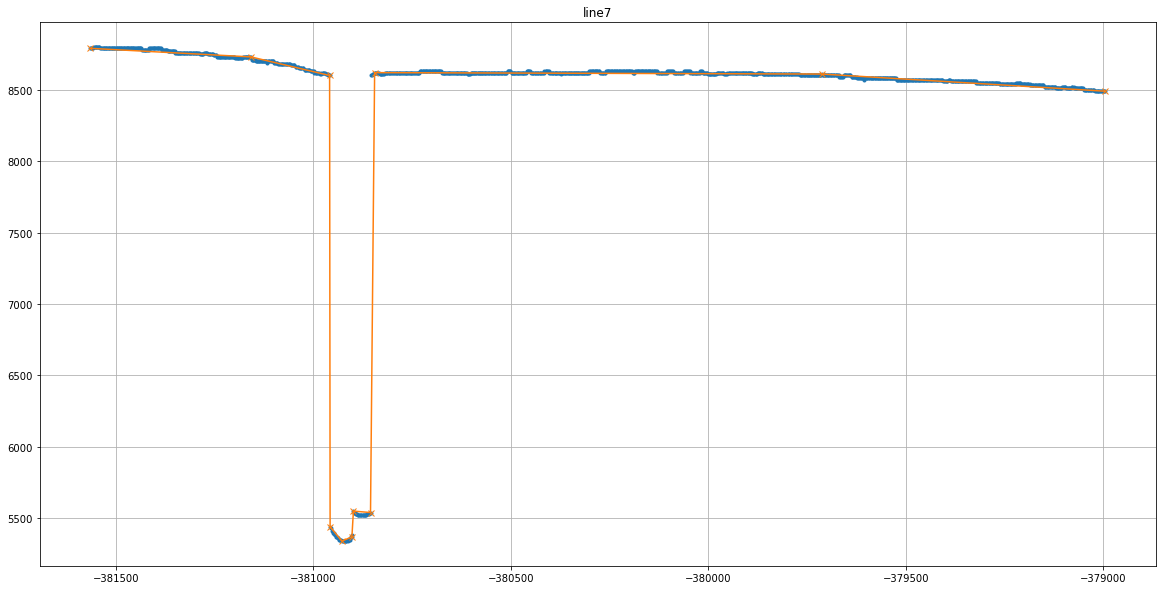

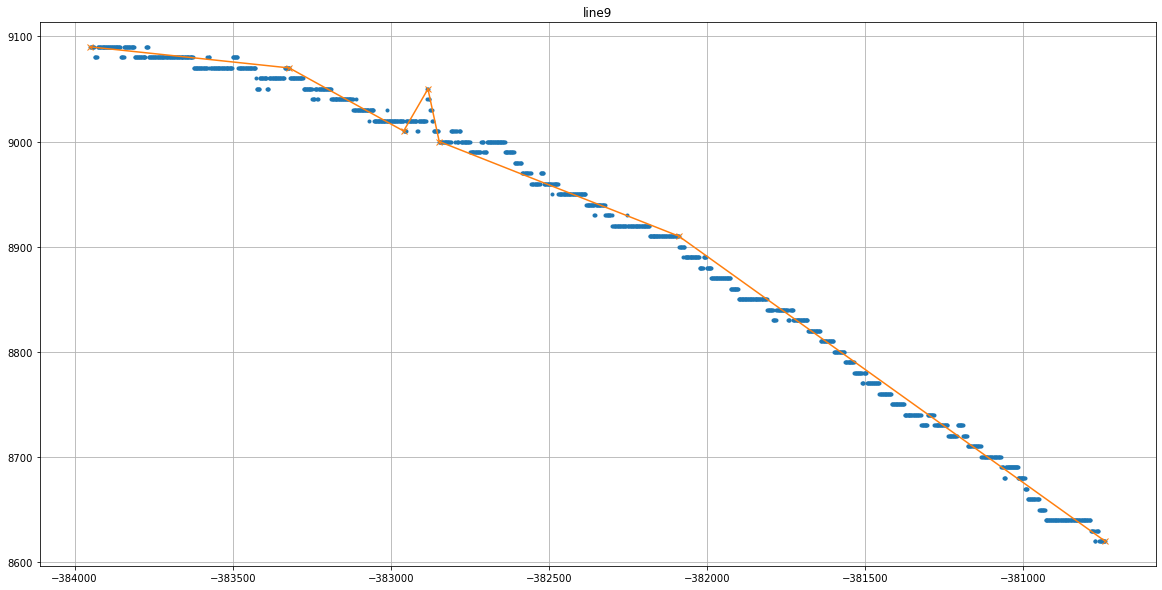

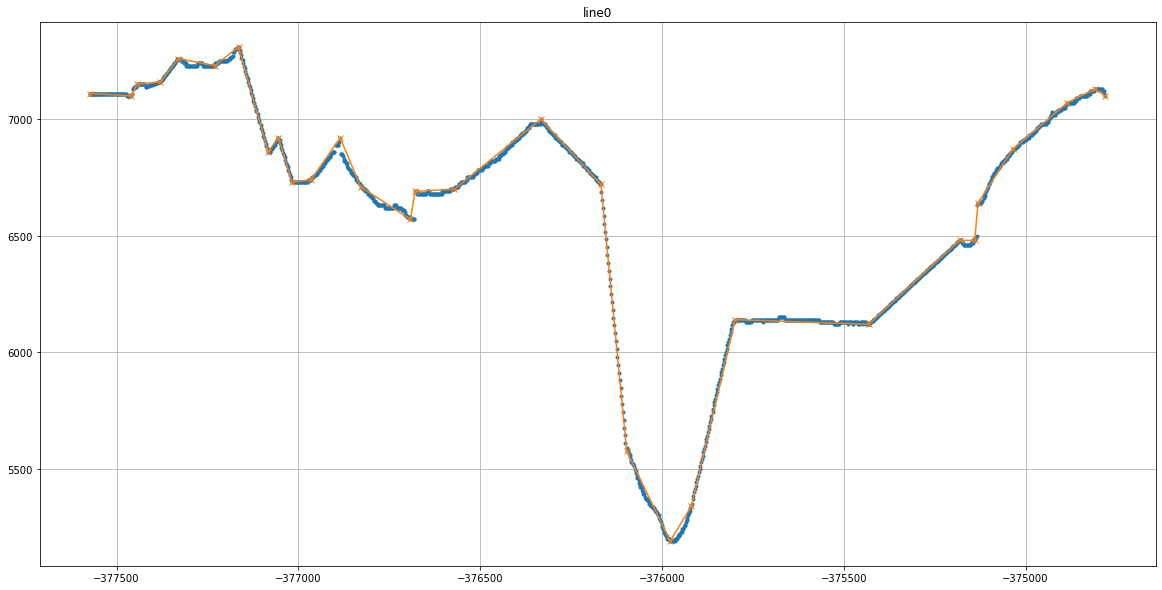

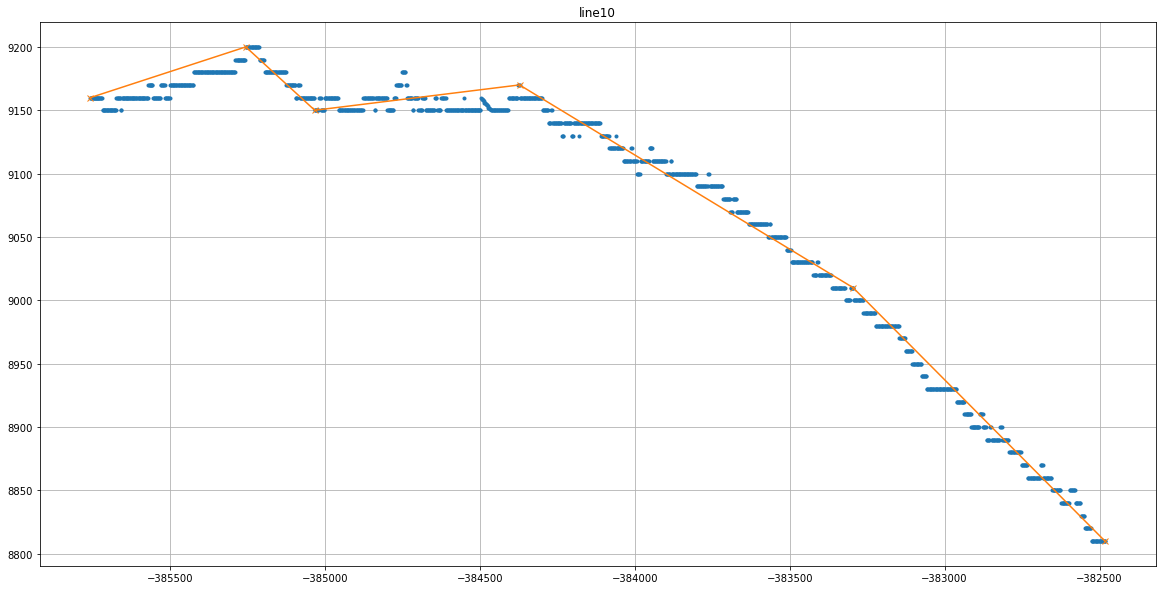

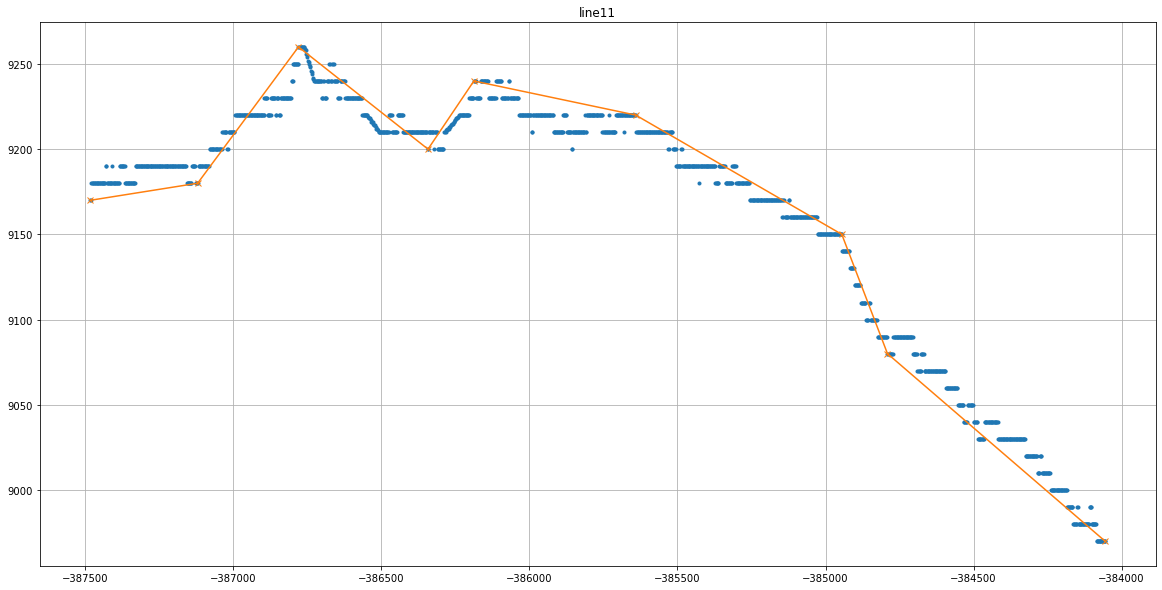

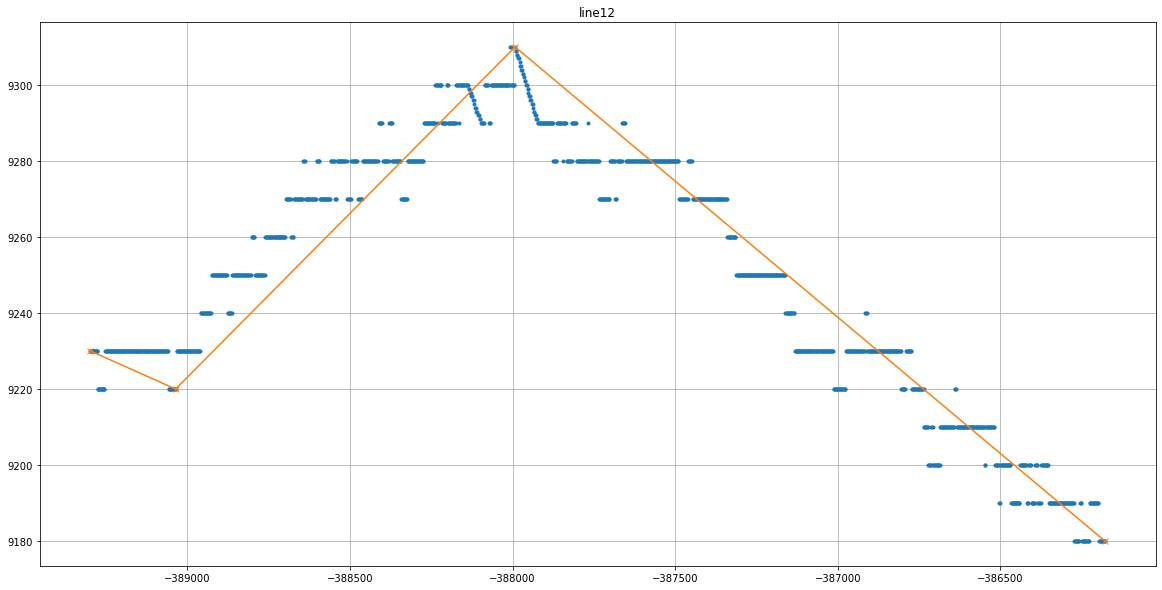

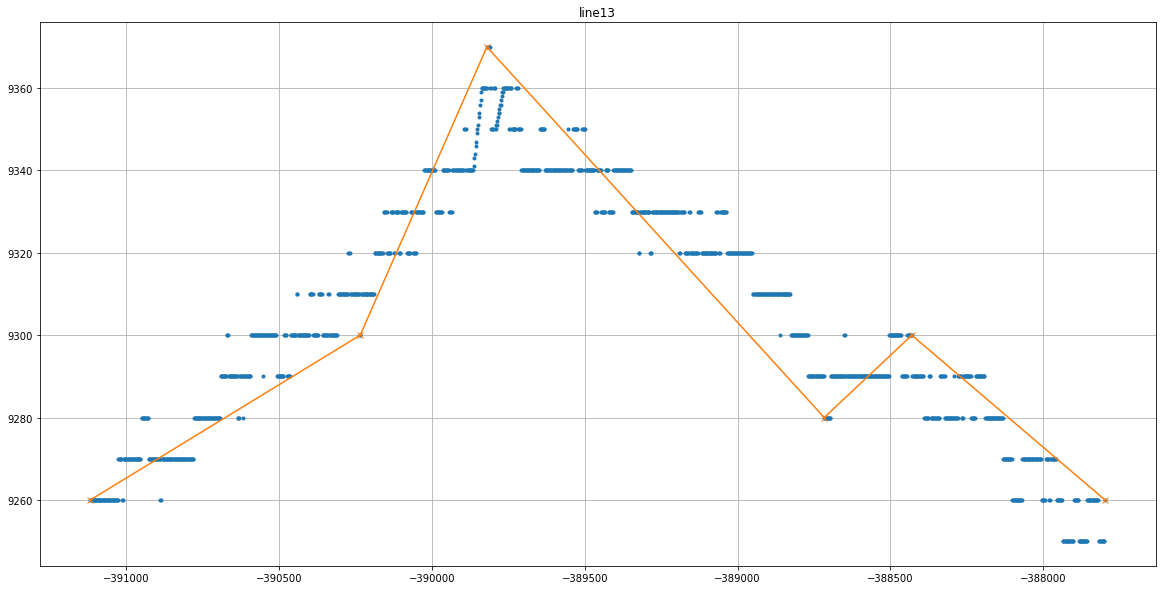

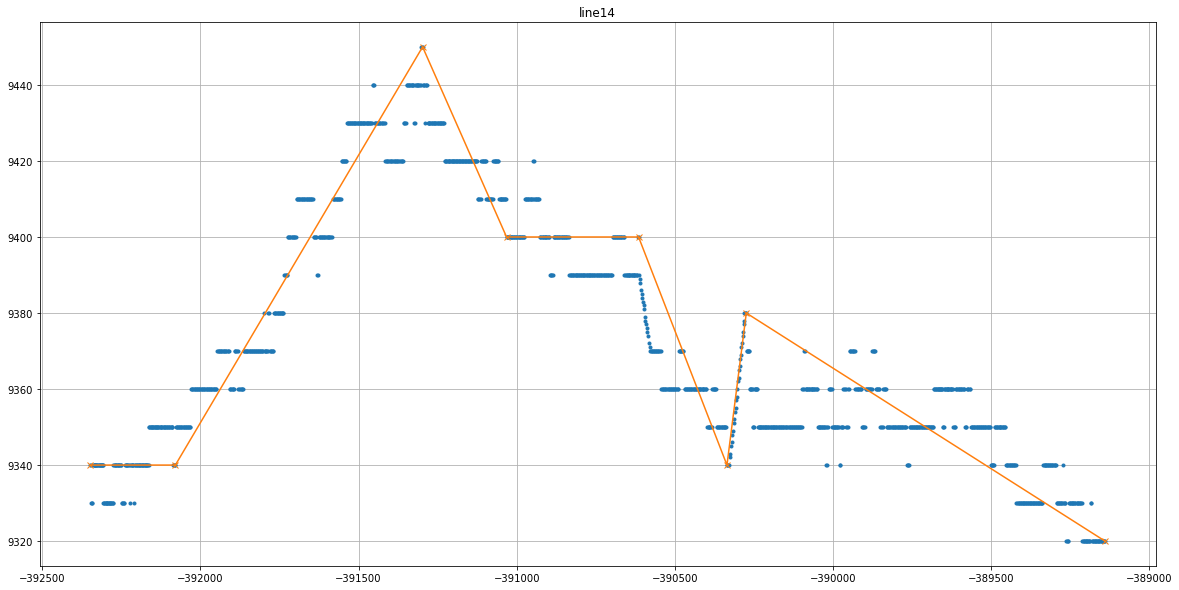

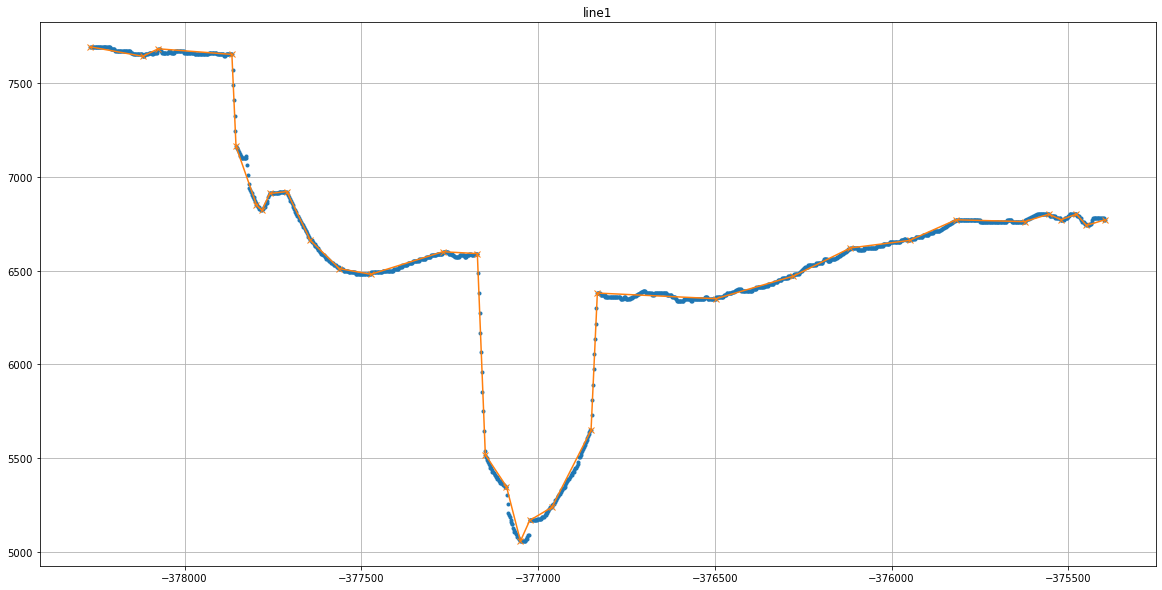

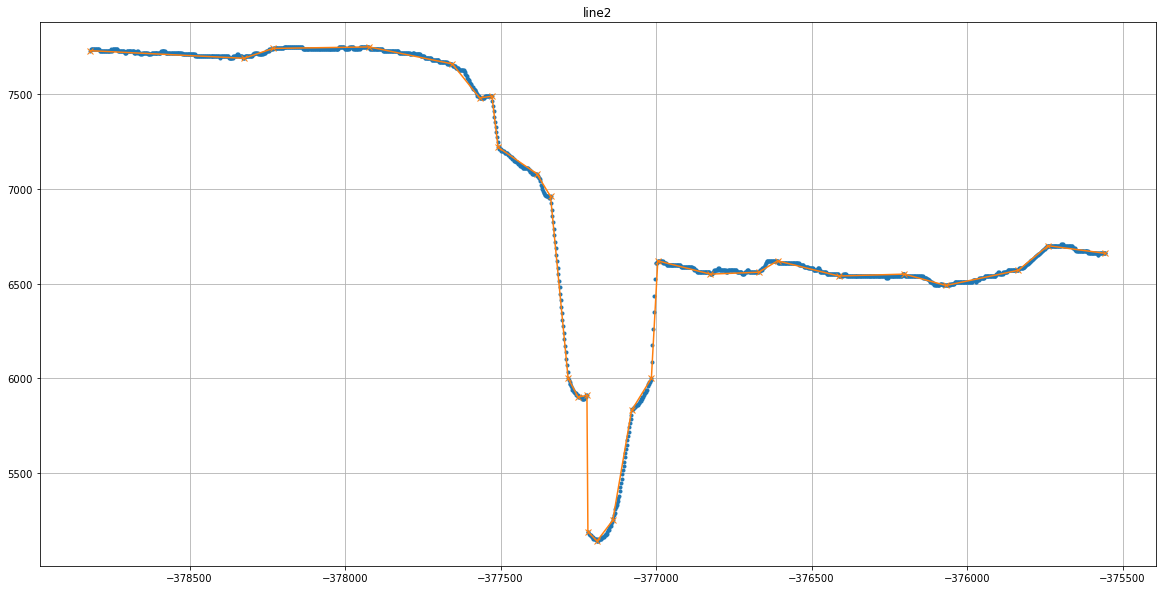

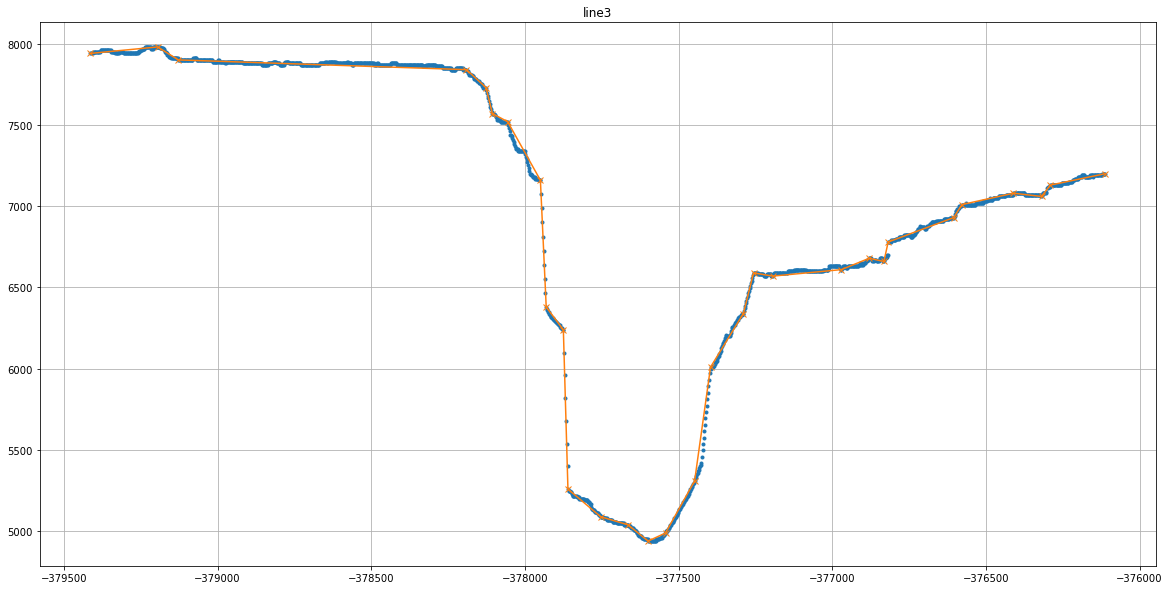

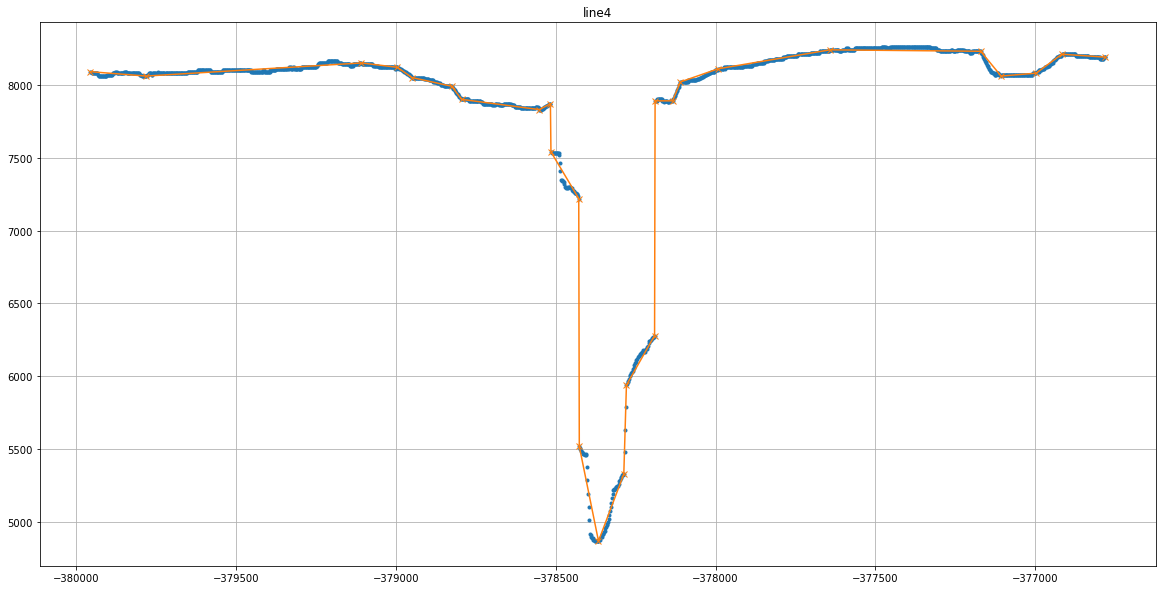

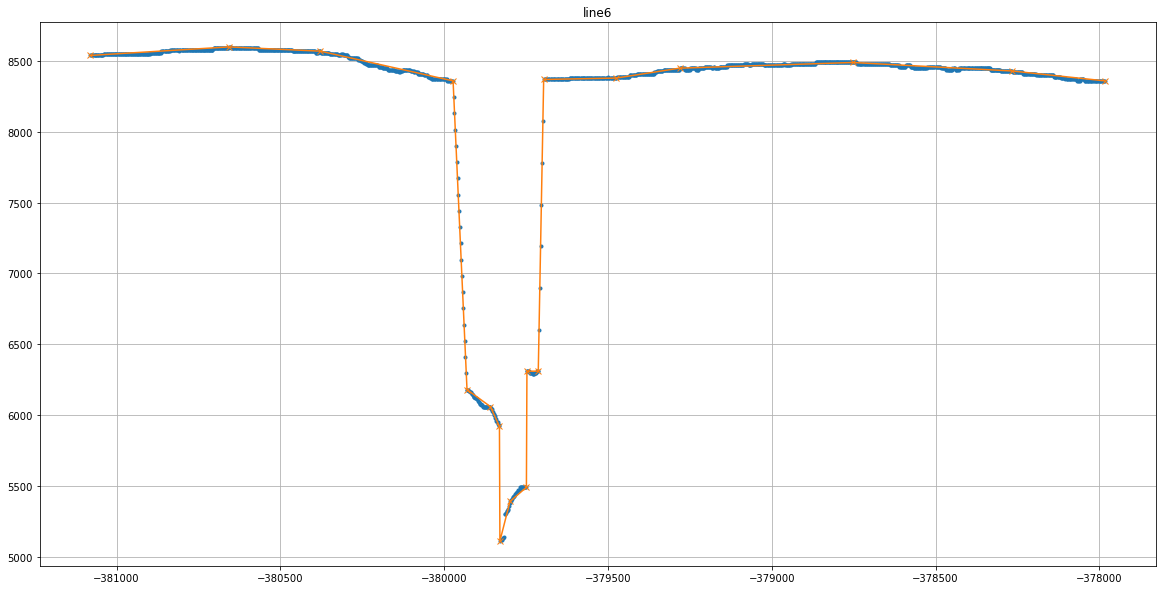

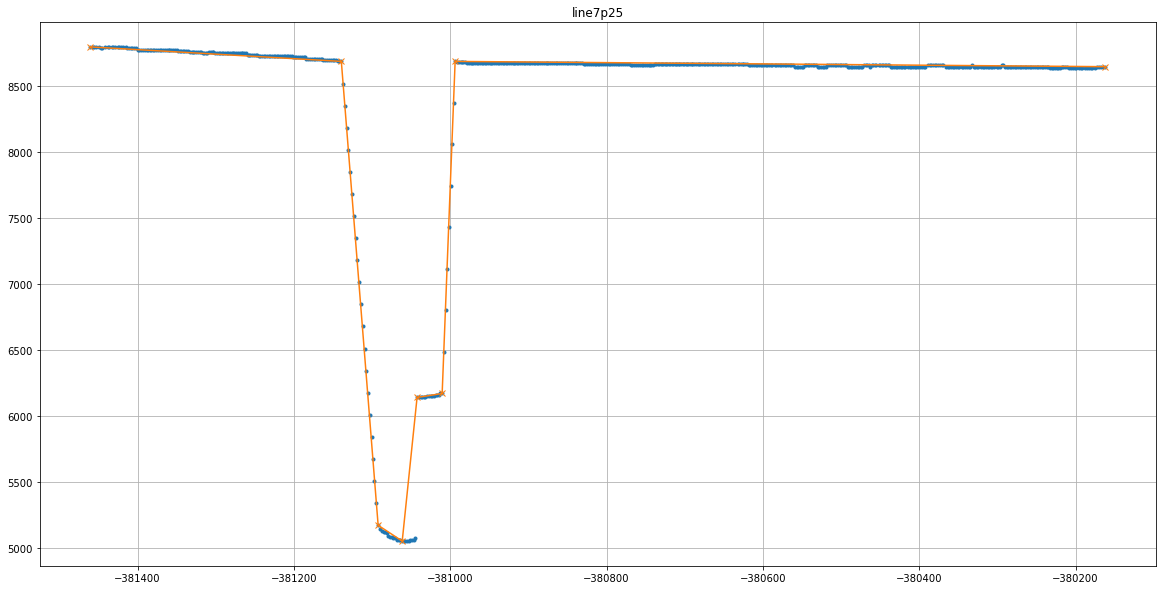

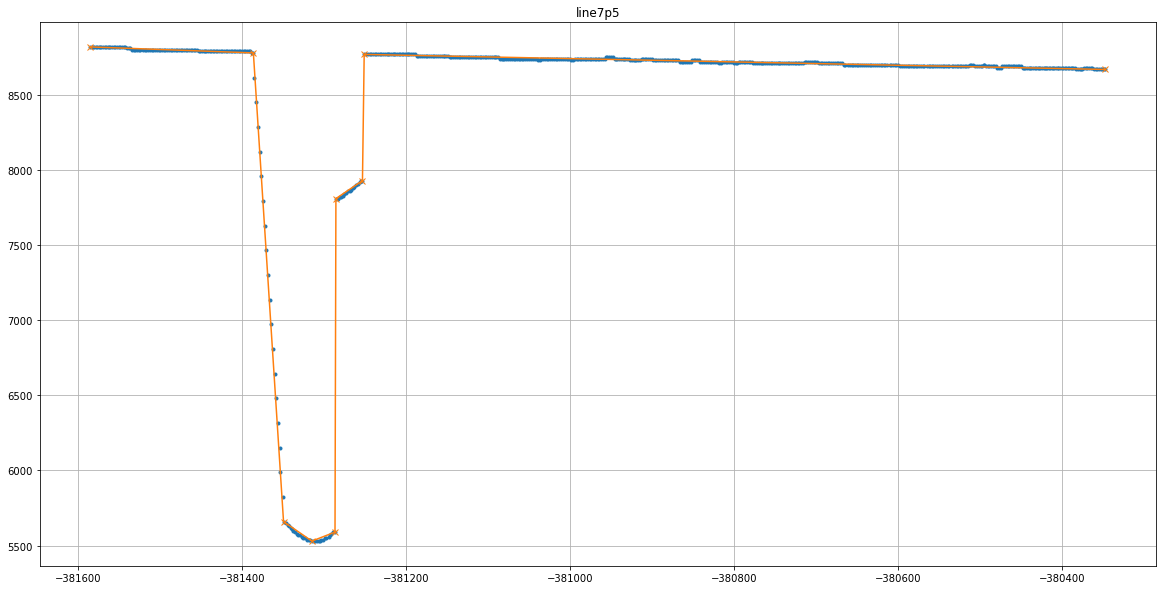

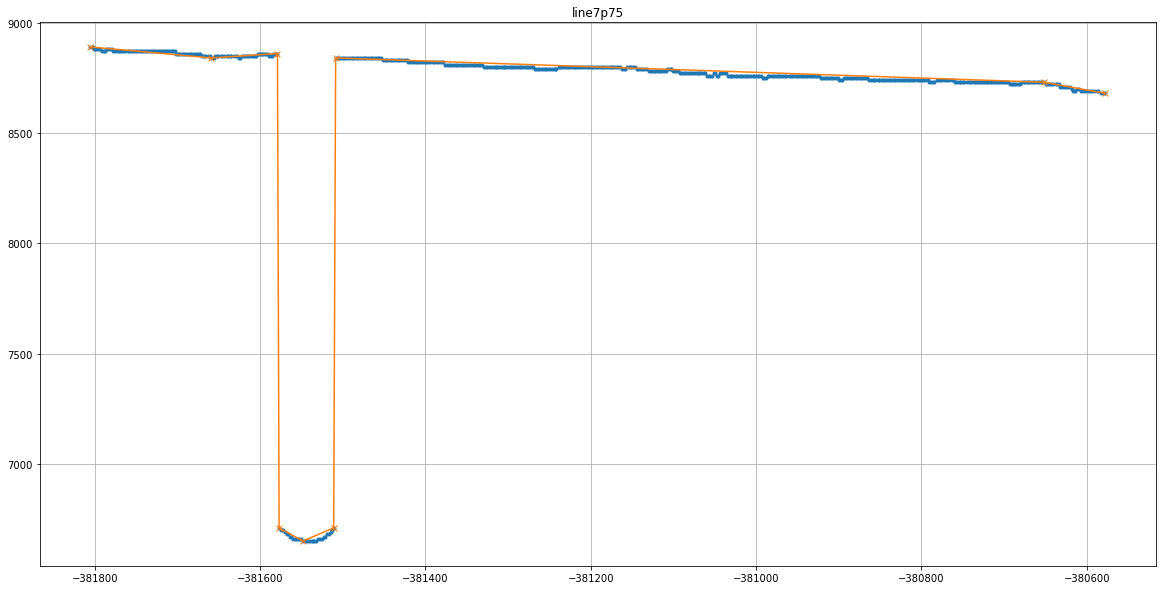

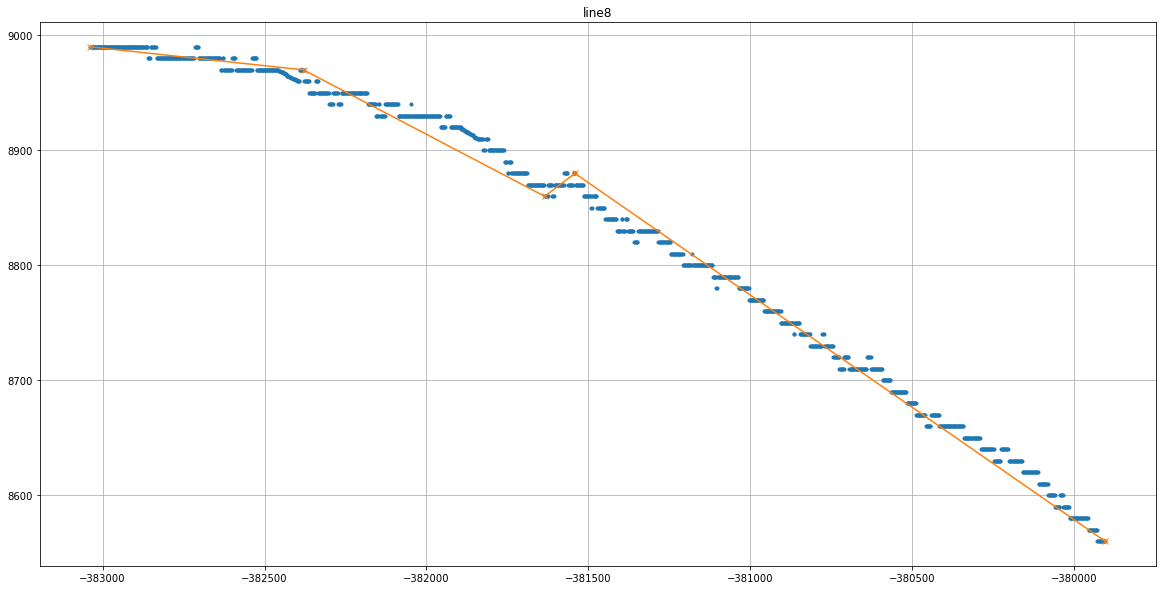

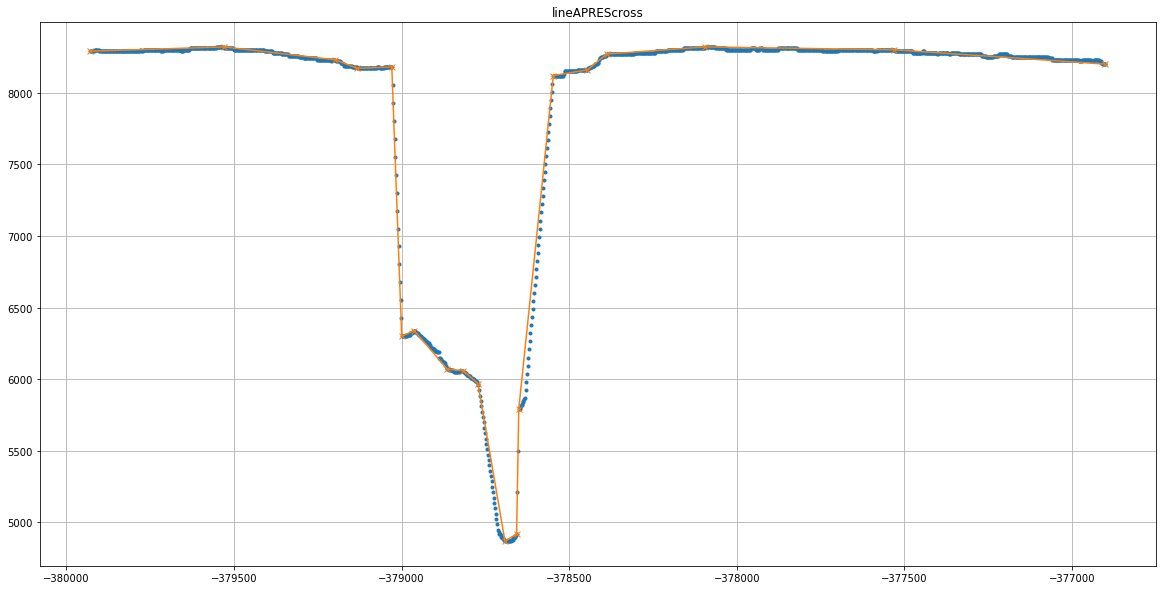

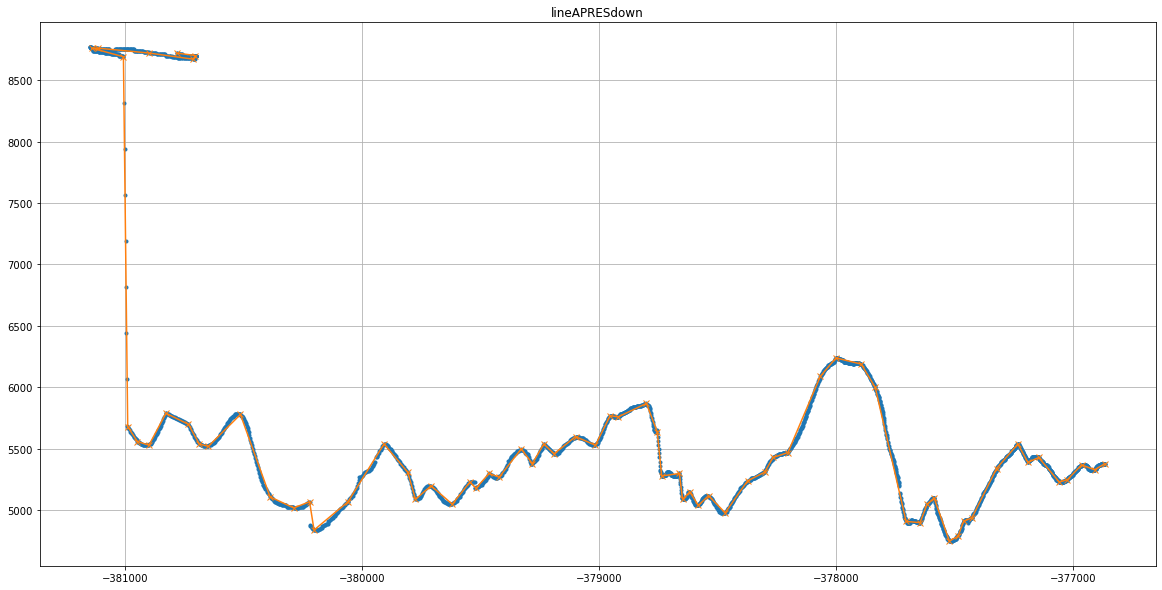

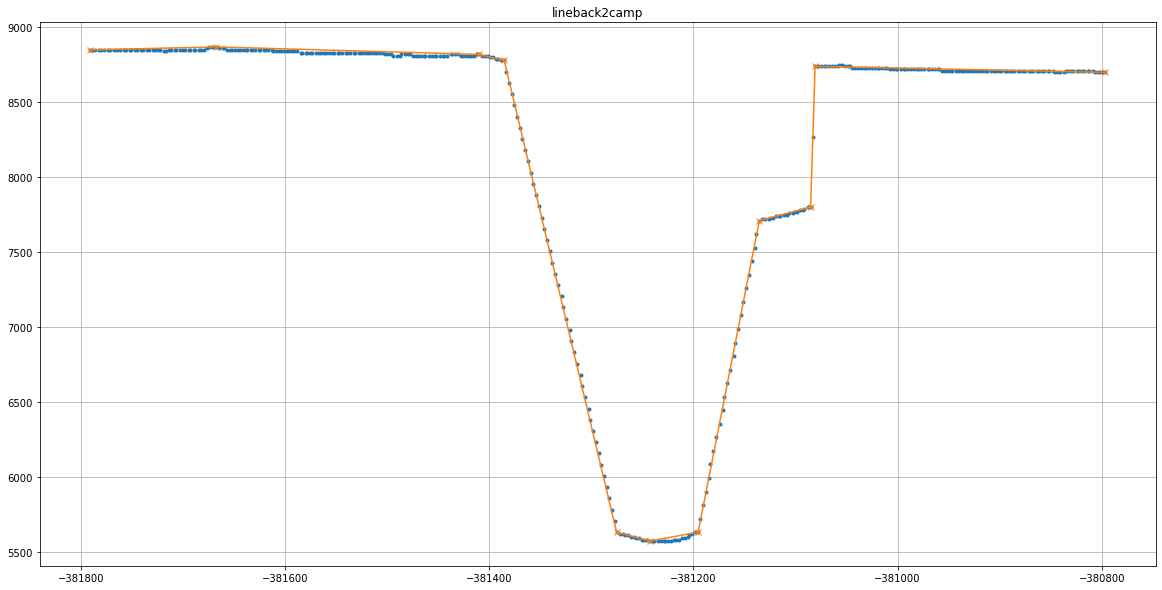

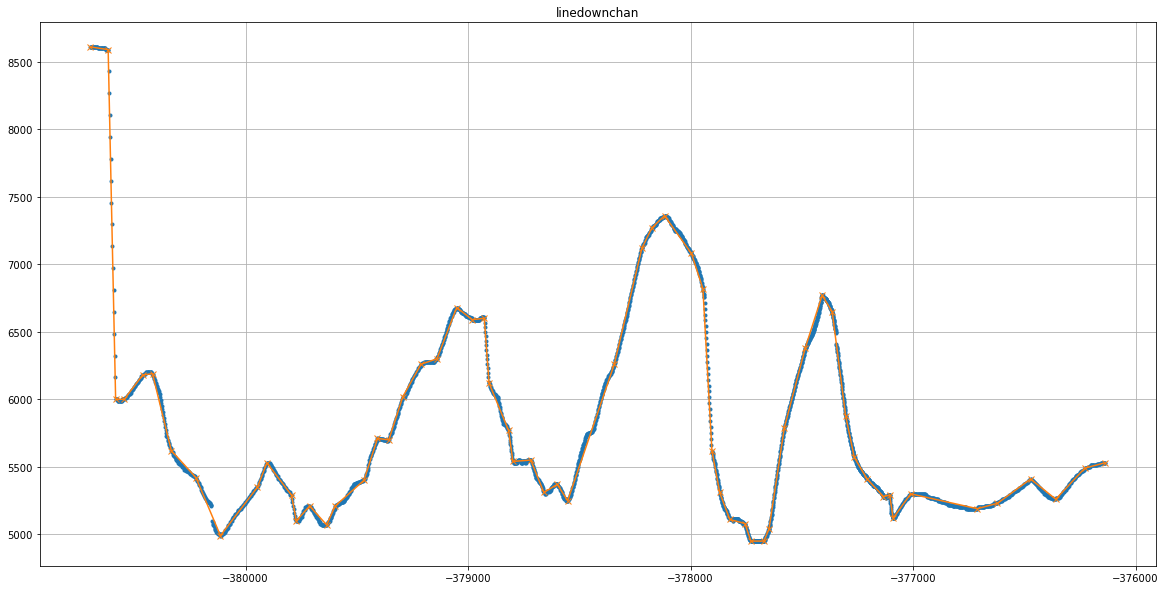

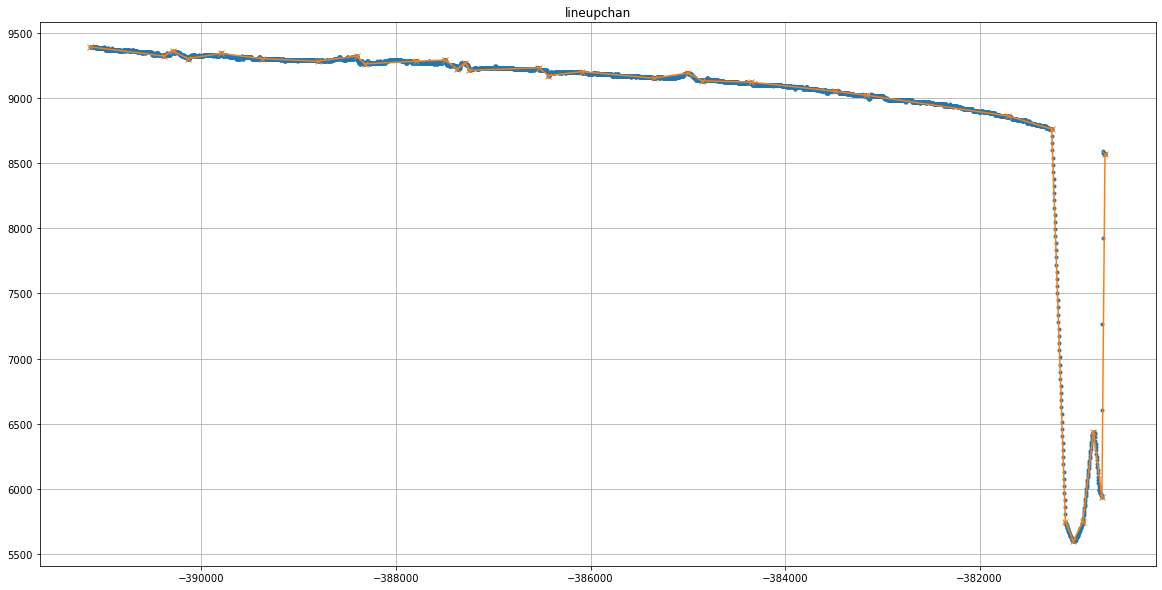

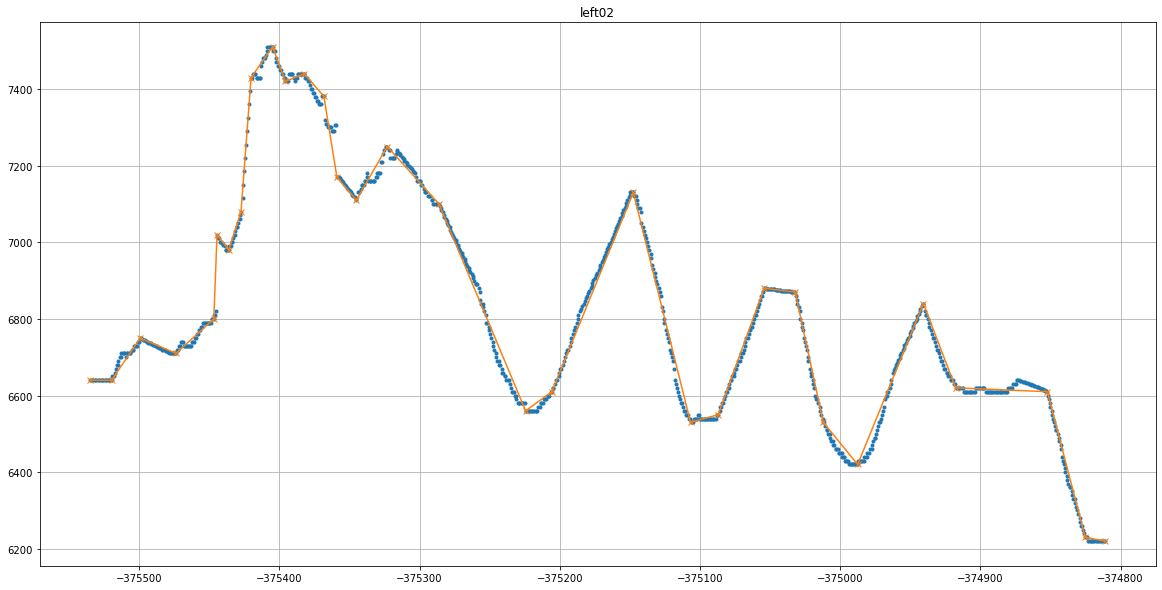

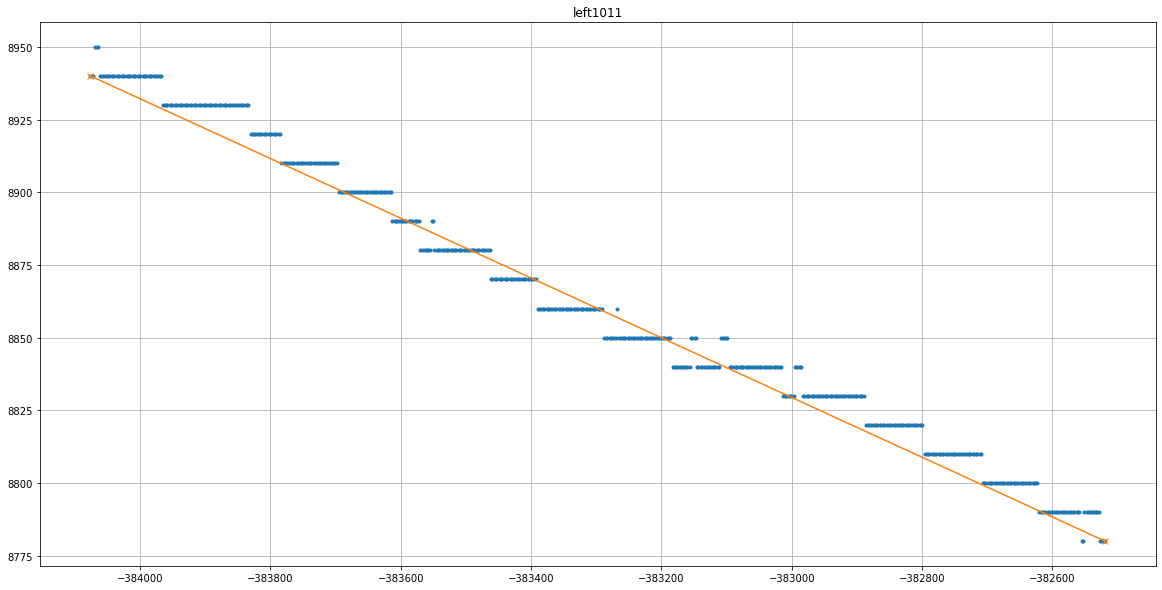

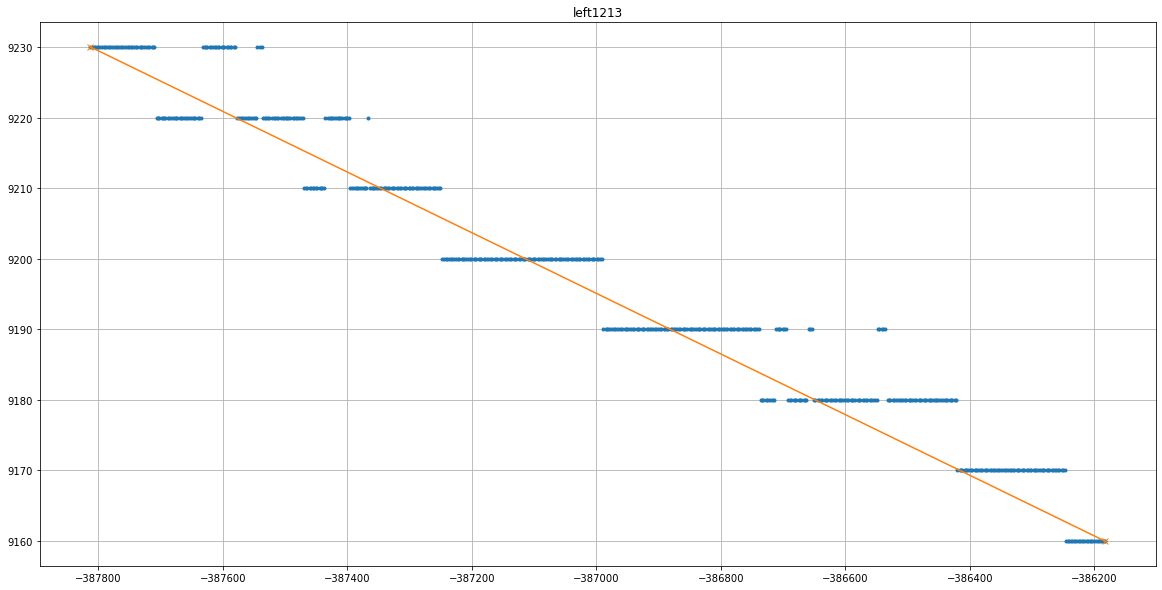

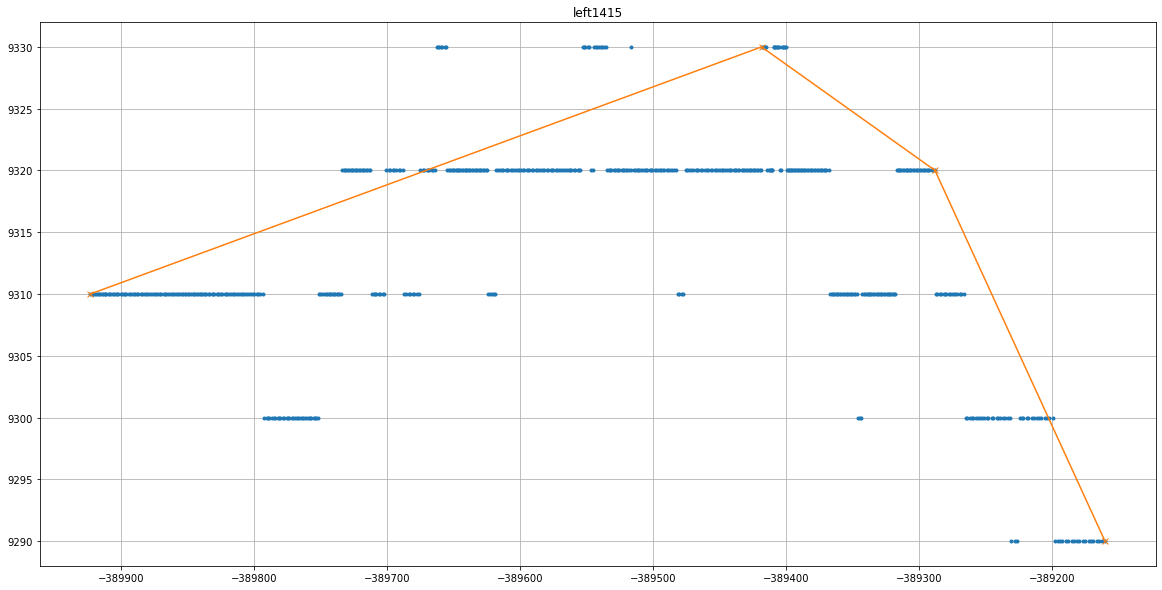

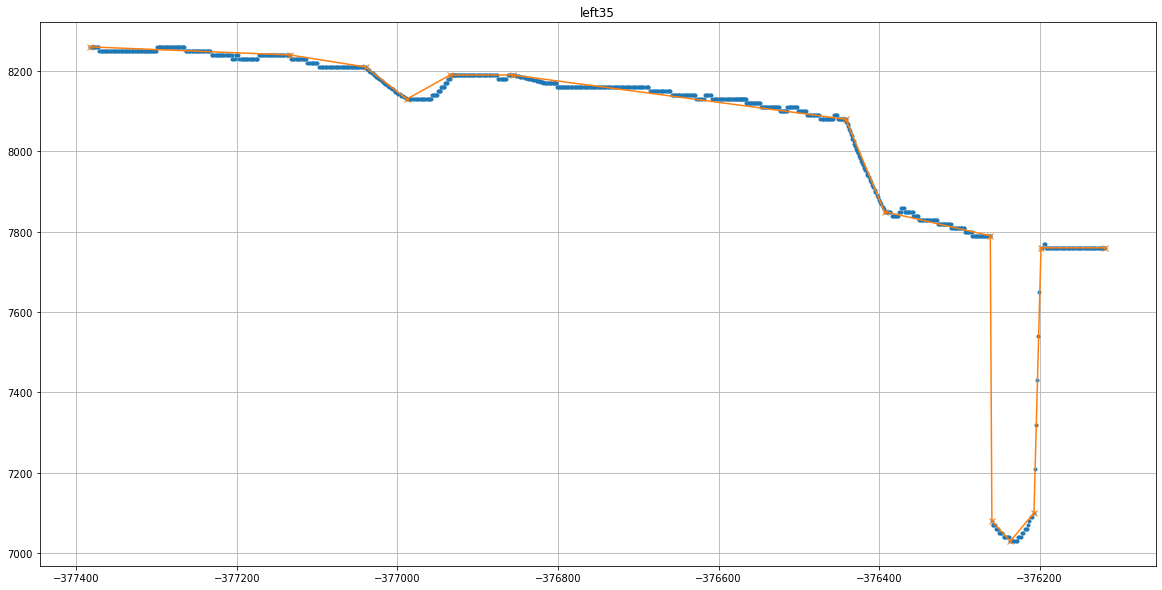

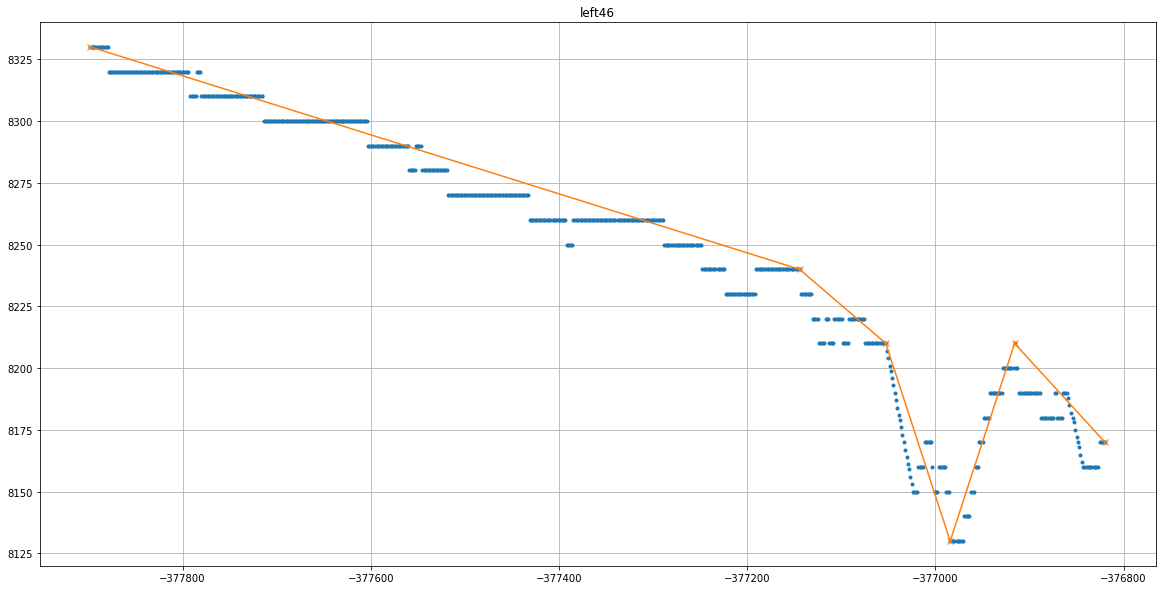

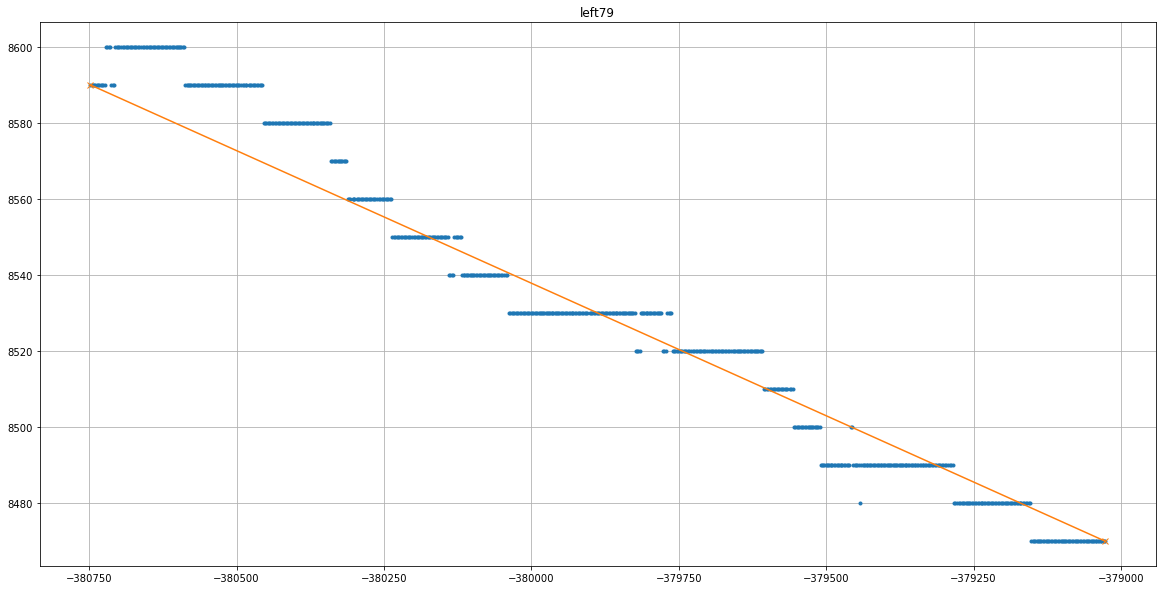

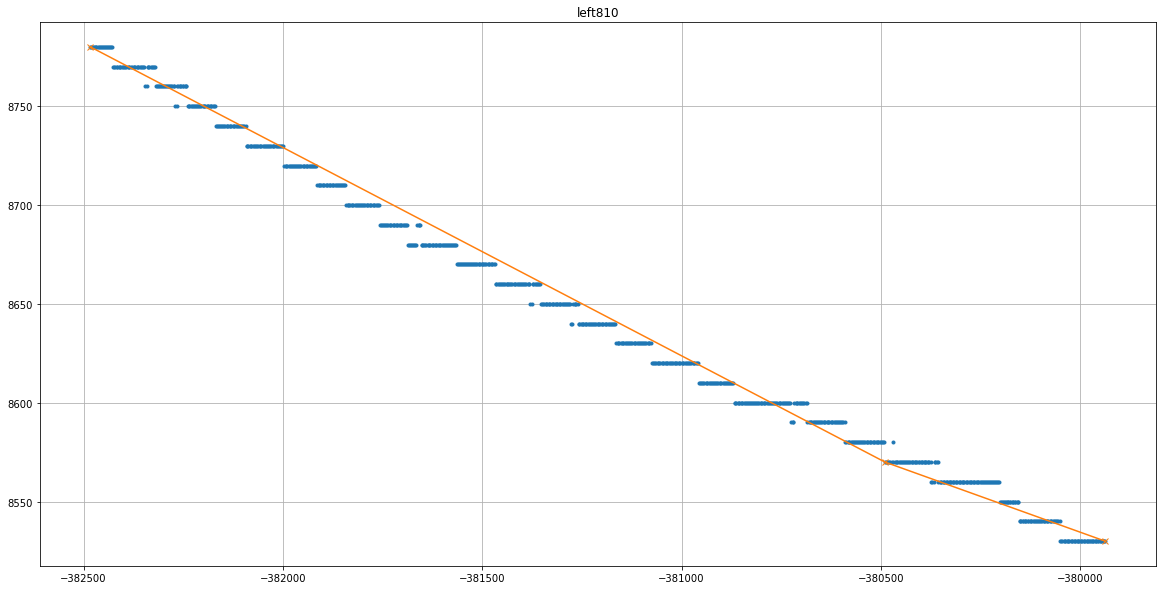

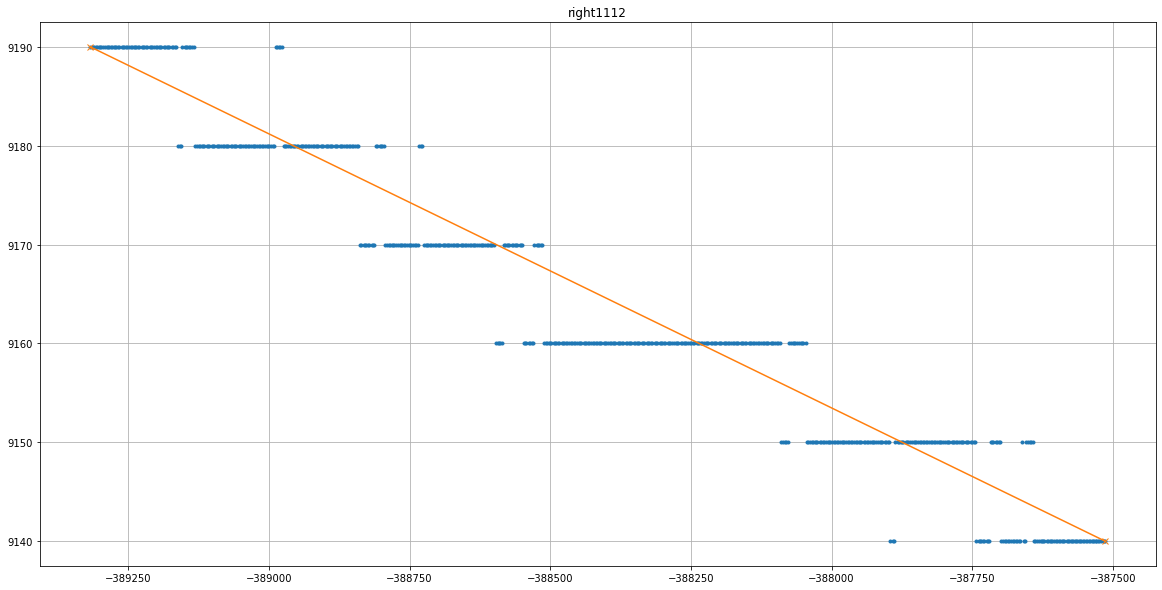

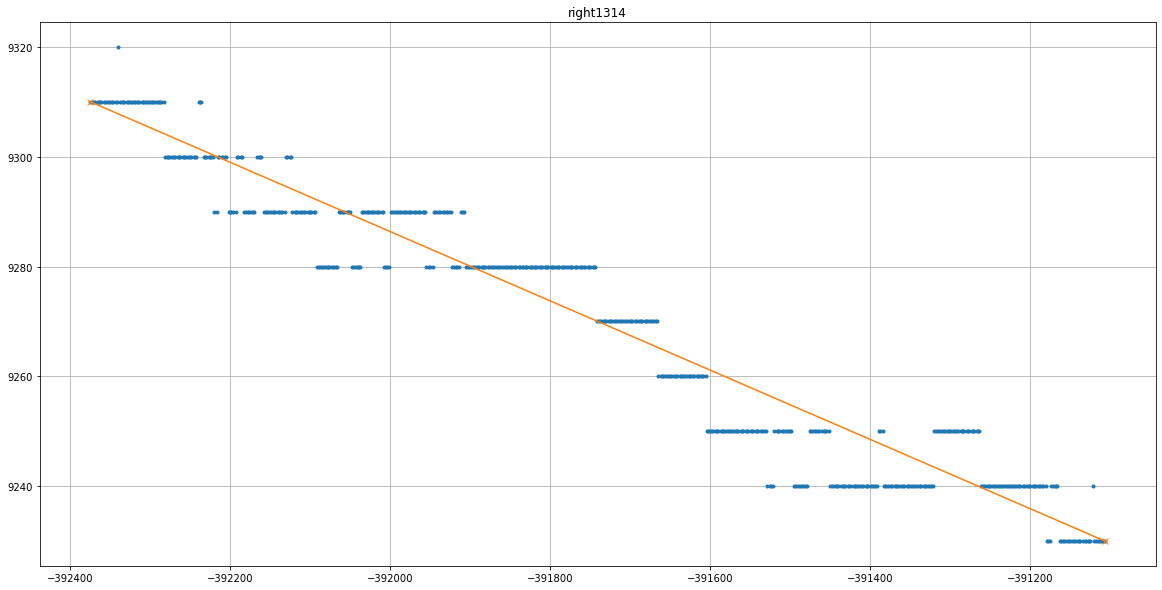

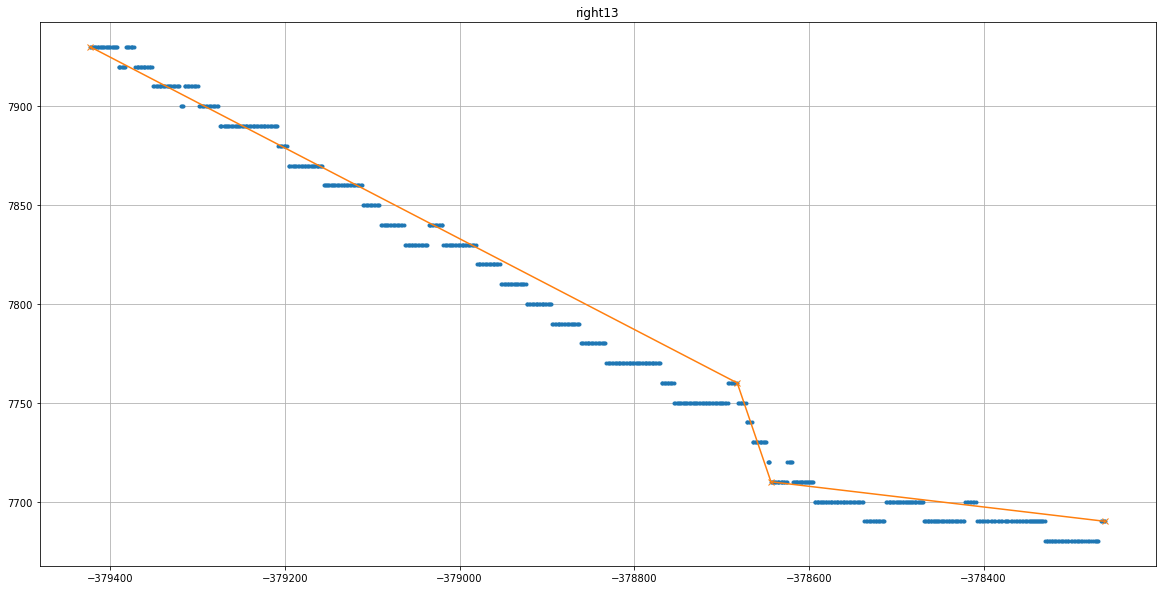

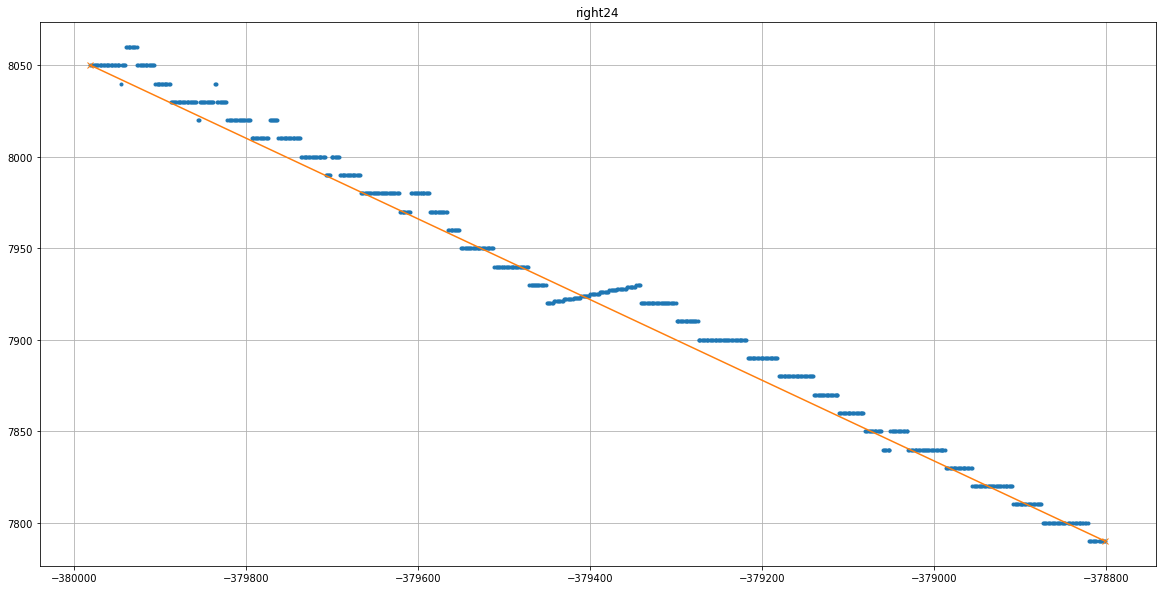

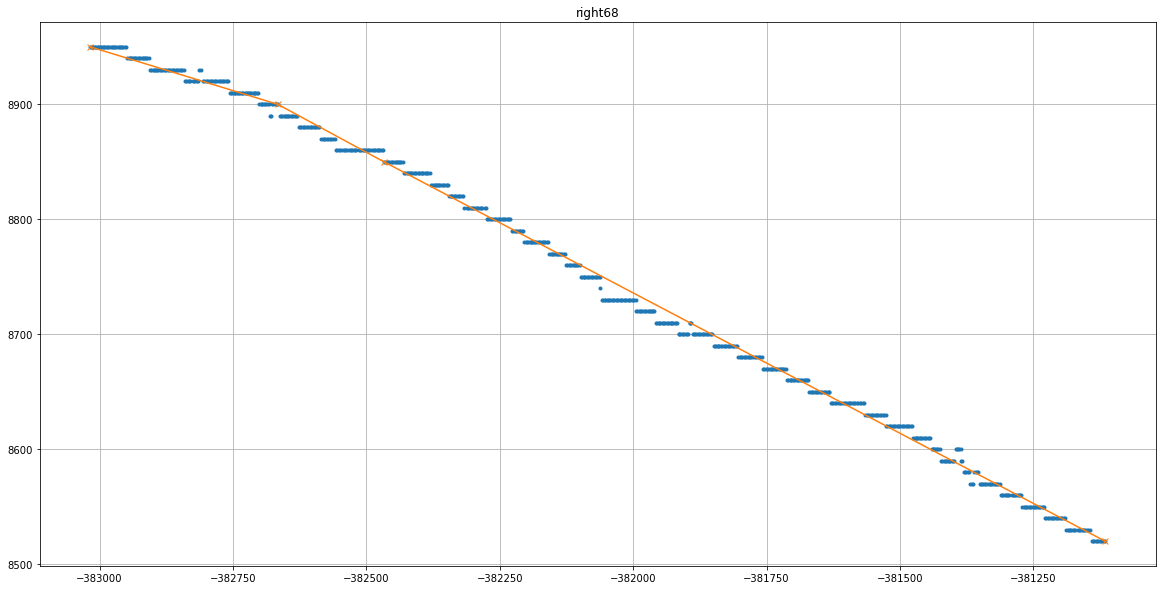

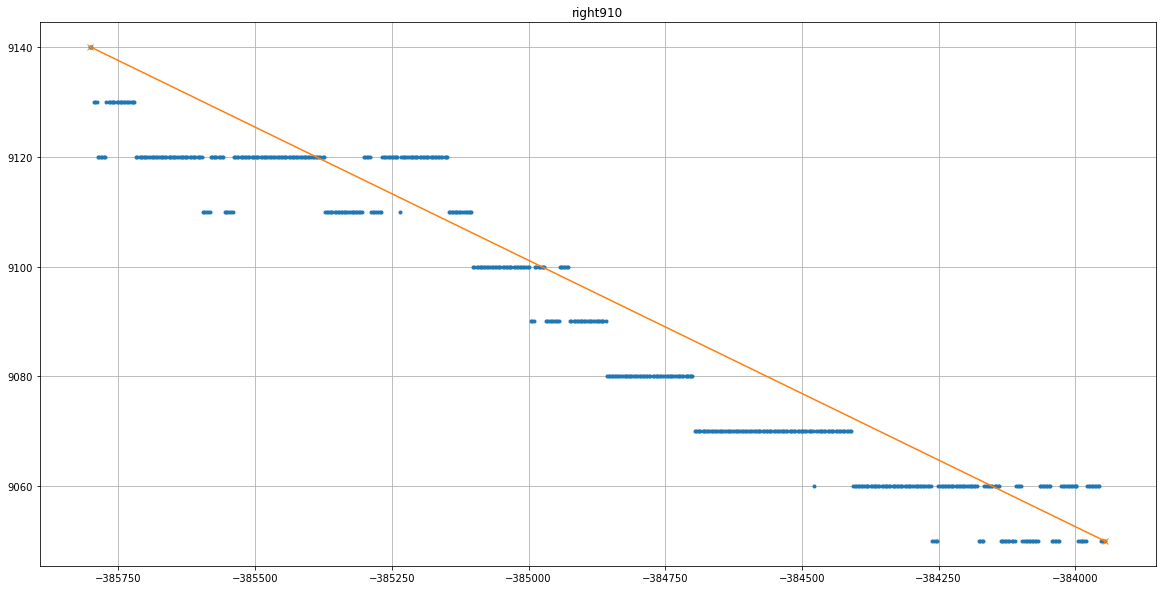

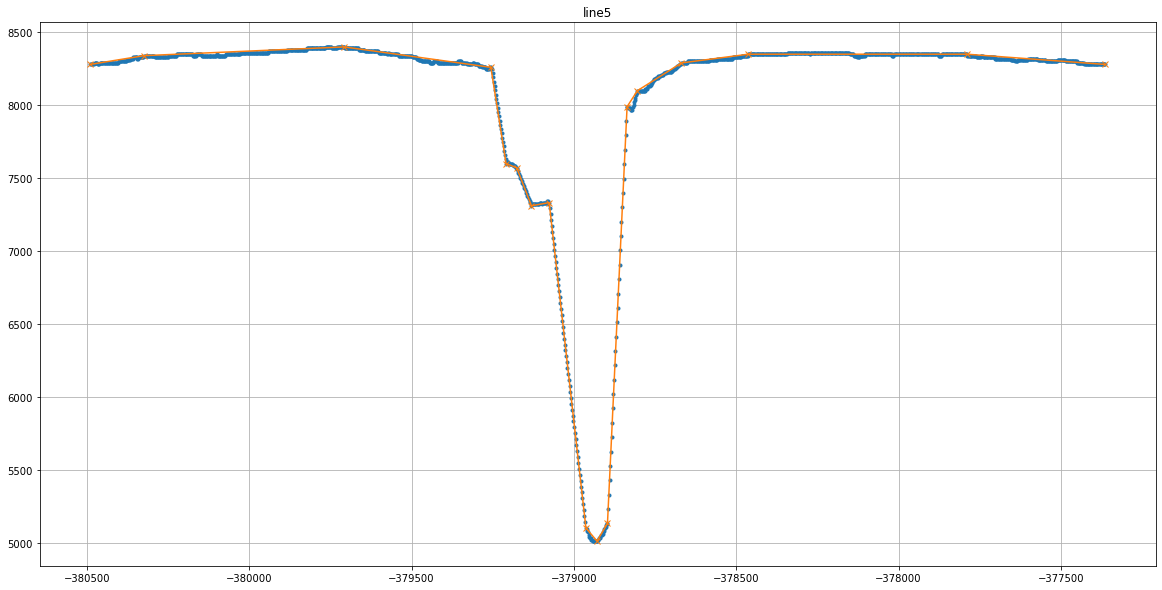

In [88]:
for line_name in ll.keys():
    plot_rdp(line_name,epsilon=30)

In [111]:
sl_list = [a for a in sl.values()]

In [112]:
simplified_lines_gdf = pd.concat(sl_list)
simplified_lines_gdf.reset_index(drop=True, inplace=True)
simplified_lines_gdf.to_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/simplified_lines_gdf.shp')


In [113]:
simplified_lines_gdf

x         y   DELAY                         geometry          dx  \
0   -381564.6 -725999.7  8790.0  POINT (-381564.600 -725999.700)    0.000000   
1   -381386.9 -725786.8  8790.0  POINT (-381386.900 -725786.800)  277.315164   
2   -381243.2 -725627.2  8730.0  POINT (-381243.200 -725627.200)  214.759982   
3   -381158.3 -725534.3  8730.0  POINT (-381158.300 -725534.300)  125.850785   
4   -380959.0 -725328.4  8600.0  POINT (-380959.000 -725328.400)  286.557673   
..        ...       ...     ...                              ...         ...   
787 -379707.8 -727300.9  8400.0  POINT (-379707.800 -727300.900)  311.499807   
788 -380074.3 -727698.8  8340.0  POINT (-380074.300 -727698.800)  540.968262   
789 -380324.5 -727963.6  8340.0  POINT (-380324.500 -727963.600)  364.306300   
790 -380403.7 -728043.3  8290.0  POINT (-380403.700 -728043.300)  112.359824   
791 -380489.3 -728131.8  8280.0  POINT (-380489.300 -728131.800)  123.124368   

      distan_cum line_name  
0       0.000000     line7  
1     277.315164     line7  
2     492.075146     line7  
3     617.925931     line7  
4     904.483604     line7  
..           ...       ...  
787  3418.105284     line5  
788  3959.073545     line5  
789  4323.379845     line5  
790  4435.739669     line5  
791  4558.864037     line5  

[792 rows x 7 columns]